In [8]:
import pandas as pd
import numpy as np
import torch
import os
import optuna
import xgboost as xgb
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

In [9]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Baseline Model
### Dataset

In [10]:
class BaselineDataset(Dataset):
    def __init__(self, transform=None, path=TRAIN_PATH):
        self.data = []
        self.target = []
        for file in os.listdir(path):
            df = pd.read_csv(path + file, sep='|')
            df = df.fillna(method='ffill') # if possible fill with previous value
            df = df.fillna(0) # else fill with 0
            sepsis_discovered = df[df['SepsisLabel'] == 1].drop('SepsisLabel', axis=1)
            self.target.append(1 if not sepsis_discovered.empty else 0)
            self.data.append(torch.Tensor(df.drop('SepsisLabel', axis=1).iloc[-1] if sepsis_discovered.empty else sepsis_discovered.iloc[0]))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

### Model

In [11]:
class Model(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, output_size=2, activation=nn.ReLU(), dropout=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        self.dropout = nn.Dropout(p=dropout)
        self.activation = activation
        self.sequence = nn.Sequential(self.fc1, self.activation, self.dropout, self.fc2, self.activation, self.dropout, self.fc3, self.activation)

    def forward(self, x):
        return self.sequence(x)

### Hyperparameter Tuning

In [12]:
train_set = BaselineDataset()
test_set = BaselineDataset(path=TEST_PATH)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [183]:
def train(loss_fn, optimizer, model,  train_dataloader, test_dataloader, device=device, epochs=20, save_best=False, save_name='best_baseline_model.pt', accumulate_grad=False, batch_size=32):
    train_losses = []
    test_losses = []
    train_f1_scores = []
    test_f1_scores = []
    max_f1_score = 0
    optimizer.zero_grad()
    for i in range(epochs):
        model.train()
        train_loss = 0
        train_f1_score = 0
        for j, data in enumerate(train_dataloader):
            input, target = data
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            pred = torch.argmax(output, dim=1)
            train_f1_score += f1_score(target.to(torch.device('cpu')), pred.to(torch.device('cpu')))
            loss = loss_fn(output, target)
            train_loss += loss.item()
            if accumulate_grad:
                loss = loss/batch_size
            loss.backward()
            if not accumulate_grad or j+1 % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
        if accumulate_grad and j+1 % batch_size != 0:
            optimizer.step()
            optimizer.zero_grad()
        train_f1_scores.append(train_f1_score/len(train_dataloader))
        train_losses.append(train_loss/len(train_dataloader))
        test_loss, test_f1_score = activity(model, test_dataloader, loss_fn, device)
        test_losses.append(test_loss)
        test_f1_scores.append(test_f1_score)
        if save_best and test_f1_score > max_f1_score:
            max_f1_score = test_f1_score
            torch.save(model, save_name)
        if ((i+1) % 1) == 0:
            print('Epoch: {} Train Loss: {} Test Loss: {}'.format(i+1, train_losses[-1], test_losses[-1]))
    return train_losses, test_losses, train_f1_scores, test_f1_scores

def activity(model, test_dataloader, loss_fn, device):
    model.eval()
    preds = []
    targets = []
    test_loss = 0
    test_f1_score = 0
    with torch.no_grad():
        for data in test_dataloader:
            input, target = data
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            pred = torch.argmax(output, dim=1)
            preds.append(pred)
            targets.append(target)
            loss = loss_fn(output, target)
            test_loss += loss.item()
        return test_loss/len(test_dataloader), f1_score(torch.cat(targets).to(torch.device('cpu')), torch.cat(preds).to(torch.device('cpu')))


In [31]:

def objective(trial):
    epochs = 25
    hidden_size = trial.suggest_int('hidden_size', 32, 512)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh', 'Sigmoid'])
    dropout = trial.suggest_float('dropout', 0, 0.5)
    model = Model(hidden_size=hidden_size, activation=getattr(nn, activation)(), dropout=dropout).to(device)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(loss, optimizer, model, train_dataloader, test_dataloader, device, epochs)
    return max(test_f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2023-04-26 18:57:35,605] A new study created in memory with name: no-name-ba0a5e70-77d0-43ac-be51-244e39f75e5e


Epoch: 5 Train Loss: 0.2849283045530319 Test Loss: 0.26862093839592066
Epoch: 10 Train Loss: 0.2996696368515491 Test Loss: 0.2580919856556688
Epoch: 20 Train Loss: 0.44400461468696595 Test Loss: 0.2576608962406175


[I 2023-04-26 18:58:24,456] Trial 0 finished with value: 0.2193087008343266 and parameters: {'hidden_size': 34, 'activation': 'LeakyReLU', 'dropout': 0.45170610376247833, 'optimizer': 'SGD', 'lr': 0.0897902106926009}. Best is trial 0 with value: 0.2193087008343266.


Epoch: 5 Train Loss: 0.37481662158966067 Test Loss: 0.3779879840799033
Epoch: 10 Train Loss: 0.37282218551635743 Test Loss: 0.3761645909696341
Epoch: 20 Train Loss: 0.3696290683746338 Test Loss: 0.37402535218019456


[I 2023-04-26 18:59:38,460] Trial 1 finished with value: 0.3285556780595369 and parameters: {'hidden_size': 422, 'activation': 'Sigmoid', 'dropout': 0.31941093005908283, 'optimizer': 'Adagrad', 'lr': 0.012593939376746341}. Best is trial 1 with value: 0.3285556780595369.


Epoch: 5 Train Loss: 0.22676582374572754 Test Loss: 0.22092872754501078
Epoch: 10 Train Loss: 0.218454593783617 Test Loss: 0.21751990037175795
Epoch: 20 Train Loss: 0.20051098237633705 Test Loss: 0.19550164428334266


[I 2023-04-26 19:00:38,084] Trial 2 finished with value: 0.4170905391658189 and parameters: {'hidden_size': 446, 'activation': 'LeakyReLU', 'dropout': 0.47250498039237493, 'optimizer': 'SGD', 'lr': 0.02326316582562312}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.3851619474887848 Test Loss: 0.3882559073237946
Epoch: 10 Train Loss: 0.3845842962265015 Test Loss: 0.3879026607773936
Epoch: 20 Train Loss: 0.38428718719482424 Test Loss: 0.3874645753028675


[I 2023-04-26 19:01:48,055] Trial 3 finished with value: 0.0 and parameters: {'hidden_size': 176, 'activation': 'Sigmoid', 'dropout': 0.23671597001421707, 'optimizer': 'SGD', 'lr': 0.014167663049686991}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.38449625544548033 Test Loss: 0.38754711516748985
Epoch: 10 Train Loss: 0.3842476710319519 Test Loss: 0.3875892168035903
Epoch: 20 Train Loss: 0.3841280940532684 Test Loss: 0.38770957657704336


[I 2023-04-26 19:02:55,608] Trial 4 finished with value: 0.0 and parameters: {'hidden_size': 64, 'activation': 'Sigmoid', 'dropout': 0.24537159804164427, 'optimizer': 'SGD', 'lr': 0.06929998144519978}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.24955121126174926 Test Loss: 0.25449886975196984
Epoch: 10 Train Loss: 0.2483787306547165 Test Loss: 0.2540035681507458
Epoch: 20 Train Loss: 0.2486189647436142 Test Loss: 0.25391187045140007


[I 2023-04-26 19:03:46,362] Trial 5 finished with value: 0.25611175785797435 and parameters: {'hidden_size': 146, 'activation': 'Tanh', 'dropout': 0.17754799731228355, 'optimizer': 'SGD', 'lr': 0.08627811173332545}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.2455145938873291 Test Loss: 0.25228357953004565
Epoch: 10 Train Loss: 0.2455427809715271 Test Loss: 0.2607932885329183
Epoch: 20 Train Loss: 0.2441560864686966 Test Loss: 0.2511727026285836


[I 2023-04-26 19:04:26,137] Trial 6 finished with value: 0.3036649214659686 and parameters: {'hidden_size': 306, 'activation': 'Tanh', 'dropout': 0.020515591190151783, 'optimizer': 'SGD', 'lr': 0.08300026917518447}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 19:05:11,597] Trial 7 finished with value: 0.0 and parameters: {'hidden_size': 220, 'activation': 'ReLU', 'dropout': 0.4833368107324993, 'optimizer': 'Adam', 'lr': 0.05066326131481137}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 152.97585046875437 Test Loss: 21.73873467948109
Epoch: 10 Train Loss: 18.315893552377077 Test Loss: 6.938804901684054
Epoch: 20 Train Loss: 23.625510354128103 Test Loss: 5.908177728672932


[I 2023-04-26 19:05:54,964] Trial 8 finished with value: 0.18604651162790695 and parameters: {'hidden_size': 109, 'activation': 'LeakyReLU', 'dropout': 0.45139004077246353, 'optimizer': 'Adam', 'lr': 0.09711447856925819}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.38401195030212404 Test Loss: 0.3873433371702322
Epoch: 10 Train Loss: 0.3840119439125061 Test Loss: 0.38724349720028645
Epoch: 20 Train Loss: 0.38401193079948426 Test Loss: 0.38764286060302783


[I 2023-04-26 19:06:51,237] Trial 9 finished with value: 0.0 and parameters: {'hidden_size': 480, 'activation': 'Sigmoid', 'dropout': 0.34676808051679336, 'optimizer': 'Adagrad', 'lr': 0.09801225696711671}. Best is trial 2 with value: 0.4170905391658189.


Epoch: 5 Train Loss: 0.18929922153055667 Test Loss: 0.17973165281902487
Epoch: 10 Train Loss: 0.16627933861017227 Test Loss: 0.16072332521025745
Epoch: 20 Train Loss: 0.15465037134587764 Test Loss: 0.14861383418829296


[I 2023-04-26 19:08:13,827] Trial 10 finished with value: 0.6202749140893471 and parameters: {'hidden_size': 348, 'activation': 'LeakyReLU', 'dropout': 0.41090768272293177, 'optimizer': 'Adagrad', 'lr': 0.02689756244343235}. Best is trial 10 with value: 0.6202749140893471.


Epoch: 5 Train Loss: 0.2148353850990534 Test Loss: 0.18717113469307795
Epoch: 10 Train Loss: 0.16631976574957372 Test Loss: 0.16403953082407244
Epoch: 20 Train Loss: 0.14417487835884094 Test Loss: 0.14635471988933535


[I 2023-04-26 19:09:37,168] Trial 11 finished with value: 0.6377295492487479 and parameters: {'hidden_size': 356, 'activation': 'LeakyReLU', 'dropout': 0.40262495100285284, 'optimizer': 'Adagrad', 'lr': 0.03020346078087209}. Best is trial 11 with value: 0.6377295492487479.


Epoch: 5 Train Loss: 0.19000061289668083 Test Loss: 0.179024915023448
Epoch: 10 Train Loss: 0.17070935186743735 Test Loss: 0.16212807869473203
Epoch: 20 Train Loss: 0.1525764712035656 Test Loss: 0.14708593600212386


[I 2023-04-26 19:11:01,257] Trial 12 finished with value: 0.6390728476821192 and parameters: {'hidden_size': 338, 'activation': 'LeakyReLU', 'dropout': 0.3764017818018412, 'optimizer': 'Adagrad', 'lr': 0.033593017104972686}. Best is trial 12 with value: 0.6390728476821192.


Epoch: 5 Train Loss: 0.17287188583612442 Test Loss: 0.16815567834261128
Epoch: 10 Train Loss: 0.15535460460484027 Test Loss: 0.15089368461943664
Epoch: 20 Train Loss: 0.1413241145566106 Test Loss: 0.14171398425111756


[I 2023-04-26 19:12:26,137] Trial 13 finished with value: 0.6778846153846153 and parameters: {'hidden_size': 370, 'activation': 'LeakyReLU', 'dropout': 0.36156160832289447, 'optimizer': 'Adagrad', 'lr': 0.03769992108503013}. Best is trial 13 with value: 0.6778846153846153.


Epoch: 5 Train Loss: 0.3991130017220974 Test Loss: 0.2722036193925352
Epoch: 10 Train Loss: 0.3717410601735115 Test Loss: 0.26004715790501987
Epoch: 20 Train Loss: 0.33174030215144157 Test Loss: 0.24481286920202425


[I 2023-04-26 19:13:47,967] Trial 14 finished with value: 0.0 and parameters: {'hidden_size': 253, 'activation': 'ReLU', 'dropout': 0.3412507916656817, 'optimizer': 'Adagrad', 'lr': 0.00031071736464097915}. Best is trial 13 with value: 0.6778846153846153.


Epoch: 5 Train Loss: 0.17087411305606365 Test Loss: 0.16648096490663272
Epoch: 10 Train Loss: 0.15187885648310184 Test Loss: 0.1505317841701138
Epoch: 20 Train Loss: 0.14102259194254876 Test Loss: 0.13957222557653443


[I 2023-04-26 19:15:13,278] Trial 15 finished with value: 0.6812652068126521 and parameters: {'hidden_size': 390, 'activation': 'LeakyReLU', 'dropout': 0.37891165798873416, 'optimizer': 'Adagrad', 'lr': 0.0413240412965081}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.17438832492530346 Test Loss: 0.16957025204936918
Epoch: 10 Train Loss: 0.154192311835289 Test Loss: 0.15094591044603636
Epoch: 20 Train Loss: 0.14028562143445014 Test Loss: 0.14062286035928387


[I 2023-04-26 19:16:38,227] Trial 16 finished with value: 0.6751389992057188 and parameters: {'hidden_size': 404, 'activation': 'LeakyReLU', 'dropout': 0.3067065670027266, 'optimizer': 'Adagrad', 'lr': 0.04613986621278497}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.1771072748452425 Test Loss: 0.16638176341335803
Epoch: 10 Train Loss: 0.16022987003922462 Test Loss: 0.15163348226572948
Epoch: 20 Train Loss: 0.14743117610812187 Test Loss: 0.1429197732240152


[I 2023-04-26 19:18:05,520] Trial 17 finished with value: 0.6797488226059654 and parameters: {'hidden_size': 495, 'activation': 'LeakyReLU', 'dropout': 0.40975030425513226, 'optimizer': 'Adagrad', 'lr': 0.04918386597037119}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.26842803676128385 Test Loss: 0.27489128789772244
Epoch: 10 Train Loss: 0.2687501529932022 Test Loss: 0.2752906506815657
Epoch: 20 Train Loss: 0.2684280328989029 Test Loss: 0.27509097459788523


[I 2023-04-26 19:19:29,631] Trial 18 finished with value: 0.0 and parameters: {'hidden_size': 495, 'activation': 'Tanh', 'dropout': 0.4391569714617947, 'optimizer': 'Adam', 'lr': 0.05566466683177075}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 19:21:01,385] Trial 19 finished with value: 0.0 and parameters: {'hidden_size': 509, 'activation': 'ReLU', 'dropout': 0.40943205537386806, 'optimizer': 'Adagrad', 'lr': 0.059745390188541456}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.2059317122220993 Test Loss: 0.18921796308633998
Epoch: 10 Train Loss: 0.17769801118075848 Test Loss: 0.16475688763700735
Epoch: 20 Train Loss: 0.15396029249727727 Test Loss: 0.15173325378197833


[I 2023-04-26 19:22:28,065] Trial 20 finished with value: 0.6162988115449916 and parameters: {'hidden_size': 457, 'activation': 'LeakyReLU', 'dropout': 0.47922390657237585, 'optimizer': 'Adagrad', 'lr': 0.04271838060031962}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.17112687753140926 Test Loss: 0.1606268012307037
Epoch: 10 Train Loss: 0.15626648894548417 Test Loss: 0.15218224893576993
Epoch: 20 Train Loss: 0.1425434987425804 Test Loss: 0.1413905341356707


[I 2023-04-26 19:23:53,612] Trial 21 finished with value: 0.6789431545236189 and parameters: {'hidden_size': 388, 'activation': 'LeakyReLU', 'dropout': 0.3751933224518114, 'optimizer': 'Adagrad', 'lr': 0.03964292473329941}. Best is trial 15 with value: 0.6812652068126521.


Epoch: 5 Train Loss: 0.18190853913724422 Test Loss: 0.169079914379615
Epoch: 10 Train Loss: 0.1509508971273899 Test Loss: 0.14993719150797247
Epoch: 20 Train Loss: 0.1381586949571967 Test Loss: 0.14168766602135885


[I 2023-04-26 19:25:19,074] Trial 22 finished with value: 0.6827309236947791 and parameters: {'hidden_size': 412, 'activation': 'LeakyReLU', 'dropout': 0.296903747741246, 'optimizer': 'Adagrad', 'lr': 0.039841740741997485}. Best is trial 22 with value: 0.6827309236947791.


Epoch: 5 Train Loss: 0.16657928357422352 Test Loss: 0.16929072098503004
Epoch: 10 Train Loss: 0.15263629840910434 Test Loss: 0.1476760519245943
Epoch: 20 Train Loss: 0.1395728259459138 Test Loss: 0.1409390457450582


[I 2023-04-26 19:26:45,823] Trial 23 finished with value: 0.6841686555290375 and parameters: {'hidden_size': 434, 'activation': 'LeakyReLU', 'dropout': 0.29214275769667697, 'optimizer': 'Adagrad', 'lr': 0.0629631610596523}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.18235781821608543 Test Loss: 0.17268962648729927
Epoch: 10 Train Loss: 0.15694808662235737 Test Loss: 0.15490076142235304
Epoch: 20 Train Loss: 0.14477835512161255 Test Loss: 0.14337242173310666


[I 2023-04-26 19:28:07,817] Trial 24 finished with value: 0.6775956284153005 and parameters: {'hidden_size': 284, 'activation': 'LeakyReLU', 'dropout': 0.28546467342703813, 'optimizer': 'Adagrad', 'lr': 0.062330784862292786}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 34.3919604590077 Test Loss: 30.068323336470243
Epoch: 10 Train Loss: 85.90413860219233 Test Loss: 27.539079666137695
Epoch: 20 Train Loss: 186.37239535171366 Test Loss: 217.48276575838034


[I 2023-04-26 19:29:30,954] Trial 25 finished with value: 0.48405560098119377 and parameters: {'hidden_size': 429, 'activation': 'LeakyReLU', 'dropout': 0.26729443983697165, 'optimizer': 'Adam', 'lr': 0.06972036968429418}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.16419436393082143 Test Loss: 0.15649335807004866
Epoch: 10 Train Loss: 0.14806106577813624 Test Loss: 0.1456705488669225
Epoch: 20 Train Loss: 0.13713743136525153 Test Loss: 0.1387553744958327


[I 2023-04-26 19:30:54,304] Trial 26 finished with value: 0.6839126919967663 and parameters: {'hidden_size': 319, 'activation': 'LeakyReLU', 'dropout': 0.305535892637119, 'optimizer': 'Adagrad', 'lr': 0.041291181758935744}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.25088322892189024 Test Loss: 0.256703481173363
Epoch: 10 Train Loss: 0.2459313102722168 Test Loss: 0.2525158100806105
Epoch: 20 Train Loss: 0.24261206471920013 Test Loss: 0.24898119903981877


[I 2023-04-26 19:32:18,064] Trial 27 finished with value: 0.3092324805339266 and parameters: {'hidden_size': 327, 'activation': 'Tanh', 'dropout': 0.22911913437030634, 'optimizer': 'Adagrad', 'lr': 0.05377023820446066}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 19:33:40,722] Trial 28 finished with value: 0.0 and parameters: {'hidden_size': 248, 'activation': 'ReLU', 'dropout': 0.29846451235052474, 'optimizer': 'Adagrad', 'lr': 0.04612142455120896}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 23.367789037908256 Test Loss: 2.3375620191164277
Epoch: 10 Train Loss: 8.121075596943498 Test Loss: 17.806511817644562
Epoch: 20 Train Loss: 16.893758900292735 Test Loss: 14.613501767794885


[I 2023-04-26 19:35:00,124] Trial 29 finished with value: 0.45019607843137255 and parameters: {'hidden_size': 300, 'activation': 'LeakyReLU', 'dropout': 0.199285046901717, 'optimizer': 'Adam', 'lr': 0.03416512387168805}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17746544210314752 Test Loss: 0.16464325723747095
Epoch: 10 Train Loss: 0.156701449367404 Test Loss: 0.1501961259034495
Epoch: 20 Train Loss: 0.14162121120989324 Test Loss: 0.13842952385925636


[I 2023-04-26 19:36:26,996] Trial 30 finished with value: 0.6725806451612902 and parameters: {'hidden_size': 465, 'activation': 'LeakyReLU', 'dropout': 0.3249035012683452, 'optimizer': 'Adagrad', 'lr': 0.061893689644479596}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.1715653391033411 Test Loss: 0.16156548524674136
Epoch: 10 Train Loss: 0.15612885644435884 Test Loss: 0.14859531148554037
Epoch: 20 Train Loss: 0.14510919791162014 Test Loss: 0.1442543012908282


[I 2023-04-26 19:37:53,406] Trial 31 finished with value: 0.6698564593301435 and parameters: {'hidden_size': 395, 'activation': 'LeakyReLU', 'dropout': 0.324146549126735, 'optimizer': 'Adagrad', 'lr': 0.04191958070731937}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17204251004755497 Test Loss: 0.16301337044578962
Epoch: 10 Train Loss: 0.15217703764140605 Test Loss: 0.1485995479677908
Epoch: 20 Train Loss: 0.13793432404398917 Test Loss: 0.1407508146339141


[I 2023-04-26 19:39:19,672] Trial 32 finished with value: 0.6747967479674796 and parameters: {'hidden_size': 420, 'activation': 'LeakyReLU', 'dropout': 0.2988830450528096, 'optimizer': 'Adagrad', 'lr': 0.03764034882248366}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17261985786557196 Test Loss: 0.16769922583604963
Epoch: 10 Train Loss: 0.15712929239869117 Test Loss: 0.15064828799436458
Epoch: 20 Train Loss: 0.14521489452123643 Test Loss: 0.1426522554264377


[I 2023-04-26 19:40:44,892] Trial 33 finished with value: 0.6629123089300081 and parameters: {'hidden_size': 375, 'activation': 'LeakyReLU', 'dropout': 0.33807469714989596, 'optimizer': 'Adagrad', 'lr': 0.04553810253890769}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.3722918674468994 Test Loss: 0.37630856151397996
Epoch: 10 Train Loss: 0.37050151391029357 Test Loss: 0.3744124610203143
Epoch: 20 Train Loss: 0.3675547732830048 Test Loss: 0.37243099563038007


[I 2023-04-26 19:42:13,567] Trial 34 finished with value: 0.3776824034334764 and parameters: {'hidden_size': 437, 'activation': 'Sigmoid', 'dropout': 0.25778280535775944, 'optimizer': 'Adagrad', 'lr': 0.02342893982911033}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.21187162821888925 Test Loss: 0.21501319989942894
Epoch: 10 Train Loss: 0.19773774841725827 Test Loss: 0.19409129098533823
Epoch: 20 Train Loss: 0.16592198562771082 Test Loss: 0.16559471604756462


[I 2023-04-26 19:43:25,385] Trial 35 finished with value: 0.6060606060606061 and parameters: {'hidden_size': 322, 'activation': 'LeakyReLU', 'dropout': 0.28075140727649983, 'optimizer': 'SGD', 'lr': 0.05253875864728655}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.16536242596805095 Test Loss: 0.16851689356167954
Epoch: 10 Train Loss: 0.14850682941377163 Test Loss: 0.14967830223254502
Epoch: 20 Train Loss: 0.13373379005342723 Test Loss: 0.13913302902525035


[I 2023-04-26 19:44:50,905] Trial 36 finished with value: 0.6709367493995196 and parameters: {'hidden_size': 404, 'activation': 'LeakyReLU', 'dropout': 0.3158016066554155, 'optimizer': 'Adagrad', 'lr': 0.03153763729810962}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.38441645226478577 Test Loss: 0.387556844625991
Epoch: 10 Train Loss: 0.38421299028396605 Test Loss: 0.38750408727901814
Epoch: 20 Train Loss: 0.3841102400779724 Test Loss: 0.3874221742153168


[I 2023-04-26 19:46:02,734] Trial 37 finished with value: 0.0 and parameters: {'hidden_size': 451, 'activation': 'Sigmoid', 'dropout': 0.36193024452907796, 'optimizer': 'SGD', 'lr': 0.018387423546694294}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.24544061226844788 Test Loss: 0.25162761170452774
Epoch: 10 Train Loss: 0.24266636352539062 Test Loss: 0.24972932293011357
Epoch: 20 Train Loss: 0.23973508236408234 Test Loss: 0.2485886468483617


[I 2023-04-26 19:47:24,634] Trial 38 finished with value: 0.3252212389380531 and parameters: {'hidden_size': 195, 'activation': 'Tanh', 'dropout': 0.26688822433619763, 'optimizer': 'Adagrad', 'lr': 0.035462453845323524}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.2090207516312599 Test Loss: 0.20841278691594592
Epoch: 10 Train Loss: 0.19230533965229987 Test Loss: 0.19380053427939217
Epoch: 20 Train Loss: 0.16957467306256294 Test Loss: 0.17627605840492364


[I 2023-04-26 19:48:36,112] Trial 39 finished with value: 0.5748709122203097 and parameters: {'hidden_size': 369, 'activation': 'LeakyReLU', 'dropout': 0.22872555333053396, 'optimizer': 'SGD', 'lr': 0.041523694467146766}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.1648913598805666 Test Loss: 0.16463158158258126
Epoch: 10 Train Loss: 0.14698056083768607 Test Loss: 0.15372300169433648
Epoch: 20 Train Loss: 0.13499574412703513 Test Loss: 0.1389701442120555


[I 2023-04-26 19:50:02,747] Trial 40 finished with value: 0.672185430463576 and parameters: {'hidden_size': 419, 'activation': 'LeakyReLU', 'dropout': 0.29459811397614344, 'optimizer': 'Adagrad', 'lr': 0.02912671125789223}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.18984497755169868 Test Loss: 0.17767954465394584
Epoch: 10 Train Loss: 0.16646081633865834 Test Loss: 0.15955592186663287
Epoch: 20 Train Loss: 0.14931973178684713 Test Loss: 0.14579293323448672


[I 2023-04-26 19:51:32,260] Trial 41 finished with value: 0.6552006552006553 and parameters: {'hidden_size': 477, 'activation': 'LeakyReLU', 'dropout': 0.3906776652553482, 'optimizer': 'Adagrad', 'lr': 0.04849056497764621}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.18583688229620457 Test Loss: 0.17097916195805843
Epoch: 10 Train Loss: 0.16445767771601677 Test Loss: 0.15413014574077563
Epoch: 20 Train Loss: 0.14927834729850292 Test Loss: 0.14356138053150794


[I 2023-04-26 19:53:00,087] Trial 42 finished with value: 0.6666666666666666 and parameters: {'hidden_size': 509, 'activation': 'LeakyReLU', 'dropout': 0.42625416612909184, 'optimizer': 'Adagrad', 'lr': 0.04833043705403257}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.19166150408685206 Test Loss: 0.18541694812167187
Epoch: 10 Train Loss: 0.17141384508609772 Test Loss: 0.16183256716155014
Epoch: 20 Train Loss: 0.15484005686044694 Test Loss: 0.15041207810179494


[I 2023-04-26 19:54:25,446] Trial 43 finished with value: 0.6693037974683543 and parameters: {'hidden_size': 482, 'activation': 'LeakyReLU', 'dropout': 0.3840529786873052, 'optimizer': 'Adagrad', 'lr': 0.05624253020976008}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.375486296081543 Test Loss: 0.3787992097699223
Epoch: 10 Train Loss: 0.37547930550575254 Test Loss: 0.37877622865640315
Epoch: 20 Train Loss: 0.3754497169494629 Test Loss: 0.3788657203649941


[I 2023-04-26 19:55:52,990] Trial 44 finished with value: 0.2079806529625151 and parameters: {'hidden_size': 455, 'activation': 'Sigmoid', 'dropout': 0.4593501679225262, 'optimizer': 'Adagrad', 'lr': 0.04980970020175159}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 16.179796242025574 Test Loss: 5.586929398817947
Epoch: 10 Train Loss: 58.69196857321655 Test Loss: 24.20049948890369
Epoch: 20 Train Loss: 21.690502935732585 Test Loss: 19.290503797439722


[I 2023-04-26 19:57:13,056] Trial 45 finished with value: 0.3068432671081678 and parameters: {'hidden_size': 438, 'activation': 'LeakyReLU', 'dropout': 0.35649200950405996, 'optimizer': 'Adam', 'lr': 0.04163830401578311}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 19:58:35,360] Trial 46 finished with value: 0.0 and parameters: {'hidden_size': 345, 'activation': 'ReLU', 'dropout': 0.41733477899414717, 'optimizer': 'Adagrad', 'lr': 0.06851921809544585}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17640026969611644 Test Loss: 0.17582640143486258
Epoch: 10 Train Loss: 0.1581274539321661 Test Loss: 0.1547116772494853
Epoch: 20 Train Loss: 0.1388755073800683 Test Loss: 0.14405434775335815


[I 2023-04-26 19:59:54,252] Trial 47 finished with value: 0.6661129568106312 and parameters: {'hidden_size': 307, 'activation': 'LeakyReLU', 'dropout': 0.330078963778457, 'optimizer': 'Adagrad', 'lr': 0.027983056014323816}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.21292135998606682 Test Loss: 0.1963520263568662
Epoch: 10 Train Loss: 0.19524480585455894 Test Loss: 0.18398792633471397
Epoch: 20 Train Loss: 0.17421757292151452 Test Loss: 0.16567048451866204


[I 2023-04-26 20:01:11,563] Trial 48 finished with value: 0.6006768189509306 and parameters: {'hidden_size': 32, 'activation': 'LeakyReLU', 'dropout': 0.3936649235976811, 'optimizer': 'Adagrad', 'lr': 0.03417014289088771}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.2505803886413574 Test Loss: 0.2556235404155506
Epoch: 10 Train Loss: 0.24938625204563142 Test Loss: 0.25673467587358273
Epoch: 20 Train Loss: 0.2479117891073227 Test Loss: 0.2535325752470059


[I 2023-04-26 20:02:20,416] Trial 49 finished with value: 0.24824355971896955 and parameters: {'hidden_size': 97, 'activation': 'Tanh', 'dropout': 0.3530936839563701, 'optimizer': 'SGD', 'lr': 0.03780939636990053}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.19714885615706443 Test Loss: 0.18799343386206763
Epoch: 10 Train Loss: 0.17332919884622097 Test Loss: 0.16287272995986496
Epoch: 20 Train Loss: 0.15399577224850655 Test Loss: 0.14562877938270377


[I 2023-04-26 20:03:45,120] Trial 50 finished with value: 0.6357504215851603 and parameters: {'hidden_size': 382, 'activation': 'LeakyReLU', 'dropout': 0.43640646914459613, 'optimizer': 'Adagrad', 'lr': 0.050963410918527415}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17797917882204056 Test Loss: 0.1705863549412725
Epoch: 10 Train Loss: 0.1712837386071682 Test Loss: 0.15286524342700317
Epoch: 20 Train Loss: 0.1429672563865781 Test Loss: 0.14130294178954708


[I 2023-04-26 20:05:07,965] Trial 51 finished with value: 0.6661224489795918 and parameters: {'hidden_size': 400, 'activation': 'LeakyReLU', 'dropout': 0.3701997934183322, 'optimizer': 'Adagrad', 'lr': 0.038004513078287935}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.1831542995661497 Test Loss: 0.17367946664793804
Epoch: 10 Train Loss: 0.16175256407856942 Test Loss: 0.15617988984020184
Epoch: 20 Train Loss: 0.14553965773284436 Test Loss: 0.14375612589295583


[I 2023-04-26 20:06:27,974] Trial 52 finished with value: 0.6634066829665851 and parameters: {'hidden_size': 355, 'activation': 'LeakyReLU', 'dropout': 0.3767986364342218, 'optimizer': 'Adagrad', 'lr': 0.044379335989819815}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17821588849425316 Test Loss: 0.17147685273791463
Epoch: 10 Train Loss: 0.1596000389277935 Test Loss: 0.15003658463946357
Epoch: 20 Train Loss: 0.14444925932884217 Test Loss: 0.1393804964892114


[I 2023-04-26 20:07:50,344] Trial 53 finished with value: 0.6688470973017171 and parameters: {'hidden_size': 410, 'activation': 'LeakyReLU', 'dropout': 0.4956110900388672, 'optimizer': 'Adagrad', 'lr': 0.03961114521092228}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.18555786348879338 Test Loss: 0.1751275620521448
Epoch: 10 Train Loss: 0.16348395366370677 Test Loss: 0.15883918215458195
Epoch: 20 Train Loss: 0.14567581128180027 Test Loss: 0.14518343038952197


[I 2023-04-26 20:09:13,185] Trial 54 finished with value: 0.6634692246203038 and parameters: {'hidden_size': 382, 'activation': 'LeakyReLU', 'dropout': 0.3974026327047054, 'optimizer': 'Adagrad', 'lr': 0.04592376317239496}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.1801356980830431 Test Loss: 0.16921820935492699
Epoch: 10 Train Loss: 0.15579656659066676 Test Loss: 0.15286606072355954
Epoch: 20 Train Loss: 0.1432881726205349 Test Loss: 0.14069523997961902


[I 2023-04-26 20:10:32,400] Trial 55 finished with value: 0.6655764513491413 and parameters: {'hidden_size': 265, 'activation': 'LeakyReLU', 'dropout': 0.348642447501102, 'optimizer': 'Adagrad', 'lr': 0.05706455470972746}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 20:11:47,669] Trial 56 finished with value: 0.0 and parameters: {'hidden_size': 493, 'activation': 'ReLU', 'dropout': 0.320772972073332, 'optimizer': 'Adam', 'lr': 0.03190022845175551}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.18416224879026413 Test Loss: 0.1703880671590281
Epoch: 10 Train Loss: 0.16938868933320045 Test Loss: 0.15795206981964005
Epoch: 20 Train Loss: 0.14686183540821077 Test Loss: 0.14407995724068662


[I 2023-04-26 20:12:38,583] Trial 57 finished with value: 0.6666666666666667 and parameters: {'hidden_size': 437, 'activation': 'LeakyReLU', 'dropout': 0.4086148325016189, 'optimizer': 'Adagrad', 'lr': 0.05175840617397719}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.3754552656173706 Test Loss: 0.37879020042312794
Epoch: 10 Train Loss: 0.3753868632793427 Test Loss: 0.378873029455971
Epoch: 20 Train Loss: 0.3753626026153564 Test Loss: 0.37875967046704156


[I 2023-04-26 20:13:31,626] Trial 58 finished with value: 0.2079806529625151 and parameters: {'hidden_size': 467, 'activation': 'Sigmoid', 'dropout': 0.3073807022773344, 'optimizer': 'Adagrad', 'lr': 0.03967387131945451}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17892839817404746 Test Loss: 0.17059879967222769
Epoch: 10 Train Loss: 0.16261769824028016 Test Loss: 0.154761089720189
Epoch: 20 Train Loss: 0.14655293874144554 Test Loss: 0.1445124834216536


[I 2023-04-26 20:14:15,788] Trial 59 finished with value: 0.6688311688311689 and parameters: {'hidden_size': 328, 'activation': 'LeakyReLU', 'dropout': 0.3436500921588305, 'optimizer': 'Adagrad', 'lr': 0.0449442788733455}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.24463613455295563 Test Loss: 0.2516857164736373
Epoch: 10 Train Loss: 0.24187320482730865 Test Loss: 0.2488806826142838
Epoch: 20 Train Loss: 0.23925193045139312 Test Loss: 0.24587609392766374


[I 2023-04-26 20:15:05,118] Trial 60 finished with value: 0.3449023861171367 and parameters: {'hidden_size': 391, 'activation': 'Tanh', 'dropout': 0.37216561069921494, 'optimizer': 'Adagrad', 'lr': 0.026867456281515004}. Best is trial 23 with value: 0.6841686555290375.


Epoch: 5 Train Loss: 0.17162289758771657 Test Loss: 0.16971739602926822
Epoch: 10 Train Loss: 0.1507460921227932 Test Loss: 0.14817527732172142
Epoch: 20 Train Loss: 0.13466738068908454 Test Loss: 0.1378405963519987


[I 2023-04-26 20:15:49,852] Trial 61 finished with value: 0.6855345911949686 and parameters: {'hidden_size': 362, 'activation': 'LeakyReLU', 'dropout': 0.28145014395190415, 'optimizer': 'Adagrad', 'lr': 0.036340892485313414}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.16620176150500773 Test Loss: 0.16302495571180656
Epoch: 10 Train Loss: 0.14835769391655923 Test Loss: 0.1472917133793473
Epoch: 20 Train Loss: 0.13481052856445314 Test Loss: 0.14064284346807307


[I 2023-04-26 20:16:36,759] Trial 62 finished with value: 0.6758732737611698 and parameters: {'hidden_size': 358, 'activation': 'LeakyReLU', 'dropout': 0.27956641935479576, 'optimizer': 'Adagrad', 'lr': 0.036222259401514294}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.16649231101721526 Test Loss: 0.1647786993426256
Epoch: 10 Train Loss: 0.1519858393535018 Test Loss: 0.15696517688433487
Epoch: 20 Train Loss: 0.1384142584055662 Test Loss: 0.1393151850805591


[I 2023-04-26 20:17:26,720] Trial 63 finished with value: 0.66557107641742 and parameters: {'hidden_size': 421, 'activation': 'LeakyReLU', 'dropout': 0.24324311526025522, 'optimizer': 'Adagrad', 'lr': 0.04330981069156888}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.164620153978467 Test Loss: 0.16479302598788334
Epoch: 10 Train Loss: 0.14582577086091042 Test Loss: 0.1523473576074258
Epoch: 20 Train Loss: 0.13556483983397483 Test Loss: 0.13930396309580667


[I 2023-04-26 20:18:11,759] Trial 64 finished with value: 0.6737357259380099 and parameters: {'hidden_size': 282, 'activation': 'LeakyReLU', 'dropout': 0.2918093331596979, 'optimizer': 'Adagrad', 'lr': 0.033170101936134254}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.16685639202594757 Test Loss: 0.1599627891704202
Epoch: 10 Train Loss: 0.15470868617296218 Test Loss: 0.1561032146834337
Epoch: 20 Train Loss: 0.14082261680364608 Test Loss: 0.14350557667069352


[I 2023-04-26 20:18:56,078] Trial 65 finished with value: 0.66612641815235 and parameters: {'hidden_size': 311, 'activation': 'LeakyReLU', 'dropout': 0.3128400034425369, 'optimizer': 'Adagrad', 'lr': 0.04902469143315541}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 59.01192819069228 Test Loss: 14.550508696352813
Epoch: 10 Train Loss: 27.2675814832834 Test Loss: 28.817867668280112
Epoch: 20 Train Loss: 86.90389498557408 Test Loss: 21.887393354226987


[I 2023-04-26 20:19:45,678] Trial 66 finished with value: 0.3662851196670135 and parameters: {'hidden_size': 371, 'activation': 'LeakyReLU', 'dropout': 0.33499197974459305, 'optimizer': 'Adam', 'lr': 0.040218908791216305}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.21378069430589675 Test Loss: 0.21248261985211328
Epoch: 10 Train Loss: 0.1975427987664938 Test Loss: 0.20104201526021043
Epoch: 20 Train Loss: 0.1701537650078535 Test Loss: 0.1674846113977817


[I 2023-04-26 20:20:26,053] Trial 67 finished with value: 0.5834797891036907 and parameters: {'hidden_size': 344, 'activation': 'LeakyReLU', 'dropout': 0.27459827907186035, 'optimizer': 'SGD', 'lr': 0.035893368517668466}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 20:21:17,268] Trial 68 finished with value: 0.0 and parameters: {'hidden_size': 392, 'activation': 'ReLU', 'dropout': 0.310521653932999, 'optimizer': 'Adagrad', 'lr': 0.04282156540204318}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.1798266450881958 Test Loss: 0.18060097557763322
Epoch: 10 Train Loss: 0.15596346160173416 Test Loss: 0.15383168705664693
Epoch: 20 Train Loss: 0.14123984888643026 Test Loss: 0.14659752349515026


[I 2023-04-26 20:22:04,747] Trial 69 finished with value: 0.6771159874608149 and parameters: {'hidden_size': 361, 'activation': 'LeakyReLU', 'dropout': 0.256322048652259, 'optimizer': 'Adagrad', 'lr': 0.053471147677941575}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.1663516408443451 Test Loss: 0.15858137348708443
Epoch: 10 Train Loss: 0.1464285613656044 Test Loss: 0.1449464660840103
Epoch: 20 Train Loss: 0.13631528497487305 Test Loss: 0.1360130524768616


[I 2023-04-26 20:22:50,155] Trial 70 finished with value: 0.6841269841269841 and parameters: {'hidden_size': 334, 'activation': 'LeakyReLU', 'dropout': 0.28587653022789933, 'optimizer': 'Adagrad', 'lr': 0.04667089930624001}. Best is trial 61 with value: 0.6855345911949686.


Epoch: 5 Train Loss: 0.17121684206724166 Test Loss: 0.16305291230757588
Epoch: 10 Train Loss: 0.15286296633780003 Test Loss: 0.1473432454569176
Epoch: 20 Train Loss: 0.1372377168789506 Test Loss: 0.1398169211448191


[I 2023-04-26 20:23:33,903] Trial 71 finished with value: 0.6858029480217223 and parameters: {'hidden_size': 333, 'activation': 'LeakyReLU', 'dropout': 0.29427575072038453, 'optimizer': 'Adagrad', 'lr': 0.04626833189334275}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16656836327910424 Test Loss: 0.16369546832034762
Epoch: 10 Train Loss: 0.15506417187899352 Test Loss: 0.14953659202891606
Epoch: 20 Train Loss: 0.13733841791898013 Test Loss: 0.14145682534327902


[I 2023-04-26 20:24:15,709] Trial 72 finished with value: 0.6688311688311689 and parameters: {'hidden_size': 293, 'activation': 'LeakyReLU', 'dropout': 0.29268163923549706, 'optimizer': 'Adagrad', 'lr': 0.04809657725635445}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16497808482646942 Test Loss: 0.16639222012469754
Epoch: 10 Train Loss: 0.2170554997548461 Test Loss: 0.15931831005686958
Epoch: 20 Train Loss: 0.14278665154874326 Test Loss: 0.14565622679793988


[I 2023-04-26 20:24:58,478] Trial 73 finished with value: 0.6742301458670988 and parameters: {'hidden_size': 327, 'activation': 'LeakyReLU', 'dropout': 0.27494038187171205, 'optimizer': 'Adagrad', 'lr': 0.04686217293102095}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.1610948667228222 Test Loss: 0.15853531134371368
Epoch: 10 Train Loss: 0.14574864732921122 Test Loss: 0.14165529424842363
Epoch: 20 Train Loss: 0.13569135152697565 Test Loss: 0.14178324801424821


[I 2023-04-26 20:25:40,412] Trial 74 finished with value: 0.6809210526315789 and parameters: {'hidden_size': 318, 'activation': 'LeakyReLU', 'dropout': 0.2600645186382447, 'optimizer': 'Adagrad', 'lr': 0.043067479948599885}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.1669611263036728 Test Loss: 0.16564375615586488
Epoch: 10 Train Loss: 0.15094519494175912 Test Loss: 0.1477331430755389
Epoch: 20 Train Loss: 0.13759429905712606 Test Loss: 0.13684439186018688


[I 2023-04-26 20:26:22,851] Trial 75 finished with value: 0.6797488226059654 and parameters: {'hidden_size': 337, 'activation': 'LeakyReLU', 'dropout': 0.2511960944424192, 'optimizer': 'Adagrad', 'lr': 0.044228604435051985}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.1672345408514142 Test Loss: 0.16265278826125515
Epoch: 10 Train Loss: 0.15574818014800548 Test Loss: 0.14941198829882824
Epoch: 20 Train Loss: 0.14212561753690242 Test Loss: 0.14489238749380215


[I 2023-04-26 20:27:03,388] Trial 76 finished with value: 0.6688311688311689 and parameters: {'hidden_size': 312, 'activation': 'LeakyReLU', 'dropout': 0.3009368942166796, 'optimizer': 'Adagrad', 'lr': 0.04079015356195699}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.37546227488517764 Test Loss: 0.37879451623739907
Epoch: 10 Train Loss: 0.3754369607448578 Test Loss: 0.37867683238876515
Epoch: 20 Train Loss: 0.3735312605857849 Test Loss: 0.37677691462702645


[I 2023-04-26 20:27:46,214] Trial 77 finished with value: 0.2866817155756208 and parameters: {'hidden_size': 293, 'activation': 'Sigmoid', 'dropout': 0.2654066349590117, 'optimizer': 'Adagrad', 'lr': 0.036506662620641624}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16408718069791794 Test Loss: 0.15905483966223158
Epoch: 10 Train Loss: 0.14945060195177792 Test Loss: 0.14645568298074765
Epoch: 20 Train Loss: 0.13386054908037184 Test Loss: 0.14090103065422455


[I 2023-04-26 20:28:27,882] Trial 78 finished with value: 0.6857597454256167 and parameters: {'hidden_size': 269, 'activation': 'LeakyReLU', 'dropout': 0.23125304510699957, 'optimizer': 'Adagrad', 'lr': 0.03125315067140177}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.2438359954595566 Test Loss: 0.24995376479130582
Epoch: 10 Train Loss: 0.23829799151420594 Test Loss: 0.24625247626449354
Epoch: 20 Train Loss: 0.23540111339092254 Test Loss: 0.2441139974818824


[I 2023-04-26 20:29:09,407] Trial 79 finished with value: 0.36929460580912865 and parameters: {'hidden_size': 227, 'activation': 'Tanh', 'dropout': 0.22320602251240337, 'optimizer': 'Adagrad', 'lr': 0.024899840976604908}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.21355003461539745 Test Loss: 0.2139476645357026
Epoch: 10 Train Loss: 0.2019422278344631 Test Loss: 0.19999480443878676
Epoch: 20 Train Loss: 0.1748439190775156 Test Loss: 0.1783875032497671


[I 2023-04-26 20:29:46,606] Trial 80 finished with value: 0.538955087076077 and parameters: {'hidden_size': 261, 'activation': 'LeakyReLU', 'dropout': 0.28701097609016196, 'optimizer': 'SGD', 'lr': 0.03245113718522662}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16665902360379695 Test Loss: 0.16757341683767854
Epoch: 10 Train Loss: 0.15455740455389022 Test Loss: 0.1521795050511821
Epoch: 20 Train Loss: 0.13498400060236454 Test Loss: 0.14033645445617815


[I 2023-04-26 20:30:28,066] Trial 81 finished with value: 0.680952380952381 and parameters: {'hidden_size': 234, 'activation': 'LeakyReLU', 'dropout': 0.26139488238185127, 'optimizer': 'Adagrad', 'lr': 0.030430063369536173}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.1647990777105093 Test Loss: 0.15933129455620487
Epoch: 10 Train Loss: 0.14849439663290978 Test Loss: 0.14847549483977474
Epoch: 20 Train Loss: 0.13520527094900608 Test Loss: 0.14102009126839166


[I 2023-04-26 20:31:09,152] Trial 82 finished with value: 0.6748166259168705 and parameters: {'hidden_size': 232, 'activation': 'LeakyReLU', 'dropout': 0.2375922984705613, 'optimizer': 'Adagrad', 'lr': 0.03013867856189694}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.18833558475077153 Test Loss: 0.18805655682334504
Epoch: 10 Train Loss: 0.16825954172611238 Test Loss: 0.16844256588826165
Epoch: 20 Train Loss: 0.1473134086102247 Test Loss: 0.14890698511927083


[I 2023-04-26 20:31:50,308] Trial 83 finished with value: 0.633276740237691 and parameters: {'hidden_size': 240, 'activation': 'LeakyReLU', 'dropout': 0.28082141013314355, 'optimizer': 'Adagrad', 'lr': 0.03049111662491619}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16445471512079238 Test Loss: 0.16388759404992143
Epoch: 10 Train Loss: 0.15020552956461908 Test Loss: 0.14886024094427736
Epoch: 20 Train Loss: 0.14191376812458037 Test Loss: 0.1410316128593188


[I 2023-04-26 20:32:31,860] Trial 84 finished with value: 0.6816000000000001 and parameters: {'hidden_size': 213, 'activation': 'LeakyReLU', 'dropout': 0.325074348008256, 'optimizer': 'Adagrad', 'lr': 0.034578810775405595}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.18211925099492074 Test Loss: 0.17500098557851185
Epoch: 10 Train Loss: 0.16435099256187677 Test Loss: 0.15991792402352198
Epoch: 20 Train Loss: 0.14810101914703847 Test Loss: 0.1488736254481462


[I 2023-04-26 20:33:13,536] Trial 85 finished with value: 0.6423236514522821 and parameters: {'hidden_size': 167, 'activation': 'LeakyReLU', 'dropout': 0.3299192180624173, 'optimizer': 'Adagrad', 'lr': 0.03389173586568453}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.7877113772648848 Test Loss: 0.7206207225190795
Epoch: 10 Train Loss: 2.4954816491600034 Test Loss: 1.2226037750165093
Epoch: 20 Train Loss: 11.497346990024965 Test Loss: 3.6529618995634245


[I 2023-04-26 20:33:54,228] Trial 86 finished with value: 0.24584717607973422 and parameters: {'hidden_size': 207, 'activation': 'LeakyReLU', 'dropout': 0.31764791226221123, 'optimizer': 'Adam', 'lr': 0.03882573751977558}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.19933010048270225 Test Loss: 0.1907294485182427
Epoch: 10 Train Loss: 0.17249580229520797 Test Loss: 0.16609875249643677
Epoch: 20 Train Loss: 0.15267943675518036 Test Loss: 0.14924860384446173


[I 2023-04-26 20:34:35,407] Trial 87 finished with value: 0.6229508196721312 and parameters: {'hidden_size': 186, 'activation': 'LeakyReLU', 'dropout': 0.2954213766836378, 'optimizer': 'Adagrad', 'lr': 0.03527347333765196}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.6930781664848328 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 20:35:15,878] Trial 88 finished with value: 0.0 and parameters: {'hidden_size': 133, 'activation': 'ReLU', 'dropout': 0.30549218054850685, 'optimizer': 'Adagrad', 'lr': 0.04711095619818223}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.18814067311286925 Test Loss: 0.18119088848963522
Epoch: 10 Train Loss: 0.1623877553910017 Test Loss: 0.15567731866821313
Epoch: 20 Train Loss: 0.14827424167990685 Test Loss: 0.1442281230927085


[I 2023-04-26 20:35:57,304] Trial 89 finished with value: 0.6573770491803278 and parameters: {'hidden_size': 269, 'activation': 'LeakyReLU', 'dropout': 0.3342996202681483, 'optimizer': 'Adagrad', 'lr': 0.037865048595932226}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16876239298284054 Test Loss: 0.17962809804434213
Epoch: 10 Train Loss: 0.15276117363274097 Test Loss: 0.15181085604805344
Epoch: 20 Train Loss: 0.13588376411795616 Test Loss: 0.13788510657275638


[I 2023-04-26 20:36:43,090] Trial 90 finished with value: 0.6784850926672039 and parameters: {'hidden_size': 374, 'activation': 'LeakyReLU', 'dropout': 0.31750944930904557, 'optimizer': 'Adagrad', 'lr': 0.041509593216484314}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.17966980915665626 Test Loss: 0.17658691422436565
Epoch: 10 Train Loss: 0.1573054933130741 Test Loss: 0.15685790332670982
Epoch: 20 Train Loss: 0.14103784573227168 Test Loss: 0.14653290705844618


[I 2023-04-26 20:37:24,802] Trial 91 finished with value: 0.6408746846089151 and parameters: {'hidden_size': 214, 'activation': 'LeakyReLU', 'dropout': 0.2711226024654458, 'optimizer': 'Adagrad', 'lr': 0.028110847920904677}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.16886847610771655 Test Loss: 0.16523789417462798
Epoch: 10 Train Loss: 0.149122147706151 Test Loss: 0.14825559352723935
Epoch: 20 Train Loss: 0.13960189379155635 Test Loss: 0.14073456057939476


[I 2023-04-26 20:38:06,333] Trial 92 finished with value: 0.6661251015434606 and parameters: {'hidden_size': 243, 'activation': 'LeakyReLU', 'dropout': 0.24581476041385616, 'optimizer': 'Adagrad', 'lr': 0.031677932375728364}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.18088166385889054 Test Loss: 0.17622323336597448
Epoch: 10 Train Loss: 0.1552758242100477 Test Loss: 0.1562615338974772
Epoch: 20 Train Loss: 0.14088278161883355 Test Loss: 0.1427011575323705


[I 2023-04-26 20:38:48,357] Trial 93 finished with value: 0.6579163248564397 and parameters: {'hidden_size': 281, 'activation': 'LeakyReLU', 'dropout': 0.2819817211471494, 'optimizer': 'Adagrad', 'lr': 0.03437181526017415}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.18396284722983838 Test Loss: 0.18697826436366707
Epoch: 10 Train Loss: 0.16568815287947655 Test Loss: 0.1651960736313186
Epoch: 20 Train Loss: 0.14910535559356214 Test Loss: 0.1538343405136809


[I 2023-04-26 20:39:29,905] Trial 94 finished with value: 0.6067415730337079 and parameters: {'hidden_size': 255, 'activation': 'LeakyReLU', 'dropout': 0.3028158920542138, 'optimizer': 'Adagrad', 'lr': 0.020336616129767428}. Best is trial 71 with value: 0.6858029480217223.


Epoch: 5 Train Loss: 0.1671620376586914 Test Loss: 0.16446616656828328
Epoch: 10 Train Loss: 0.15159779690206052 Test Loss: 0.14755082546998136
Epoch: 20 Train Loss: 0.1345478650033474 Test Loss: 0.14583279425129533


[I 2023-04-26 20:40:16,664] Trial 95 finished with value: 0.6947535771065183 and parameters: {'hidden_size': 407, 'activation': 'LeakyReLU', 'dropout': 0.2636990567426021, 'optimizer': 'Adagrad', 'lr': 0.05014724648042993}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.37550504364967346 Test Loss: 0.37881323123892274
Epoch: 10 Train Loss: 0.37500378379821775 Test Loss: 0.3780649929953078
Epoch: 20 Train Loss: 0.37407998805046083 Test Loss: 0.37721974000382347


[I 2023-04-26 20:41:01,419] Trial 96 finished with value: 0.2766439909297052 and parameters: {'hidden_size': 337, 'activation': 'Sigmoid', 'dropout': 0.2885043012211519, 'optimizer': 'Adagrad', 'lr': 0.04538214522553866}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16234317575991153 Test Loss: 0.15912893439491335
Epoch: 10 Train Loss: 0.14909413098692895 Test Loss: 0.14525728706663218
Epoch: 20 Train Loss: 0.13638040899187326 Test Loss: 0.1383431682321496


[I 2023-04-26 20:41:48,170] Trial 97 finished with value: 0.6845425867507886 and parameters: {'hidden_size': 411, 'activation': 'LeakyReLU', 'dropout': 0.25145839230700434, 'optimizer': 'Adagrad', 'lr': 0.05144582641664263}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.168145226110518 Test Loss: 0.1660621997575981
Epoch: 10 Train Loss: 0.15187235593795775 Test Loss: 0.15091407441269286
Epoch: 20 Train Loss: 0.13467821608930827 Test Loss: 0.13986117417177263


[I 2023-04-26 20:42:34,897] Trial 98 finished with value: 0.6791530944625407 and parameters: {'hidden_size': 413, 'activation': 'LeakyReLU', 'dropout': 0.2202880204806995, 'optimizer': 'Adagrad', 'lr': 0.050721459880535585}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.32906952266097067 Test Loss: 0.8465510442876778
Epoch: 10 Train Loss: 0.2011598809748888 Test Loss: 0.17828038146201605
Epoch: 20 Train Loss: 0.15795420958995818 Test Loss: 0.15198013650628325


[I 2023-04-26 20:43:12,536] Trial 99 finished with value: 0.6240276577355229 and parameters: {'hidden_size': 444, 'activation': 'LeakyReLU', 'dropout': 0.2509571244716295, 'optimizer': 'SGD', 'lr': 0.05383727625768929}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.2505790315389633 Test Loss: 0.2567280015815942
Epoch: 10 Train Loss: 0.24652683470249176 Test Loss: 0.25315227019139375
Epoch: 20 Train Loss: 0.24467274191379548 Test Loss: 0.252014604144203


[I 2023-04-26 20:44:00,521] Trial 100 finished with value: 0.2079806529625151 and parameters: {'hidden_size': 430, 'activation': 'Tanh', 'dropout': 0.26665377152566333, 'optimizer': 'Adagrad', 'lr': 0.0596168561936753}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17917562525570394 Test Loss: 0.16929118338817606
Epoch: 10 Train Loss: 0.15743439745903015 Test Loss: 0.1573959490546165
Epoch: 20 Train Loss: 0.14129688190966844 Test Loss: 0.1439783142480892


[I 2023-04-26 20:44:46,084] Trial 101 finished with value: 0.6693100713719271 and parameters: {'hidden_size': 384, 'activation': 'LeakyReLU', 'dropout': 0.3278870038752343, 'optimizer': 'Adagrad', 'lr': 0.04959880037501786}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16646390537321568 Test Loss: 0.16038652685598825
Epoch: 10 Train Loss: 0.1494682885825634 Test Loss: 0.15240249322197688
Epoch: 20 Train Loss: 0.1367563669860363 Test Loss: 0.13973469272874794


[I 2023-04-26 20:45:32,545] Trial 102 finished with value: 0.6725521669341894 and parameters: {'hidden_size': 403, 'activation': 'LeakyReLU', 'dropout': 0.23697911169350136, 'optimizer': 'Adagrad', 'lr': 0.0405071248899421}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1778133388876915 Test Loss: 0.16945224110120402
Epoch: 10 Train Loss: 0.1589661908507347 Test Loss: 0.157487082845582
Epoch: 20 Train Loss: 0.14513515174388886 Test Loss: 0.1449513209287446


[I 2023-04-26 20:46:17,763] Trial 103 finished with value: 0.6483333333333333 and parameters: {'hidden_size': 366, 'activation': 'LeakyReLU', 'dropout': 0.2871748360291444, 'optimizer': 'Adagrad', 'lr': 0.04424066119931121}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16783119609057903 Test Loss: 0.16355745575298516
Epoch: 10 Train Loss: 0.15152765452861786 Test Loss: 0.14776367618562505
Epoch: 20 Train Loss: 0.1353891115397215 Test Loss: 0.1395913713608687


[I 2023-04-26 20:47:00,889] Trial 104 finished with value: 0.6870967741935483 and parameters: {'hidden_size': 348, 'activation': 'LeakyReLU', 'dropout': 0.27493949441372645, 'optimizer': 'Adagrad', 'lr': 0.047301090869044465}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17337726839780807 Test Loss: 0.17232181112796735
Epoch: 10 Train Loss: 0.15633416374623776 Test Loss: 0.15627057718249937
Epoch: 20 Train Loss: 0.13993587519973516 Test Loss: 0.1428496077859078


[I 2023-04-26 20:47:44,351] Trial 105 finished with value: 0.6838407494145199 and parameters: {'hidden_size': 333, 'activation': 'LeakyReLU', 'dropout': 0.27446577336630873, 'optimizer': 'Adagrad', 'lr': 0.05248916633604474}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 6.757916561766321 Test Loss: 6.9527507100623245
Epoch: 10 Train Loss: 27.098872256738307 Test Loss: 7.312037058293629
Epoch: 20 Train Loss: 30.236182157281867 Test Loss: 5.116843431557234


[I 2023-04-26 20:48:28,592] Trial 106 finished with value: 0.33160621761658027 and parameters: {'hidden_size': 352, 'activation': 'LeakyReLU', 'dropout': 0.25481092316350756, 'optimizer': 'Adam', 'lr': 0.05185963577554882}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16488672761023043 Test Loss: 0.15740993873070414
Epoch: 10 Train Loss: 0.14471656626462936 Test Loss: 0.1506858377720411
Epoch: 20 Train Loss: 0.13278962147682905 Test Loss: 0.13963585245473603


[I 2023-04-26 20:49:11,513] Trial 107 finished with value: 0.6856690419635787 and parameters: {'hidden_size': 335, 'activation': 'LeakyReLU', 'dropout': 0.26692685145010236, 'optimizer': 'Adagrad', 'lr': 0.04677842625056355}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17366209889352321 Test Loss: 0.16930516145099847
Epoch: 10 Train Loss: 0.15293874231278895 Test Loss: 0.15018777117525903
Epoch: 20 Train Loss: 0.13796054730564355 Test Loss: 0.13785023213670658


[I 2023-04-26 20:49:54,933] Trial 108 finished with value: 0.6911877394636016 and parameters: {'hidden_size': 341, 'activation': 'LeakyReLU', 'dropout': 0.2743077279056552, 'optimizer': 'Adagrad', 'lr': 0.05426922933461811}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1621828076928854 Test Loss: 0.16050902903437042
Epoch: 10 Train Loss: 0.15159707072675227 Test Loss: 0.1464969276334531
Epoch: 20 Train Loss: 0.14197158857882022 Test Loss: 0.1389219039194167


[I 2023-04-26 20:50:37,160] Trial 109 finished with value: 0.6688364524003254 and parameters: {'hidden_size': 317, 'activation': 'LeakyReLU', 'dropout': 0.27344044488844377, 'optimizer': 'Adagrad', 'lr': 0.047513440207546984}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 20:51:18,880] Trial 110 finished with value: 0.0 and parameters: {'hidden_size': 300, 'activation': 'ReLU', 'dropout': 0.24367921835959633, 'optimizer': 'Adagrad', 'lr': 0.054462527926380476}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17078134211599827 Test Loss: 0.167986127259299
Epoch: 10 Train Loss: 0.15087796706408263 Test Loss: 0.15110746926416796
Epoch: 20 Train Loss: 0.13609090881943703 Test Loss: 0.13876150557979608


[I 2023-04-26 20:52:01,637] Trial 111 finished with value: 0.6945288753799393 and parameters: {'hidden_size': 340, 'activation': 'LeakyReLU', 'dropout': 0.2669270243958962, 'optimizer': 'Adagrad', 'lr': 0.051316412325308}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16686704076826572 Test Loss: 0.1615918781727362
Epoch: 10 Train Loss: 0.1473911425590515 Test Loss: 0.14949811501101182
Epoch: 20 Train Loss: 0.13354992795586587 Test Loss: 0.13917239094242312


[I 2023-04-26 20:52:44,818] Trial 112 finished with value: 0.6764227642276422 and parameters: {'hidden_size': 345, 'activation': 'LeakyReLU', 'dropout': 0.2648604246124048, 'optimizer': 'Adagrad', 'lr': 0.05684937194200315}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16153277563750743 Test Loss: 0.1571859504027774
Epoch: 10 Train Loss: 0.1497872705310583 Test Loss: 0.14820061887676914
Epoch: 20 Train Loss: 0.13425857974290847 Test Loss: 0.13866111587364072


[I 2023-04-26 20:53:26,820] Trial 113 finished with value: 0.6705587989991659 and parameters: {'hidden_size': 324, 'activation': 'LeakyReLU', 'dropout': 0.25485429880243676, 'optimizer': 'Adagrad', 'lr': 0.050432818136313784}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.18393637946844102 Test Loss: 0.17895869676249856
Epoch: 10 Train Loss: 0.15520371405780314 Test Loss: 0.1550722182177888
Epoch: 20 Train Loss: 0.1404275370284915 Test Loss: 0.14432390282353083


[I 2023-04-26 20:54:10,628] Trial 114 finished with value: 0.673015873015873 and parameters: {'hidden_size': 350, 'activation': 'LeakyReLU', 'dropout': 0.2812077285047782, 'optimizer': 'Adagrad', 'lr': 0.046817530782490374}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1708109291613102 Test Loss: 0.16647180089483055
Epoch: 10 Train Loss: 0.15229623309075832 Test Loss: 0.1488893126039364
Epoch: 20 Train Loss: 0.1369332728266716 Test Loss: 0.1383647124815625


[I 2023-04-26 20:54:55,364] Trial 115 finished with value: 0.691397000789266 and parameters: {'hidden_size': 362, 'activation': 'LeakyReLU', 'dropout': 0.23253426640767388, 'optimizer': 'Adagrad', 'lr': 0.055647834140059055}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17618156221807002 Test Loss: 0.17158025828080056
Epoch: 10 Train Loss: 0.15709333466887473 Test Loss: 0.1539391473518869
Epoch: 20 Train Loss: 0.14225266353785992 Test Loss: 0.14226745765882368


[I 2023-04-26 20:55:40,943] Trial 116 finished with value: 0.6901408450704225 and parameters: {'hidden_size': 365, 'activation': 'LeakyReLU', 'dropout': 0.21249041809296346, 'optimizer': 'Adagrad', 'lr': 0.055065051390755744}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.15368211498260498 Test Loss: 0.15438282025007966
Epoch: 10 Train Loss: 0.13968773435354231 Test Loss: 0.14313022003839382
Epoch: 20 Train Loss: 0.12855346247106791 Test Loss: 0.1417107146899826


[I 2023-04-26 20:56:26,578] Trial 117 finished with value: 0.6851704996034893 and parameters: {'hidden_size': 364, 'activation': 'LeakyReLU', 'dropout': 0.2181757030157638, 'optimizer': 'Adagrad', 'lr': 0.055037469758922784}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1725390833556652 Test Loss: 0.16665221750141143
Epoch: 10 Train Loss: 0.15698244526684285 Test Loss: 0.1521005991655893
Epoch: 20 Train Loss: 0.14563654076606036 Test Loss: 0.14441367382772816


[I 2023-04-26 20:57:11,684] Trial 118 finished with value: 0.6644951140065147 and parameters: {'hidden_size': 366, 'activation': 'LeakyReLU', 'dropout': 0.21353008721246702, 'optimizer': 'Adagrad', 'lr': 0.055734791238091295}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1699182019263506 Test Loss: 0.1722417840847192
Epoch: 10 Train Loss: 0.1563366297096014 Test Loss: 0.15635102601668324
Epoch: 20 Train Loss: 0.1441126849323511 Test Loss: 0.1435078129279442


[I 2023-04-26 20:57:57,182] Trial 119 finished with value: 0.662251655629139 and parameters: {'hidden_size': 359, 'activation': 'LeakyReLU', 'dropout': 0.20671394987600322, 'optimizer': 'Adagrad', 'lr': 0.0545806447253904}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16643481428325177 Test Loss: 0.16700943405873858
Epoch: 10 Train Loss: 0.15093541784882544 Test Loss: 0.14986643505196412
Epoch: 20 Train Loss: 0.13820164753496647 Test Loss: 0.13963075823629625


[I 2023-04-26 20:58:42,623] Trial 120 finished with value: 0.671556642216789 and parameters: {'hidden_size': 377, 'activation': 'LeakyReLU', 'dropout': 0.23320360059607526, 'optimizer': 'Adagrad', 'lr': 0.0577966449740041}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16189726634919643 Test Loss: 0.16157358431349547
Epoch: 10 Train Loss: 0.14489804423153402 Test Loss: 0.14468224084796236
Epoch: 20 Train Loss: 0.13385956370085478 Test Loss: 0.13944158313004448


[I 2023-04-26 20:59:24,832] Trial 121 finished with value: 0.6856240126382307 and parameters: {'hidden_size': 344, 'activation': 'LeakyReLU', 'dropout': 0.22830513824866344, 'optimizer': 'Adagrad', 'lr': 0.05242477504915238}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16632495749294757 Test Loss: 0.15834518448232462
Epoch: 10 Train Loss: 0.14903477709889412 Test Loss: 0.14848555016298645
Epoch: 20 Train Loss: 0.13602595717012883 Test Loss: 0.13832706848558146


[I 2023-04-26 21:00:11,384] Trial 122 finished with value: 0.6753883892068684 and parameters: {'hidden_size': 398, 'activation': 'LeakyReLU', 'dropout': 0.22737766729396033, 'optimizer': 'Adagrad', 'lr': 0.05243029731652496}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17431721341907977 Test Loss: 0.17226204883081084
Epoch: 10 Train Loss: 0.1555799194008112 Test Loss: 0.15224092129986888
Epoch: 20 Train Loss: 0.14589668622910976 Test Loss: 0.14537698729112505


[I 2023-04-26 21:00:54,747] Trial 123 finished with value: 0.6468646864686469 and parameters: {'hidden_size': 343, 'activation': 'LeakyReLU', 'dropout': 0.1874103525202211, 'optimizer': 'Adagrad', 'lr': 0.058560906344073675}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16340266308486462 Test Loss: 0.16443971469224736
Epoch: 10 Train Loss: 0.14803879636228084 Test Loss: 0.14762979438796212
Epoch: 20 Train Loss: 0.1317486542955041 Test Loss: 0.13648600819202278


[I 2023-04-26 21:01:39,630] Trial 124 finished with value: 0.6901408450704225 and parameters: {'hidden_size': 357, 'activation': 'LeakyReLU', 'dropout': 0.238948340610657, 'optimizer': 'Adagrad', 'lr': 0.06066706596905659}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.205583266967535 Test Loss: 0.19575701720607927
Epoch: 10 Train Loss: 0.17716226031184196 Test Loss: 0.16900702950339347
Epoch: 20 Train Loss: 0.15842430548667907 Test Loss: 0.15558271753354766


[I 2023-04-26 21:02:23,182] Trial 125 finished with value: 0.5978835978835979 and parameters: {'hidden_size': 352, 'activation': 'LeakyReLU', 'dropout': 0.2380280182767591, 'optimizer': 'Adagrad', 'lr': 0.0546823888398606}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.37565757641792297 Test Loss: 0.37884997921629837
Epoch: 10 Train Loss: 0.37489716806411744 Test Loss: 0.3781976889307126
Epoch: 20 Train Loss: 0.3732700243473053 Test Loss: 0.3768334407775928


[I 2023-04-26 21:03:11,501] Trial 126 finished with value: 0.30204962243797195 and parameters: {'hidden_size': 363, 'activation': 'Sigmoid', 'dropout': 0.2171269759181452, 'optimizer': 'Adagrad', 'lr': 0.06184997360449622}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: nan Test Loss: nan
Epoch: 10 Train Loss: nan Test Loss: nan
Epoch: 20 Train Loss: nan Test Loss: nan


[I 2023-04-26 21:03:49,430] Trial 127 finished with value: 0.19001218026796587 and parameters: {'hidden_size': 382, 'activation': 'LeakyReLU', 'dropout': 0.20606655701386759, 'optimizer': 'SGD', 'lr': 0.056333406146349255}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16337874242067338 Test Loss: 0.156627976505187
Epoch: 10 Train Loss: 0.14768761971890926 Test Loss: 0.14432515343799948
Epoch: 20 Train Loss: 0.13948093767762185 Test Loss: 0.13903455771862888


[I 2023-04-26 21:04:31,135] Trial 128 finished with value: 0.6677341873498799 and parameters: {'hidden_size': 329, 'activation': 'LeakyReLU', 'dropout': 0.2292405579821523, 'optimizer': 'Adagrad', 'lr': 0.060044444071151004}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.2494818432569504 Test Loss: 0.2546385155318263
Epoch: 10 Train Loss: 0.2465402756690979 Test Loss: 0.254509887042137
Epoch: 20 Train Loss: 0.24392123243808747 Test Loss: 0.2513425479681728


[I 2023-04-26 21:05:12,907] Trial 129 finished with value: 0.3200859291084855 and parameters: {'hidden_size': 308, 'activation': 'Tanh', 'dropout': 0.24307101362995576, 'optimizer': 'Adagrad', 'lr': 0.050183782167260785}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 23.291815809134558 Test Loss: 7.77171238374492
Epoch: 10 Train Loss: 16.753126630061224 Test Loss: 8.500655269909428
Epoch: 20 Train Loss: 81.8825215727508 Test Loss: 26.689583211661148


[I 2023-04-26 21:05:56,960] Trial 130 finished with value: 0.3794683776351971 and parameters: {'hidden_size': 343, 'activation': 'LeakyReLU', 'dropout': 0.19679935068103688, 'optimizer': 'Adam', 'lr': 0.04889223839341088}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17511143988370895 Test Loss: 0.17183778670649177
Epoch: 10 Train Loss: 0.15439094327390193 Test Loss: 0.15108011038706134
Epoch: 20 Train Loss: 0.1392484034642577 Test Loss: 0.1381707381183347


[I 2023-04-26 21:06:42,891] Trial 131 finished with value: 0.6889952153110048 and parameters: {'hidden_size': 374, 'activation': 'LeakyReLU', 'dropout': 0.24789672370840923, 'optimizer': 'Adagrad', 'lr': 0.052639123523121174}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1762269740641117 Test Loss: 0.17059030110081927
Epoch: 10 Train Loss: 0.15525849367380143 Test Loss: 0.15171796511323116
Epoch: 20 Train Loss: 0.14109060117453337 Test Loss: 0.14196846193184678


[I 2023-04-26 21:07:28,366] Trial 132 finished with value: 0.6688051323175621 and parameters: {'hidden_size': 370, 'activation': 'LeakyReLU', 'dropout': 0.2241800193287501, 'optimizer': 'Adagrad', 'lr': 0.053786426756606484}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17307189795225858 Test Loss: 0.16937999133639536
Epoch: 10 Train Loss: 0.157923761805892 Test Loss: 0.15251812163276224
Epoch: 20 Train Loss: 0.14151729573756455 Test Loss: 0.13913724203103076


[I 2023-04-26 21:08:12,691] Trial 133 finished with value: 0.6752 and parameters: {'hidden_size': 355, 'activation': 'LeakyReLU', 'dropout': 0.23828595883918025, 'optimizer': 'Adagrad', 'lr': 0.05596526356137954}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1885963739812374 Test Loss: 0.18759528830195196
Epoch: 10 Train Loss: 0.158737267690897 Test Loss: 0.15901023661271452
Epoch: 20 Train Loss: 0.1451876093506813 Test Loss: 0.14651960238052633


[I 2023-04-26 21:08:58,778] Trial 134 finished with value: 0.6590538336052203 and parameters: {'hidden_size': 385, 'activation': 'LeakyReLU', 'dropout': 0.213677088392127, 'optimizer': 'Adagrad', 'lr': 0.05866799099900858}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.17506685710549355 Test Loss: 0.1679767900810074
Epoch: 10 Train Loss: 0.15356734375953673 Test Loss: 0.14756903620049977
Epoch: 20 Train Loss: 0.13963625865876675 Test Loss: 0.14029986200669703


[I 2023-04-26 21:09:41,748] Trial 135 finished with value: 0.6844166014095537 and parameters: {'hidden_size': 338, 'activation': 'LeakyReLU', 'dropout': 0.2590381908199699, 'optimizer': 'Adagrad', 'lr': 0.06472433912258992}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1625210859492421 Test Loss: 0.15407395950807168
Epoch: 10 Train Loss: 0.15179418665915728 Test Loss: 0.14456919983576852
Epoch: 20 Train Loss: 0.13298846779763698 Test Loss: 0.137469036900364


[I 2023-04-26 21:10:27,093] Trial 136 finished with value: 0.6936236391912909 and parameters: {'hidden_size': 376, 'activation': 'LeakyReLU', 'dropout': 0.24811739974139232, 'optimizer': 'Adagrad', 'lr': 0.052637231712921034}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.20854987240433692 Test Loss: 0.1967190812809018
Epoch: 10 Train Loss: 0.18311183920502663 Test Loss: 0.1687346689712506
Epoch: 20 Train Loss: 0.16994293709397315 Test Loss: 0.15312848992931385


[I 2023-04-26 21:11:08,156] Trial 137 finished with value: 0.6246764452113892 and parameters: {'hidden_size': 59, 'activation': 'LeakyReLU', 'dropout': 0.2494542769887768, 'optimizer': 'Adagrad', 'lr': 0.05243876032977873}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.16994385353028774 Test Loss: 0.16342230798742072
Epoch: 10 Train Loss: 0.15132780163884163 Test Loss: 0.14866529169459694
Epoch: 20 Train Loss: 0.13593604224026204 Test Loss: 0.14366345144451237


[I 2023-04-26 21:11:53,493] Trial 138 finished with value: 0.6884226884226884 and parameters: {'hidden_size': 377, 'activation': 'LeakyReLU', 'dropout': 0.26762369264150876, 'optimizer': 'Adagrad', 'lr': 0.04885768948603383}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1640484571635723 Test Loss: 0.16150068533353912
Epoch: 10 Train Loss: 0.15196090920120478 Test Loss: 0.1472092117911901
Epoch: 20 Train Loss: 0.13641229286789894 Test Loss: 0.1371275945998038


[I 2023-04-26 21:12:40,660] Trial 139 finished with value: 0.691397000789266 and parameters: {'hidden_size': 391, 'activation': 'LeakyReLU', 'dropout': 0.266070446868385, 'optimizer': 'Adagrad', 'lr': 0.05034688924743683}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6953960469245911 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 21:13:28,678] Trial 140 finished with value: 0.0 and parameters: {'hidden_size': 392, 'activation': 'ReLU', 'dropout': 0.2685512352639801, 'optimizer': 'Adagrad', 'lr': 0.04884196272186011}. Best is trial 95 with value: 0.6947535771065183.


Epoch: 5 Train Loss: 0.1645168954104185 Test Loss: 0.17360421935149942
Epoch: 10 Train Loss: 0.15270375573933123 Test Loss: 0.15065601518669258
Epoch: 20 Train Loss: 0.13795625087171792 Test Loss: 0.13885278657031136


[I 2023-04-26 21:14:14,389] Trial 141 finished with value: 0.6949152542372882 and parameters: {'hidden_size': 377, 'activation': 'LeakyReLU', 'dropout': 0.232280303261473, 'optimizer': 'Adagrad', 'lr': 0.05074755406045694}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17147745912969112 Test Loss: 0.17009754897877813
Epoch: 10 Train Loss: 0.15572507828772067 Test Loss: 0.15425142553001167
Epoch: 20 Train Loss: 0.14197621903717517 Test Loss: 0.14239555594627373


[I 2023-04-26 21:14:58,986] Trial 142 finished with value: 0.6746987951807228 and parameters: {'hidden_size': 376, 'activation': 'LeakyReLU', 'dropout': 0.26114903836692055, 'optimizer': 'Adagrad', 'lr': 0.05031263568944889}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17750622646212577 Test Loss: 0.17108954621342043
Epoch: 10 Train Loss: 0.15136982954740524 Test Loss: 0.152829378581466
Epoch: 20 Train Loss: 0.1366866957642138 Test Loss: 0.13907946312960726


[I 2023-04-26 21:15:45,293] Trial 143 finished with value: 0.6804123711340206 and parameters: {'hidden_size': 397, 'activation': 'LeakyReLU', 'dropout': 0.23997581104883245, 'optimizer': 'Adagrad', 'lr': 0.0486215803756692}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17252443111538887 Test Loss: 0.16910350263213958
Epoch: 10 Train Loss: 0.15275237827599047 Test Loss: 0.15034452004554555
Epoch: 20 Train Loss: 0.1394464222252369 Test Loss: 0.13892918761474446


[I 2023-04-26 21:16:30,563] Trial 144 finished with value: 0.6715686274509803 and parameters: {'hidden_size': 376, 'activation': 'LeakyReLU', 'dropout': 0.25246316432234633, 'optimizer': 'Adagrad', 'lr': 0.045899812105408694}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1705170482829213 Test Loss: 0.16970056406082437
Epoch: 10 Train Loss: 0.1522539416387677 Test Loss: 0.15397907912838288
Epoch: 20 Train Loss: 0.1375995044797659 Test Loss: 0.1403103412364047


[I 2023-04-26 21:17:17,224] Trial 145 finished with value: 0.6796116504854369 and parameters: {'hidden_size': 383, 'activation': 'LeakyReLU', 'dropout': 0.27290224355035975, 'optimizer': 'Adagrad', 'lr': 0.050897255490122285}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1672018492102623 Test Loss: 0.16617880209375874
Epoch: 10 Train Loss: 0.1494172192007303 Test Loss: 0.14941690053148105
Epoch: 20 Train Loss: 0.13688449852615595 Test Loss: 0.13842595310899586


[I 2023-04-26 21:18:03,636] Trial 146 finished with value: 0.6842105263157895 and parameters: {'hidden_size': 408, 'activation': 'LeakyReLU', 'dropout': 0.24677907748171685, 'optimizer': 'Adagrad', 'lr': 0.05744615026981139}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17053709525465965 Test Loss: 0.16325483909739663
Epoch: 10 Train Loss: 0.1478843365907669 Test Loss: 0.14937675069755735
Epoch: 20 Train Loss: 0.1403727353796363 Test Loss: 0.14315320308596943


[I 2023-04-26 21:18:50,606] Trial 147 finished with value: 0.6748166259168705 and parameters: {'hidden_size': 423, 'activation': 'LeakyReLU', 'dropout': 0.2638455757441688, 'optimizer': 'Adagrad', 'lr': 0.04329836124422794}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17112193121016026 Test Loss: 0.16972091739860395
Epoch: 10 Train Loss: 0.15291534217894076 Test Loss: 0.14940849721979219
Epoch: 20 Train Loss: 0.1355089014917612 Test Loss: 0.13870735502185913


[I 2023-04-26 21:19:33,700] Trial 148 finished with value: 0.6863527533918596 and parameters: {'hidden_size': 390, 'activation': 'LeakyReLU', 'dropout': 0.23392134472778575, 'optimizer': 'Adagrad', 'lr': 0.047874811440285873}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.15884375859797 Test Loss: 0.156959459215355
Epoch: 10 Train Loss: 0.14924735024869443 Test Loss: 0.1468904926992072
Epoch: 20 Train Loss: 0.13449106366187333 Test Loss: 0.1389402656580884


[I 2023-04-26 21:20:18,391] Trial 149 finished with value: 0.694136291600634 and parameters: {'hidden_size': 392, 'activation': 'LeakyReLU', 'dropout': 0.232299422047246, 'optimizer': 'Adagrad', 'lr': 0.0531830768691149}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17400880582332612 Test Loss: 0.17688042086700853
Epoch: 10 Train Loss: 0.15315032900869846 Test Loss: 0.15253827802408426
Epoch: 20 Train Loss: 0.13752612056285143 Test Loss: 0.13871921877415416


[I 2023-04-26 21:21:06,331] Trial 150 finished with value: 0.6836248012718602 and parameters: {'hidden_size': 389, 'activation': 'LeakyReLU', 'dropout': 0.24199361502165437, 'optimizer': 'Adagrad', 'lr': 0.05329635448490223}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.175574921259284 Test Loss: 0.16415513422899544
Epoch: 10 Train Loss: 0.158543287101388 Test Loss: 0.1508621543514938
Epoch: 20 Train Loss: 0.14313615182042122 Test Loss: 0.14018720993623376


[I 2023-04-26 21:21:56,086] Trial 151 finished with value: 0.6725806451612902 and parameters: {'hidden_size': 403, 'activation': 'LeakyReLU', 'dropout': 0.2324699711905974, 'optimizer': 'Adagrad', 'lr': 0.05533959593387272}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17320478965640068 Test Loss: 0.1644661240041637
Epoch: 10 Train Loss: 0.1538685123294592 Test Loss: 0.1529829522636466
Epoch: 20 Train Loss: 0.14025804380476475 Test Loss: 0.14253279056173926


[I 2023-04-26 21:22:43,981] Trial 152 finished with value: 0.6699107866991079 and parameters: {'hidden_size': 369, 'activation': 'LeakyReLU', 'dropout': 0.22455692996731758, 'optimizer': 'Adagrad', 'lr': 0.048410066948129944}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17399389939308166 Test Loss: 0.1657221539201923
Epoch: 10 Train Loss: 0.15187386010289192 Test Loss: 0.15160475945034727
Epoch: 20 Train Loss: 0.13879819514751435 Test Loss: 0.14398044043669875


[I 2023-04-26 21:23:33,598] Trial 153 finished with value: 0.672566371681416 and parameters: {'hidden_size': 392, 'activation': 'LeakyReLU', 'dropout': 0.25335956435889456, 'optimizer': 'Adagrad', 'lr': 0.051195896538979505}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.16031066184937953 Test Loss: 0.15586738994779487
Epoch: 10 Train Loss: 0.1472311115309596 Test Loss: 0.1440011988373134
Epoch: 20 Train Loss: 0.13400428108870982 Test Loss: 0.13970672198758718


[I 2023-04-26 21:24:19,232] Trial 154 finished with value: 0.6882399368587214 and parameters: {'hidden_size': 355, 'activation': 'LeakyReLU', 'dropout': 0.20522633854865535, 'optimizer': 'Adagrad', 'lr': 0.05301617091721737}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1845727873146534 Test Loss: 0.17567001427181614
Epoch: 10 Train Loss: 0.16268888320028782 Test Loss: 0.15553646939940535
Epoch: 20 Train Loss: 0.14654468555152417 Test Loss: 0.1420909307789974


[I 2023-04-26 21:25:08,845] Trial 155 finished with value: 0.6566164154103852 and parameters: {'hidden_size': 375, 'activation': 'LeakyReLU', 'dropout': 0.20260977967005384, 'optimizer': 'Adagrad', 'lr': 0.052969069191369504}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.3754822455406189 Test Loss: 0.3788106411981126
Epoch: 10 Train Loss: 0.3754500287055969 Test Loss: 0.3788841713350802
Epoch: 20 Train Loss: 0.3754311673164368 Test Loss: 0.3787704425307509


[I 2023-04-26 21:25:59,078] Trial 156 finished with value: 0.2079806529625151 and parameters: {'hidden_size': 356, 'activation': 'Sigmoid', 'dropout': 0.19487204431834843, 'optimizer': 'Adagrad', 'lr': 0.044716260887757465}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.20382558570802212 Test Loss: 0.2012324081704068
Epoch: 10 Train Loss: 0.17647530717849733 Test Loss: 0.17782817486994945
Epoch: 20 Train Loss: 0.1557263768851757 Test Loss: 0.15190922340955407


[I 2023-04-26 21:26:40,155] Trial 157 finished with value: 0.6101141924959217 and parameters: {'hidden_size': 413, 'activation': 'LeakyReLU', 'dropout': 0.18774448293692736, 'optimizer': 'SGD', 'lr': 0.04991663378607206}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.16811122308373452 Test Loss: 0.158471043224628
Epoch: 10 Train Loss: 0.15216207479685545 Test Loss: 0.15034318374642452
Epoch: 20 Train Loss: 0.13935427750349044 Test Loss: 0.13879429560285597


[I 2023-04-26 21:27:26,989] Trial 158 finished with value: 0.6709781729991916 and parameters: {'hidden_size': 352, 'activation': 'LeakyReLU', 'dropout': 0.2350988734071236, 'optimizer': 'Adagrad', 'lr': 0.05715447833549634}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 59.395433013175335 Test Loss: 11.11533699582179
Epoch: 10 Train Loss: 21.76837282811369 Test Loss: 11.673888532212748
Epoch: 20 Train Loss: 69.56234978338806 Test Loss: 74.70812820093319


[I 2023-04-26 21:28:16,240] Trial 159 finished with value: 0.26255707762557073 and parameters: {'hidden_size': 364, 'activation': 'LeakyReLU', 'dropout': 0.20872936418059979, 'optimizer': 'Adam', 'lr': 0.053936133034118476}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.2512306871652603 Test Loss: 0.25771600950640233
Epoch: 10 Train Loss: 0.251227867937088 Test Loss: 0.2583154035738101
Epoch: 20 Train Loss: 0.2500128297805786 Test Loss: 0.2555992702325693


[I 2023-04-26 21:29:05,593] Trial 160 finished with value: 0.22700119474313019 and parameters: {'hidden_size': 397, 'activation': 'Tanh', 'dropout': 0.2186319566777005, 'optimizer': 'Adagrad', 'lr': 0.04821095665908434}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.16354491781294345 Test Loss: 0.1759731394384568
Epoch: 10 Train Loss: 0.14610068300366402 Test Loss: 0.14502597599031444
Epoch: 20 Train Loss: 0.1336006197065115 Test Loss: 0.1363478260525404


[I 2023-04-26 21:29:53,519] Trial 161 finished with value: 0.6774454324979788 and parameters: {'hidden_size': 379, 'activation': 'LeakyReLU', 'dropout': 0.22992686678544055, 'optimizer': 'Adagrad', 'lr': 0.05151884278897972}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1704999809205532 Test Loss: 0.16569153036767492
Epoch: 10 Train Loss: 0.15219872114658356 Test Loss: 0.15053640202449534
Epoch: 20 Train Loss: 0.1393857601597905 Test Loss: 0.13943578863439088


[I 2023-04-26 21:30:38,773] Trial 162 finished with value: 0.6737357259380099 and parameters: {'hidden_size': 370, 'activation': 'LeakyReLU', 'dropout': 0.24562621989877287, 'optimizer': 'Adagrad', 'lr': 0.06055618096712669}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.19393902602791785 Test Loss: 0.18161673285067081
Epoch: 10 Train Loss: 0.1697205598473549 Test Loss: 0.1635020405839617
Epoch: 20 Train Loss: 0.15288267884552478 Test Loss: 0.15385299277143738


[I 2023-04-26 21:31:25,036] Trial 163 finished with value: 0.6550079491255962 and parameters: {'hidden_size': 389, 'activation': 'LeakyReLU', 'dropout': 0.21250575800182847, 'optimizer': 'Adagrad', 'lr': 0.05753963512395693}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17366897248029708 Test Loss: 0.16861675901058765
Epoch: 10 Train Loss: 0.16087801266312599 Test Loss: 0.15175484253551824
Epoch: 20 Train Loss: 0.14563095782548188 Test Loss: 0.14316569812024554


[I 2023-04-26 21:32:10,233] Trial 164 finished with value: 0.6778309409888357 and parameters: {'hidden_size': 358, 'activation': 'LeakyReLU', 'dropout': 0.27828171959743286, 'optimizer': 'Adagrad', 'lr': 0.05530717314902452}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1710916193783283 Test Loss: 0.16579929986200964
Epoch: 10 Train Loss: 0.15229898602962494 Test Loss: 0.14714146861895777
Epoch: 20 Train Loss: 0.13977156798392534 Test Loss: 0.14279896452630195


[I 2023-04-26 21:32:53,858] Trial 165 finished with value: 0.6719492868462758 and parameters: {'hidden_size': 348, 'activation': 'LeakyReLU', 'dropout': 0.2554880794953066, 'optimizer': 'Adagrad', 'lr': 0.04685053465184726}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1714802629262209 Test Loss: 0.19443843837160937
Epoch: 10 Train Loss: 0.15143057563453913 Test Loss: 0.1525838031543615
Epoch: 20 Train Loss: 0.13777739490568638 Test Loss: 0.14306789343527998


[I 2023-04-26 21:33:40,535] Trial 166 finished with value: 0.6736000000000001 and parameters: {'hidden_size': 419, 'activation': 'LeakyReLU', 'dropout': 0.16843444366267063, 'optimizer': 'Adagrad', 'lr': 0.05290199986702069}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.17514400035738945 Test Loss: 0.1690674755043877
Epoch: 10 Train Loss: 0.1573827197164297 Test Loss: 0.1489864189665729
Epoch: 20 Train Loss: 0.14082663630992173 Test Loss: 0.1391093505802341


[I 2023-04-26 21:34:27,062] Trial 167 finished with value: 0.6850202429149798 and parameters: {'hidden_size': 383, 'activation': 'LeakyReLU', 'dropout': 0.26219870966767667, 'optimizer': 'Adagrad', 'lr': 0.05879131868714282}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.1598701961249113 Test Loss: 0.1575112494821556
Epoch: 10 Train Loss: 0.1435014343082905 Test Loss: 0.14957257331060336
Epoch: 20 Train Loss: 0.13053981834948064 Test Loss: 0.1366791408389997


[I 2023-04-26 21:35:13,673] Trial 168 finished with value: 0.6865203761755486 and parameters: {'hidden_size': 402, 'activation': 'LeakyReLU', 'dropout': 0.22412498861559904, 'optimizer': 'Adagrad', 'lr': 0.05032420967736595}. Best is trial 141 with value: 0.6949152542372882.


Epoch: 5 Train Loss: 0.15315626100301744 Test Loss: 0.14980550072849178
Epoch: 10 Train Loss: 0.14066762942671776 Test Loss: 0.14170081313318625
Epoch: 20 Train Loss: 0.12910225616693496 Test Loss: 0.1351592534968552


[I 2023-04-26 21:36:00,604] Trial 169 finished with value: 0.6973180076628352 and parameters: {'hidden_size': 404, 'activation': 'LeakyReLU', 'dropout': 0.22080808632699706, 'optimizer': 'Adagrad', 'lr': 0.05101708122077196}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.1732230337366462 Test Loss: 0.17376551939585147
Epoch: 10 Train Loss: 0.15541579828858376 Test Loss: 0.1501301388068797
Epoch: 20 Train Loss: 0.1373060986429453 Test Loss: 0.1403482726182991


[I 2023-04-26 21:36:46,294] Trial 170 finished with value: 0.6858924395947 and parameters: {'hidden_size': 404, 'activation': 'LeakyReLU', 'dropout': 0.21900193061673984, 'optimizer': 'Adagrad', 'lr': 0.04975420651871135}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.15778915604054927 Test Loss: 0.15659226134371834
Epoch: 10 Train Loss: 0.14689116273522376 Test Loss: 0.14994440958820307
Epoch: 20 Train Loss: 0.1289763592019677 Test Loss: 0.13676631770218714


[I 2023-04-26 21:37:32,573] Trial 171 finished with value: 0.689873417721519 and parameters: {'hidden_size': 405, 'activation': 'LeakyReLU', 'dropout': 0.21935150818236462, 'optimizer': 'Adagrad', 'lr': 0.04970994481605959}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.16688920875489713 Test Loss: 0.16726265972652754
Epoch: 10 Train Loss: 0.15477241347432136 Test Loss: 0.15412441867228133
Epoch: 20 Train Loss: 0.13898689069002867 Test Loss: 0.13833758874108998


[I 2023-04-26 21:38:19,242] Trial 172 finished with value: 0.6848 and parameters: {'hidden_size': 421, 'activation': 'LeakyReLU', 'dropout': 0.20366508617511914, 'optimizer': 'Adagrad', 'lr': 0.05086668275718486}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.16994424262046814 Test Loss: 0.16262255659023414
Epoch: 10 Train Loss: 0.15244113655388355 Test Loss: 0.14596253989365535
Epoch: 20 Train Loss: 0.13704899502545595 Test Loss: 0.13909619900222403


[I 2023-04-26 21:39:04,616] Trial 173 finished with value: 0.682769726247987 and parameters: {'hidden_size': 400, 'activation': 'LeakyReLU', 'dropout': 0.2256215015068016, 'optimizer': 'Adagrad', 'lr': 0.05447267951769689}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.17237487511634828 Test Loss: 0.16482926216035987
Epoch: 10 Train Loss: 0.1492894804984331 Test Loss: 0.14799380910020477
Epoch: 20 Train Loss: 0.13894635475575923 Test Loss: 0.14215435133503077


[I 2023-04-26 21:40:31,591] Trial 174 finished with value: 0.6909937888198757 and parameters: {'hidden_size': 434, 'activation': 'LeakyReLU', 'dropout': 0.23851105283191043, 'optimizer': 'Adagrad', 'lr': 0.05211814376540183}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.1713420941531658 Test Loss: 0.16428074162727158
Epoch: 10 Train Loss: 0.15506840228438376 Test Loss: 0.1514157459330254
Epoch: 20 Train Loss: 0.141762479236722 Test Loss: 0.14617102426557113


[I 2023-04-26 21:41:59,525] Trial 175 finished with value: 0.6792452830188679 and parameters: {'hidden_size': 438, 'activation': 'LeakyReLU', 'dropout': 0.24497199396809136, 'optimizer': 'Adagrad', 'lr': 0.052214523707549816}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.18220441018640995 Test Loss: 0.1788585603046722
Epoch: 10 Train Loss: 0.1612900836750865 Test Loss: 0.1604918299463039
Epoch: 20 Train Loss: 0.14136528340131044 Test Loss: 0.1418096442221881


[I 2023-04-26 21:43:08,458] Trial 176 finished with value: 0.6963746223564954 and parameters: {'hidden_size': 452, 'activation': 'LeakyReLU', 'dropout': 0.21482418829552805, 'optimizer': 'Adagrad', 'lr': 0.055774934204636556}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 10 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329
Epoch: 20 Train Loss: 0.6931474804878235 Test Loss: 0.6931474799165329


[I 2023-04-26 21:44:28,856] Trial 177 finished with value: 0.0 and parameters: {'hidden_size': 463, 'activation': 'ReLU', 'dropout': 0.2146587120621022, 'optimizer': 'Adagrad', 'lr': 0.05582058774296722}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.16824037973582745 Test Loss: 0.1681491647974942
Epoch: 10 Train Loss: 0.1532406656652689 Test Loss: 0.1507135157149059
Epoch: 20 Train Loss: 0.138532036010921 Test Loss: 0.13753472170390832


[I 2023-04-26 21:45:51,964] Trial 178 finished with value: 0.6918744971842317 and parameters: {'hidden_size': 412, 'activation': 'LeakyReLU', 'dropout': 0.23914355187588682, 'optimizer': 'Adagrad', 'lr': 0.05385683096539305}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.15841591170430183 Test Loss: 0.15262663638748872
Epoch: 10 Train Loss: 0.14257102864682675 Test Loss: 0.1413846499325273
Epoch: 20 Train Loss: 0.12952144207656383 Test Loss: 0.13616294846438562


[I 2023-04-26 21:47:08,996] Trial 179 finished with value: 0.6921850079744816 and parameters: {'hidden_size': 450, 'activation': 'LeakyReLU', 'dropout': 0.23809273832711522, 'optimizer': 'Adagrad', 'lr': 0.056150504456932544}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.16359199692606927 Test Loss: 0.15629840885012294
Epoch: 10 Train Loss: 0.14763333067297935 Test Loss: 0.1463577193252671
Epoch: 20 Train Loss: 0.13650644467175008 Test Loss: 0.13909918381371342


[I 2023-04-26 21:48:25,432] Trial 180 finished with value: 0.6826156299840511 and parameters: {'hidden_size': 432, 'activation': 'LeakyReLU', 'dropout': 0.24038217427357456, 'optimizer': 'Adagrad', 'lr': 0.06181358980698262}. Best is trial 169 with value: 0.6973180076628352.


Epoch: 5 Train Loss: 0.17387714110016822 Test Loss: 0.1657158029607881
Epoch: 10 Train Loss: 0.15376511516571045 Test Loss: 0.14923656573548866
Epoch: 20 Train Loss: 0.1383954999655485 Test Loss: 0.13966076932966517


[I 2023-04-26 21:49:40,210] Trial 181 finished with value: 0.6986089644513137 and parameters: {'hidden_size': 450, 'activation': 'LeakyReLU', 'dropout': 0.2091249349510601, 'optimizer': 'Adagrad', 'lr': 0.0541295872872291}. Best is trial 181 with value: 0.6986089644513137.


Epoch: 5 Train Loss: 0.17063160891830922 Test Loss: 0.1687706157136649
Epoch: 10 Train Loss: 0.15149785913228989 Test Loss: 0.14863803605444895
Epoch: 20 Train Loss: 0.1369222525179386 Test Loss: 0.139193619913853


[I 2023-04-26 21:50:55,584] Trial 182 finished with value: 0.6720779220779222 and parameters: {'hidden_size': 450, 'activation': 'LeakyReLU', 'dropout': 0.23522757978567613, 'optimizer': 'Adagrad', 'lr': 0.05627195485216134}. Best is trial 181 with value: 0.6986089644513137.


Epoch: 5 Train Loss: 0.17133632653057576 Test Loss: 0.17176006815899103
Epoch: 10 Train Loss: 0.1545179167509079 Test Loss: 0.15011759208271297
Epoch: 20 Train Loss: 0.1390737199857831 Test Loss: 0.13966162402789814


[I 2023-04-26 21:52:10,682] Trial 183 finished with value: 0.6842948717948718 and parameters: {'hidden_size': 462, 'activation': 'LeakyReLU', 'dropout': 0.2492873400382629, 'optimizer': 'Adagrad', 'lr': 0.05869839154416509}. Best is trial 181 with value: 0.6986089644513137.


Epoch: 5 Train Loss: 0.16806809974610806 Test Loss: 0.1621456376065652
Epoch: 10 Train Loss: 0.15034006265252828 Test Loss: 0.15651142086905126
Epoch: 20 Train Loss: 0.1377179930537939 Test Loss: 0.13733717958076883


[I 2023-04-26 21:53:29,608] Trial 184 finished with value: 0.698738170347003 and parameters: {'hidden_size': 447, 'activation': 'LeakyReLU', 'dropout': 0.2188609755319821, 'optimizer': 'Adagrad', 'lr': 0.05472873098998649}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16870605740994216 Test Loss: 0.1606738826099295
Epoch: 10 Train Loss: 0.15422775563001634 Test Loss: 0.14866327233731555
Epoch: 20 Train Loss: 0.13891944629848002 Test Loss: 0.13756041608441372


[I 2023-04-26 21:54:54,836] Trial 185 finished with value: 0.6762820512820513 and parameters: {'hidden_size': 470, 'activation': 'LeakyReLU', 'dropout': 0.21421219561341173, 'optimizer': 'Adagrad', 'lr': 0.053993071919668144}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16468813973218202 Test Loss: 0.1602829642974721
Epoch: 10 Train Loss: 0.14772152505517006 Test Loss: 0.14414494531080366
Epoch: 20 Train Loss: 0.1353168724089861 Test Loss: 0.14297528623993072


[I 2023-04-26 21:56:01,211] Trial 186 finished with value: 0.6902654867256637 and parameters: {'hidden_size': 447, 'activation': 'LeakyReLU', 'dropout': 0.2204630815047897, 'optimizer': 'Adagrad', 'lr': 0.056957676417624586}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.17644819487333296 Test Loss: 0.17056091924825798
Epoch: 10 Train Loss: 0.15435062780082226 Test Loss: 0.15407800667297344
Epoch: 20 Train Loss: 0.13801248693168164 Test Loss: 0.14246972054600143


[I 2023-04-26 21:57:23,135] Trial 187 finished with value: 0.6874003189792663 and parameters: {'hidden_size': 443, 'activation': 'LeakyReLU', 'dropout': 0.22216802981982708, 'optimizer': 'Adagrad', 'lr': 0.06030008891525084}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.1833554044932127 Test Loss: 0.17978429676482852
Epoch: 10 Train Loss: 0.163307775837183 Test Loss: 0.1639083537656945
Epoch: 20 Train Loss: 0.14576154704093933 Test Loss: 0.1443256898559987


[I 2023-04-26 21:58:31,842] Trial 188 finished with value: 0.6546938775510204 and parameters: {'hidden_size': 441, 'activation': 'LeakyReLU', 'dropout': 0.20296273748015958, 'optimizer': 'SGD', 'lr': 0.05714773173226536}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.37602890701293945 Test Loss: 0.3793845667054478
Epoch: 10 Train Loss: 0.3757615910053253 Test Loss: 0.379050501428854
Epoch: 20 Train Loss: 0.37568825826644897 Test Loss: 0.3789101243971255


[I 2023-04-26 21:59:43,997] Trial 189 finished with value: 0.2079806529625151 and parameters: {'hidden_size': 430, 'activation': 'Sigmoid', 'dropout': 0.19443379615843676, 'optimizer': 'Adagrad', 'lr': 0.055513494614227936}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16661200427412987 Test Loss: 0.16169336122779038
Epoch: 10 Train Loss: 0.14987334685474635 Test Loss: 0.1497134535005108
Epoch: 20 Train Loss: 0.13721521892547608 Test Loss: 0.14094899330859462


[I 2023-04-26 22:00:48,253] Trial 190 finished with value: 0.6809864757358791 and parameters: {'hidden_size': 451, 'activation': 'LeakyReLU', 'dropout': 0.23065880958165386, 'optimizer': 'Adagrad', 'lr': 0.0583918345508164}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16657169981598854 Test Loss: 0.1605809135868336
Epoch: 10 Train Loss: 0.1496220475718379 Test Loss: 0.1552210119419014
Epoch: 20 Train Loss: 0.13683389914035798 Test Loss: 0.1368579163302343


[I 2023-04-26 22:02:03,655] Trial 191 finished with value: 0.6845093268450932 and parameters: {'hidden_size': 453, 'activation': 'LeakyReLU', 'dropout': 0.2199785035208119, 'optimizer': 'Adagrad', 'lr': 0.05372149238992072}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.1725514240682125 Test Loss: 0.17163700154557016
Epoch: 10 Train Loss: 0.1519681423664093 Test Loss: 0.16262340219542623
Epoch: 20 Train Loss: 0.138801724088192 Test Loss: 0.13889404058980104


[I 2023-04-26 22:03:22,802] Trial 192 finished with value: 0.685126582278481 and parameters: {'hidden_size': 482, 'activation': 'LeakyReLU', 'dropout': 0.23526307258128845, 'optimizer': 'Adagrad', 'lr': 0.05580919319654463}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16685813244283199 Test Loss: 0.16374470328632446
Epoch: 10 Train Loss: 0.14951186825633048 Test Loss: 0.14630927388279583
Epoch: 20 Train Loss: 0.13571263853907586 Test Loss: 0.13985161177409342


[I 2023-04-26 22:04:08,707] Trial 193 finished with value: 0.6848436246992783 and parameters: {'hidden_size': 426, 'activation': 'LeakyReLU', 'dropout': 0.21318640538918818, 'optimizer': 'Adagrad', 'lr': 0.05204840124551665}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.18311760911345482 Test Loss: 0.17368027645225723
Epoch: 10 Train Loss: 0.1620102045506239 Test Loss: 0.15885513865005094
Epoch: 20 Train Loss: 0.1415592531144619 Test Loss: 0.14563663494877352


[I 2023-04-26 22:05:31,612] Trial 194 finished with value: 0.6517783291976841 and parameters: {'hidden_size': 414, 'activation': 'LeakyReLU', 'dropout': 0.2415592239899434, 'optimizer': 'Adagrad', 'lr': 0.06332628152884508}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.17057794546186925 Test Loss: 0.16681800593440524
Epoch: 10 Train Loss: 0.153661590385437 Test Loss: 0.14963076428507274
Epoch: 20 Train Loss: 0.1399947969019413 Test Loss: 0.13997098357794574


[I 2023-04-26 22:06:50,319] Trial 195 finished with value: 0.6567656765676567 and parameters: {'hidden_size': 470, 'activation': 'LeakyReLU', 'dropout': 0.22490554570464275, 'optimizer': 'Adagrad', 'lr': 0.05481758522932586}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16488735791444778 Test Loss: 0.15869934276674694
Epoch: 10 Train Loss: 0.14614178779572248 Test Loss: 0.14415998703922137
Epoch: 20 Train Loss: 0.13538251168429852 Test Loss: 0.1376951122507691


[I 2023-04-26 22:08:16,311] Trial 196 finished with value: 0.6871069182389937 and parameters: {'hidden_size': 448, 'activation': 'LeakyReLU', 'dropout': 0.2555757119934896, 'optimizer': 'Adagrad', 'lr': 0.05754634822064231}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.17426999523937703 Test Loss: 0.16716095723045138
Epoch: 10 Train Loss: 0.14952355950474738 Test Loss: 0.1466701556854069
Epoch: 20 Train Loss: 0.1342390373274684 Test Loss: 0.13660044506930125


[I 2023-04-26 22:09:37,898] Trial 197 finished with value: 0.6951124903025602 and parameters: {'hidden_size': 429, 'activation': 'LeakyReLU', 'dropout': 0.2092281015352514, 'optimizer': 'Adagrad', 'lr': 0.05185042882392827}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.26842803242206575 Test Loss: 0.2750909773115152
Epoch: 10 Train Loss: 0.2684280369520187 Test Loss: 0.2754903358106796
Epoch: 20 Train Loss: 0.2684280343055725 Test Loss: 0.27549034366592434


[I 2023-04-26 22:10:57,768] Trial 198 finished with value: 0.0 and parameters: {'hidden_size': 432, 'activation': 'Tanh', 'dropout': 0.18203720234157192, 'optimizer': 'Adam', 'lr': 0.06005681644367762}. Best is trial 184 with value: 0.698738170347003.


Epoch: 5 Train Loss: 0.16294684230685233 Test Loss: 0.15893994612149157
Epoch: 10 Train Loss: 0.1479995720297098 Test Loss: 0.14700700679478554
Epoch: 20 Train Loss: 0.1329086385399103 Test Loss: 0.13888307400166797


[I 2023-04-26 22:12:13,361] Trial 199 finished with value: 0.6715328467153284 and parameters: {'hidden_size': 458, 'activation': 'LeakyReLU', 'dropout': 0.20748605048046426, 'optimizer': 'Adagrad', 'lr': 0.05141024874293361}. Best is trial 184 with value: 0.698738170347003.


In [32]:
study.best_params

{'hidden_size': 447,
 'activation': 'LeakyReLU',
 'dropout': 0.2188609755319821,
 'optimizer': 'Adagrad',
 'lr': 0.05472873098998649}

In [34]:
epochs = 100
model = Model(hidden_size=study.best_params['hidden_size'], activation=getattr(nn, study.best_params['activation'])()).to(device)
optimizer = getattr(torch.optim, study.best_params['optimizer'])(model.parameters(), lr=study.best_params['lr'])
loss = nn.CrossEntropyLoss()
train_losses, test_losses, train_f1_scores, test_f1_scores = train(loss, optimizer, model, train_dataloader, test_dataloader, epochs=epochs, save_best=True)

Epoch: 20 Train Loss: 0.13392574403434993 Test Loss: 0.13833707363341755
Epoch: 40 Train Loss: 0.12104908499270678 Test Loss: 0.13152654697529423
Epoch: 80 Train Loss: 0.10789525332301855 Test Loss: 0.1339011269475753


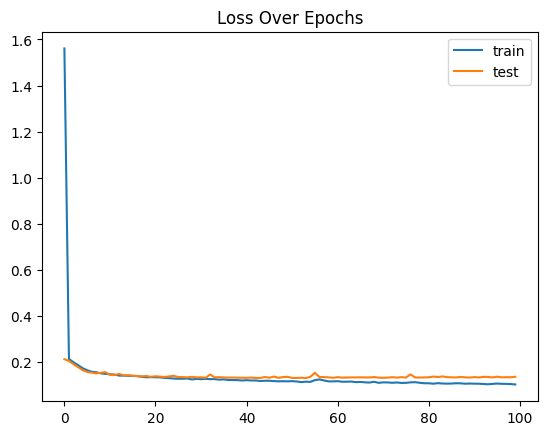

In [37]:
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), test_losses, label='test')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

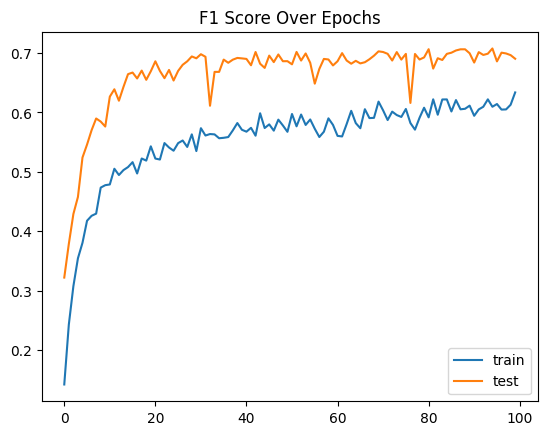

In [38]:
plt.plot(range(epochs), train_f1_scores, label='train')
plt.plot(range(epochs), test_f1_scores, label='test')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.show()

In [39]:
print(f'Best model achieved at epoch {np.argmax(test_f1_scores)} with F1 score {np.max(test_f1_scores)}')

Best model achieved at epoch 94 with F1 score 0.707740916271722


# Xgboost
### Dataset

In [ ]:
train_set = BaselineDataset()
test_set = BaselineDataset(path=TEST_PATH)

In [41]:
dtrain = xgb.DMatrix(torch.vstack(train_set.data).numpy(), label=train_set.target)
dtest = xgb.DMatrix(torch.vstack(test_set.data).numpy(), label=test_set.target)

### Model & Hyperparameter Tuning

In [70]:
def f1_calculator(pred, data):
    labels = data.get_label()
    pred = pred > 0.5
    return 'f1', f1_score(labels, pred)


def objective_2(trial):
    evals_results = {}
    param = {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'verbosity': 0}
    param['max_depth'] = trial.suggest_int('max_depth', 3, 10)
    param['eta'] = trial.suggest_float('eta', 0, 1e-1)
    param['gamma'] = trial.suggest_float('gamma', 0, 1e-1)
    param['alpha'] = trial.suggest_float('alpha', 0, 1e-1)
    param['lambda'] = trial.suggest_float('lambda', 0, 1e-1)
    param['subsamplea'] = trial.suggest_float('subsample', 0.5, 1)
    param['sampling_method'] = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    num_rounds = 100
    bst = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'test')], feval=f1_calculator, verbose_eval=False, evals_result=evals_results)
    return evals_results['test']['f1'][-1]


study = optuna.create_study(direction='maximize')
study.optimize(objective_2, n_trials=200)

[I 2023-04-27 12:37:08,014] A new study created in memory with name: no-name-6991b5c1-a06c-4294-8ffa-ec66497484f8
[I 2023-04-27 12:37:08,797] Trial 0 finished with value: 0.672978 and parameters: {'max_depth': 6, 'eta': 0.019398710310971956, 'gamma': 0.0278367935408146, 'alpha': 0.06437350628872666, 'lambda': 0.04640652003940772, 'subsample': 0.6098177641574065, 'sampling_method': 'uniform'}. Best is trial 0 with value: 0.672978.
[I 2023-04-27 12:37:09,310] Trial 1 finished with value: 0.659686 and parameters: {'max_depth': 3, 'eta': 0.02734503742396819, 'gamma': 0.00329052174322656, 'alpha': 0.09260136046301892, 'lambda': 0.04890020437861617, 'subsample': 0.6942280156792708, 'sampling_method': 'gradient_based'}. Best is trial 0 with value: 0.672978.
[I 2023-04-27 12:37:09,900] Trial 2 finished with value: 0.71346 and parameters: {'max_depth': 5, 'eta': 0.08302025409399177, 'gamma': 0.07458985062194029, 'alpha': 0.06450998980283751, 'lambda': 0.07141379523561849, 'subsample': 0.6238946

In [71]:
study.best_params

{'max_depth': 6,
 'eta': 0.09081514003358984,
 'gamma': 0.06642929982914873,
 'alpha': 0.0940319005665157,
 'lambda': 0.03697634500529317,
 'subsample': 0.6137676048529289,
 'sampling_method': 'gradient_based'}

In [84]:
evals_results = {}
param = {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'verbosity': 0}
param['max_depth'] = study.best_params['max_depth']
param['eta'] = study.best_params['eta']
param['gamma'] = study.best_params['gamma']
param['alpha'] = study.best_params['alpha']
param['lambda'] = study.best_params['lambda']
param['subsamplea'] = study.best_params['subsample']
param['sampling_method'] = study.best_params['sampling_method']
num_rounds = 100
bst = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=False, feval=f1_calculator, evals_result=evals_results)

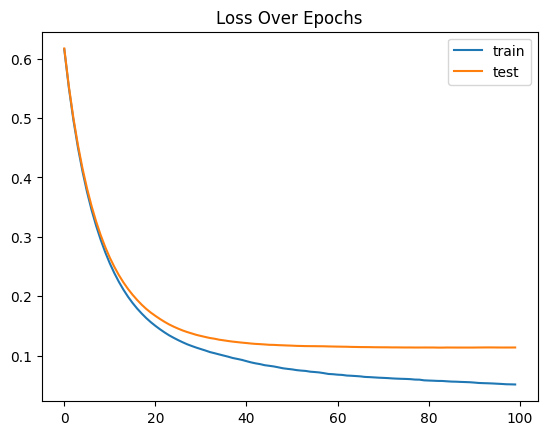

In [85]:
plt.plot(range(num_rounds), evals_results['train']['logloss'], label='train')
plt.plot(range(num_rounds), evals_results['test']['logloss'], label='test')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

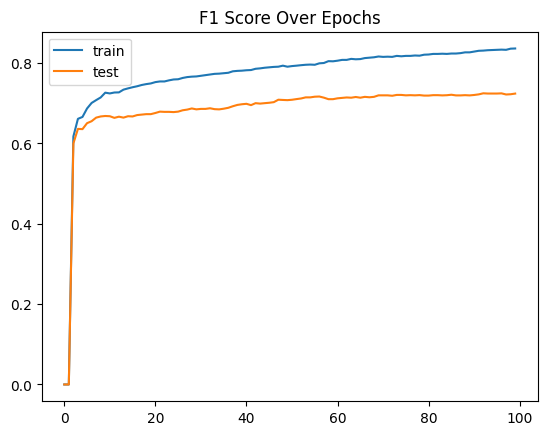

In [86]:
plt.plot(range(num_rounds), evals_results['train']['f1'], label='train')
plt.plot(range(num_rounds), evals_results['test']['f1'], label='test')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.show()

In [87]:
preds = [1 if item > 0.5 else 0 for item in bst.predict(dtest)]
f1_score(test_set.target, preds)

0.7335968379446641

In [88]:
bst.save_model('xgb.model')

# LSTM
### Dataset

In [248]:
class LSTMDataset(Dataset):
    def __init__(self, path=TRAIN_PATH, pad_to=400, pad=True, pad_value=0):
        self.data = []
        self.targets = []
        for file in os.listdir(path):
            df = pd.read_csv(os.path.join(path, file), sep='|')
            sepsis_index = df[df['SepsisLabel'] == 1].first_valid_index()
            df = df.drop('SepsisLabel', axis=1)
            if sepsis_index is not None:
                df = df.iloc[:sepsis_index+1]
                self.targets.append(1)
            else:
                self.targets.append(0)
            df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
            df['time'] = df.index + 1
            data = torch.tensor(df.values, dtype=torch.float32)
            self.data.append(data)
            if pad:
                self.data[-1] = nn.functional.pad(self.data[-1], (0, 0, 0, pad_to - self.data[-1].shape[0]), value=pad_value)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [115]:
lstm_train_dataset = LSTMDataset()
lstm_test_dataset = LSTMDataset(path=TEST_PATH)
lstm_train_dataloader = DataLoader(lstm_train_dataset, batch_size=32, shuffle=True)
lstm_test_dataloader = DataLoader(lstm_test_dataset, batch_size=32, shuffle=True)

In [152]:
lstm_train_dataset2 = LSTMDataset(pad=False)
lstm_test_dataset2 = LSTMDataset(path=TEST_PATH, pad=False)
lstm_train_dataloader2 = DataLoader(lstm_train_dataset, batch_size=1, shuffle=True)
lstm_test_dataloader2 = DataLoader(lstm_test_dataset, batch_size=1, shuffle=True)

In [249]:
lstm_train_dataset3 = LSTMDataset(pad=False)
lstm_test_dataset3 = LSTMDataset(path=TEST_PATH, pad=False)
lstm_train_dataloader3 = DataLoader(lstm_train_dataset, batch_size=32, shuffle=True)
lstm_test_dataloader3 = DataLoader(lstm_test_dataset, batch_size=32, shuffle=True)

### Model

In [260]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size=40, in_channels=400, out_channels=40, hidden_size=128, num_layers=2, lstm_dropout=0.1, fc_dropout=0.1, bidirectional=True, conv_dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.maxpool = nn.MaxPool1d(4)
        self.conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, 3, padding=1), self.maxpool, nn.ReLU(), nn.Dropout(conv_dropout))
        self.lstm = nn.LSTM(int(embedding_size/4), hidden_size, num_layers, dropout=lstm_dropout, batch_first=True, bidirectional=bidirectional)
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(out_channels*(int(2*hidden_size) if bidirectional else int(hidden_size)), 2)

    def forward(self, x):
        out = self.conv(x)
        out, _ = self.lstm(out)
        out = self.fc_dropout(out)
        out = self.fc(out.reshape(x.shape[0], -1))
        return out

In [264]:
def lstm_objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lstm_dropout = trial.suggest_float('lstm_dropout', 0, 0.5)
    fc_dropout = trial.suggest_float('fc_dropout', 0, 0.5)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    conv_dropout = trial.suggest_float('conv_dropout', 0, 0.5)
    out_channels = trial.suggest_int('out_channels', 1, 40)
    lr = trial.suggest_float('lr', 1e-4, 1e-1)
    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, lstm_dropout=lstm_dropout, fc_dropout=fc_dropout, bidirectional=bidirectional, conv_dropout=conv_dropout, out_channels=out_channels)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 10
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, model, lstm_train_dataloader3, lstm_test_dataloader3, epochs=num_epochs, save_best=False)
    return max(test_f1_scores)

study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(lstm_objective, n_trials=200)

[I 2023-05-01 13:27:01,885] A new study created in memory with name: no-name-842555f8-1a0d-4af0-8bd8-135e46c45dc5


Epoch: 1 Train Loss: 0.40823551415047404 Test Loss: 0.4914904064934004
Epoch: 2 Train Loss: 0.3809345145036641 Test Loss: 0.2725357453282268
Epoch: 3 Train Loss: 0.3606152299471454 Test Loss: 0.2817902638318059
Epoch: 4 Train Loss: 0.34913200582235293 Test Loss: 0.3586042225717927
Epoch: 5 Train Loss: 0.35290566140618174 Test Loss: 0.26980303098170905
Epoch: 6 Train Loss: 0.33707730998089536 Test Loss: 0.2723569692657017
Epoch: 7 Train Loss: 0.36083916259985416 Test Loss: 0.4884528692145222
Epoch: 8 Train Loss: 0.34493158525236794 Test Loss: 0.3023095055283925
Epoch: 9 Train Loss: 0.3229890532143414 Test Loss: 0.2718473630020032


[I 2023-05-01 13:28:16,905] Trial 0 finished with value: 0.0 and parameters: {'hidden_size': 130, 'num_layers': 3, 'lstm_dropout': 0.38786694720775733, 'fc_dropout': 0.32294447823078487, 'bidirectional': True, 'conv_dropout': 0.11136091475839233, 'out_channels': 7, 'lr': 0.026899494160586}. Best is trial 0 with value: 0.0.


Epoch: 10 Train Loss: 0.3543047983849887 Test Loss: 0.2650885775732918
Epoch: 1 Train Loss: 4.939631567440793 Test Loss: 4.708147100747203
Epoch: 2 Train Loss: 1.6919201137397486 Test Loss: 0.5401809790576207
Epoch: 3 Train Loss: 0.7090450379818758 Test Loss: 0.5009706859588816
Epoch: 4 Train Loss: 0.42119719973656977 Test Loss: 0.3391796201556778
Epoch: 5 Train Loss: 0.31968295657152773 Test Loss: 0.24003794243017706
Epoch: 6 Train Loss: 0.245183362069726 Test Loss: 0.23848140065948042
Epoch: 7 Train Loss: 0.23981891162991523 Test Loss: 0.23813067902676976
Epoch: 8 Train Loss: 0.24770655983686446 Test Loss: 0.2569653448491051
Epoch: 9 Train Loss: 0.264802092140913 Test Loss: 0.2587497460480315


[I 2023-05-01 13:29:17,323] Trial 1 finished with value: 0.48195121951219505 and parameters: {'hidden_size': 114, 'num_layers': 3, 'lstm_dropout': 0.4671902374058449, 'fc_dropout': 0.19823765230877982, 'bidirectional': False, 'conv_dropout': 0.4264783017261763, 'out_channels': 32, 'lr': 0.0944706851035895}. Best is trial 1 with value: 0.48195121951219505.


Epoch: 10 Train Loss: 0.26161769689917563 Test Loss: 0.24835049945373125
Epoch: 1 Train Loss: 3.0868704090989243 Test Loss: 1.2150234831050706
Epoch: 2 Train Loss: 1.8924855629310242 Test Loss: 1.3789579091361537
Epoch: 3 Train Loss: 1.8648176345251515 Test Loss: 1.4271603352345599
Epoch: 4 Train Loss: 1.798691596954213 Test Loss: 1.1881072010856848
Epoch: 5 Train Loss: 1.775045576238282 Test Loss: 2.0824768758429504
Epoch: 6 Train Loss: 1.627734329857097 Test Loss: 0.6734685539810981
Epoch: 7 Train Loss: 1.6104831101080326 Test Loss: 0.901650518558404
Epoch: 8 Train Loss: 1.6544653149071882 Test Loss: 1.592300504922105
Epoch: 9 Train Loss: 1.3862123281143923 Test Loss: 1.8524769095186226


[I 2023-05-01 13:30:44,160] Trial 2 finished with value: 0.38047138047138046 and parameters: {'hidden_size': 205, 'num_layers': 3, 'lstm_dropout': 0.3259132593893946, 'fc_dropout': 0.4331696469110528, 'bidirectional': False, 'conv_dropout': 0.06616043655891479, 'out_channels': 26, 'lr': 0.059598793430451824}. Best is trial 1 with value: 0.48195121951219505.


Epoch: 10 Train Loss: 1.464762717242214 Test Loss: 1.2025780774914798
Epoch: 1 Train Loss: 1.6411326428576292 Test Loss: 0.913228414738521
Epoch: 2 Train Loss: 1.1315820117917705 Test Loss: 0.7477426508010543
Epoch: 3 Train Loss: 1.305202123776638 Test Loss: 0.485616859054885
Epoch: 4 Train Loss: 1.369129712083663 Test Loss: 0.7810256108665801
Epoch: 5 Train Loss: 1.1100608561681138 Test Loss: 0.49010798289476276
Epoch: 6 Train Loss: 0.9439887441728457 Test Loss: 0.7366935152820159
Epoch: 7 Train Loss: 1.3470321603673925 Test Loss: 0.6315055370327602
Epoch: 8 Train Loss: 1.2405790479746264 Test Loss: 1.1717992835673081
Epoch: 9 Train Loss: 1.0044318713222855 Test Loss: 0.6645784144529318


[I 2023-05-01 13:31:50,560] Trial 3 finished with value: 0.611353711790393 and parameters: {'hidden_size': 161, 'num_layers': 1, 'lstm_dropout': 0.4641082951459673, 'fc_dropout': 0.12670908493472344, 'bidirectional': True, 'conv_dropout': 0.17913477906009612, 'out_channels': 9, 'lr': 0.04837093308798692}. Best is trial 3 with value: 0.611353711790393.


Epoch: 10 Train Loss: 1.030796121084132 Test Loss: 1.3281773799361127
Epoch: 1 Train Loss: 1.888666980092723 Test Loss: 1.3736253756695473
Epoch: 2 Train Loss: 2.0790212693229173 Test Loss: 1.0015395884506237
Epoch: 3 Train Loss: 1.8251407792630496 Test Loss: 2.7906212463927345
Epoch: 4 Train Loss: 2.1772257040516876 Test Loss: 6.177531042038061
Epoch: 5 Train Loss: 1.995579596335549 Test Loss: 0.4757317286873677
Epoch: 6 Train Loss: 1.7619687395020789 Test Loss: 1.0789211504353369
Epoch: 7 Train Loss: 1.5633760454926473 Test Loss: 2.4860245244571577
Epoch: 8 Train Loss: 1.3497380012497557 Test Loss: 0.8084017636442938
Epoch: 9 Train Loss: 1.6045955937874732 Test Loss: 0.3359259317499606


[I 2023-05-01 13:33:16,005] Trial 4 finished with value: 0.38012958963282933 and parameters: {'hidden_size': 172, 'num_layers': 3, 'lstm_dropout': 0.3933789259592418, 'fc_dropout': 0.14816693395755726, 'bidirectional': False, 'conv_dropout': 0.37659198342109224, 'out_channels': 11, 'lr': 0.09200191538985045}. Best is trial 3 with value: 0.611353711790393.


Epoch: 10 Train Loss: 1.1923809905618479 Test Loss: 0.3256669938162612
Epoch: 1 Train Loss: 2.2868886216537674 Test Loss: 0.7044061877776014
Epoch: 2 Train Loss: 0.8799415400476922 Test Loss: 0.4838709694927725
Epoch: 3 Train Loss: 0.6559246412787088 Test Loss: 0.2768884574006588
Epoch: 4 Train Loss: 0.4508908177866134 Test Loss: 0.2641279083340408
Epoch: 5 Train Loss: 0.23095789457689972 Test Loss: 0.21205570908209767
Epoch: 6 Train Loss: 0.19856405499577523 Test Loss: 0.1767048465486723
Epoch: 7 Train Loss: 0.1882794599324465 Test Loss: 0.22479199815672427
Epoch: 8 Train Loss: 0.18720782595872879 Test Loss: 0.17268335395537246
Epoch: 9 Train Loss: 0.2158656439445913 Test Loss: 0.17473855130850507


[I 2023-05-01 13:34:14,547] Trial 5 finished with value: 0.5804066543438078 and parameters: {'hidden_size': 201, 'num_layers': 2, 'lstm_dropout': 0.35610750699161037, 'fc_dropout': 0.43115585149967245, 'bidirectional': False, 'conv_dropout': 0.3716417750363996, 'out_channels': 25, 'lr': 0.0517015912654446}. Best is trial 3 with value: 0.611353711790393.


Epoch: 10 Train Loss: 0.20224596108272672 Test Loss: 0.1905334817406278
Epoch: 1 Train Loss: 2.16378701760259 Test Loss: 3.4352662233879774
Epoch: 2 Train Loss: 2.276975475774829 Test Loss: 2.0707920272551905
Epoch: 3 Train Loss: 1.4784544657344776 Test Loss: 0.9491851468592384
Epoch: 4 Train Loss: 1.6925020121732974 Test Loss: 0.575648312821606
Epoch: 5 Train Loss: 1.5946991081652881 Test Loss: 0.39595890382133514
Epoch: 6 Train Loss: 1.0697379359157166 Test Loss: 0.8756981793873828
Epoch: 7 Train Loss: 1.077877666633939 Test Loss: 1.1735935270308206
Epoch: 8 Train Loss: 0.8877216298877487 Test Loss: 0.41697635448631865
Epoch: 9 Train Loss: 0.9578825549559434 Test Loss: 1.4090784347784482


[I 2023-05-01 13:35:32,681] Trial 6 finished with value: 0.5157232704402516 and parameters: {'hidden_size': 157, 'num_layers': 2, 'lstm_dropout': 0.3546881234812366, 'fc_dropout': 0.4769575415789662, 'bidirectional': False, 'conv_dropout': 0.47076410349798936, 'out_channels': 21, 'lr': 0.0687679470527466}. Best is trial 3 with value: 0.611353711790393.


Epoch: 10 Train Loss: 0.9932765719973476 Test Loss: 0.6667124438110061
Epoch: 1 Train Loss: 0.6101307701831522 Test Loss: 0.39880341722678037
Epoch: 2 Train Loss: 0.5717068348929641 Test Loss: 0.5271645956122266
Epoch: 3 Train Loss: 0.6309630478403202 Test Loss: 0.4408010646315053
Epoch: 4 Train Loss: 0.7103602639501212 Test Loss: 0.4876294848105526
Epoch: 5 Train Loss: 0.7342725972046301 Test Loss: 0.7137862085839792
Epoch: 6 Train Loss: 0.6888874030669367 Test Loss: 0.4967932555672234
Epoch: 7 Train Loss: 0.857374742641523 Test Loss: 0.5532785505622905
Epoch: 8 Train Loss: 0.9082585032376334 Test Loss: 0.47368637165699057
Epoch: 9 Train Loss: 0.8254674056799085 Test Loss: 0.38054298866463154


[I 2023-05-01 13:36:37,398] Trial 7 finished with value: 0.6569005397070161 and parameters: {'hidden_size': 234, 'num_layers': 1, 'lstm_dropout': 0.36288005256481953, 'fc_dropout': 0.3547044517390982, 'bidirectional': True, 'conv_dropout': 0.22933337278863847, 'out_channels': 32, 'lr': 0.011935494336341699}. Best is trial 7 with value: 0.6569005397070161.


Epoch: 10 Train Loss: 0.7848232138604969 Test Loss: 0.42330833816359315
Epoch: 1 Train Loss: 0.8202360094875774 Test Loss: 0.3006380583111646
Epoch: 2 Train Loss: 0.6310660992550066 Test Loss: 0.6651358893942356
Epoch: 3 Train Loss: 0.8863663777242615 Test Loss: 0.3486400906706211
Epoch: 4 Train Loss: 0.5559203247306996 Test Loss: 0.7358680390783713
Epoch: 5 Train Loss: 0.5120208473675336 Test Loss: 0.495406528050161
Epoch: 6 Train Loss: 0.6419409341438413 Test Loss: 0.6585195454739582
Epoch: 7 Train Loss: 0.6272385196669802 Test Loss: 0.5425545034941046
Epoch: 8 Train Loss: 0.5980023082666208 Test Loss: 0.4384377077192813
Epoch: 9 Train Loss: 0.5228548488866143 Test Loss: 0.5889251991404172


[I 2023-05-01 13:37:33,492] Trial 8 finished with value: 0.6412593206296604 and parameters: {'hidden_size': 94, 'num_layers': 1, 'lstm_dropout': 0.2524665311816659, 'fc_dropout': 0.22496061426618114, 'bidirectional': False, 'conv_dropout': 0.1221302523626655, 'out_channels': 39, 'lr': 0.03305217471229315}. Best is trial 7 with value: 0.6569005397070161.


Epoch: 10 Train Loss: 0.5237698559861271 Test Loss: 0.30663624647473836
Epoch: 1 Train Loss: 7.302760675881841 Test Loss: 5.024832944138743
Epoch: 2 Train Loss: 7.708014297936036 Test Loss: 9.608690572622866
Epoch: 3 Train Loss: 8.067231862475529 Test Loss: 5.681612464947442
Epoch: 4 Train Loss: 7.878426304490712 Test Loss: 9.54076457404481
Epoch: 5 Train Loss: 7.772294423027103 Test Loss: 3.3260328602105282
Epoch: 6 Train Loss: 8.997661643976695 Test Loss: 9.417903434735136
Epoch: 7 Train Loss: 8.535761167094725 Test Loss: 5.152523007255773
Epoch: 8 Train Loss: 7.281274451153929 Test Loss: 8.555549169119935
Epoch: 9 Train Loss: 8.710979092512279 Test Loss: 4.205019459784923


[I 2023-05-01 13:38:43,575] Trial 9 finished with value: 0.5637065637065636 and parameters: {'hidden_size': 210, 'num_layers': 2, 'lstm_dropout': 0.18953210582899943, 'fc_dropout': 0.4798303692862227, 'bidirectional': False, 'conv_dropout': 0.2162074660727032, 'out_channels': 35, 'lr': 0.065671072227356}. Best is trial 7 with value: 0.6569005397070161.


Epoch: 10 Train Loss: 6.935195488879382 Test Loss: 2.626475264065153
Epoch: 1 Train Loss: 0.21213193262681598 Test Loss: 0.19061496884922108
Epoch: 2 Train Loss: 0.18408298959592356 Test Loss: 0.16265138066388643
Epoch: 3 Train Loss: 0.18468421629266812 Test Loss: 0.18751956883389442
Epoch: 4 Train Loss: 0.19701327529666013 Test Loss: 0.2539143907373954
Epoch: 5 Train Loss: 0.19593130489122124 Test Loss: 0.22306436469433263
Epoch: 6 Train Loss: 0.20689965382031833 Test Loss: 0.1587951641273908
Epoch: 7 Train Loss: 0.18619082821141927 Test Loss: 0.1592865938427873
Epoch: 8 Train Loss: 0.21149713233032708 Test Loss: 0.1976605097111612
Epoch: 9 Train Loss: 0.19797521514580585 Test Loss: 0.2083415211187289


[I 2023-05-01 13:39:42,441] Trial 10 finished with value: 0.6746987951807228 and parameters: {'hidden_size': 251, 'num_layers': 1, 'lstm_dropout': 0.02178751445165944, 'fc_dropout': 0.06364165583418219, 'bidirectional': True, 'conv_dropout': 0.011419334232821404, 'out_channels': 16, 'lr': 0.005950799413117747}. Best is trial 10 with value: 0.6746987951807228.


Epoch: 10 Train Loss: 0.20351469887085258 Test Loss: 0.25576308022222344
Epoch: 1 Train Loss: 0.18230894694961608 Test Loss: 0.16812601113192047
Epoch: 2 Train Loss: 0.17875450203469953 Test Loss: 0.16020570953671162
Epoch: 3 Train Loss: 0.17941480057677253 Test Loss: 0.15547773354469588
Epoch: 4 Train Loss: 0.17343545610110742 Test Loss: 0.19600177903662616
Epoch: 5 Train Loss: 0.17661169425747358 Test Loss: 0.19595116415706734
Epoch: 6 Train Loss: 0.1756007564784959 Test Loss: 0.20882853869156848
Epoch: 7 Train Loss: 0.1656415808876045 Test Loss: 0.2306511460962637
Epoch: 8 Train Loss: 0.16566558357793837 Test Loss: 0.15562914025645477
Epoch: 9 Train Loss: 0.17979044071878306 Test Loss: 0.22027110905883412


[I 2023-05-01 13:40:42,056] Trial 11 finished with value: 0.6779661016949153 and parameters: {'hidden_size': 255, 'num_layers': 1, 'lstm_dropout': 0.025389922354184635, 'fc_dropout': 0.002021037109234257, 'bidirectional': True, 'conv_dropout': 0.006780052614223209, 'out_channels': 16, 'lr': 0.004274849310018206}. Best is trial 11 with value: 0.6779661016949153.


Epoch: 10 Train Loss: 0.18703062625019956 Test Loss: 0.19691912913561083
Epoch: 1 Train Loss: 0.1549348551299423 Test Loss: 0.15650506938150088
Epoch: 2 Train Loss: 0.13998879936113953 Test Loss: 0.13698813244224356
Epoch: 3 Train Loss: 0.13700188596695662 Test Loss: 0.1397647591956412
Epoch: 4 Train Loss: 0.135134783064574 Test Loss: 0.1441618063793586
Epoch: 5 Train Loss: 0.13926887721568346 Test Loss: 0.13845477253793717
Epoch: 6 Train Loss: 0.13318847493305802 Test Loss: 0.1370654985749017
Epoch: 7 Train Loss: 0.13281043719649316 Test Loss: 0.1409928154664489
Epoch: 8 Train Loss: 0.13391102507710456 Test Loss: 0.14933276765744763
Epoch: 9 Train Loss: 0.13228823126107453 Test Loss: 0.14499243069142578


[I 2023-05-01 13:41:34,878] Trial 12 finished with value: 0.6994535519125684 and parameters: {'hidden_size': 38, 'num_layers': 1, 'lstm_dropout': 0.0156540989256981, 'fc_dropout': 0.015443880742001023, 'bidirectional': True, 'conv_dropout': 0.0006198405599536164, 'out_channels': 15, 'lr': 0.0019207667021480714}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.13382789004892112 Test Loss: 0.13743149414777564
Epoch: 1 Train Loss: 0.15934477254897356 Test Loss: 0.14703654147351322
Epoch: 2 Train Loss: 0.1481441113449633 Test Loss: 0.15194961833901488
Epoch: 3 Train Loss: 0.1484869803082198 Test Loss: 0.1416875778878935
Epoch: 4 Train Loss: 0.14223739415183664 Test Loss: 0.1530795452354577
Epoch: 5 Train Loss: 0.1401316632753238 Test Loss: 0.14006029312519697
Epoch: 6 Train Loss: 0.13791299499571325 Test Loss: 0.14185836901977517
Epoch: 7 Train Loss: 0.13959914285093547 Test Loss: 0.15674676002559665
Epoch: 8 Train Loss: 0.13995878200232983 Test Loss: 0.14341366917085344
Epoch: 9 Train Loss: 0.13813637177348137 Test Loss: 0.16180715366555287


[I 2023-05-01 13:42:32,077] Trial 13 finished with value: 0.6842948717948718 and parameters: {'hidden_size': 48, 'num_layers': 1, 'lstm_dropout': 0.013772617993286277, 'fc_dropout': 0.007577376985890897, 'bidirectional': True, 'conv_dropout': 0.0021024104088941597, 'out_channels': 16, 'lr': 0.002023879705761149}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.13887228516414762 Test Loss: 0.1546752084531604
Epoch: 1 Train Loss: 0.1574546200558543 Test Loss: 0.14816321311191247
Epoch: 2 Train Loss: 0.14276412536501884 Test Loss: 0.14901252651509767
Epoch: 3 Train Loss: 0.1382831597611308 Test Loss: 0.14741406436212146
Epoch: 4 Train Loss: 0.1386280729562044 Test Loss: 0.14115731375285992
Epoch: 5 Train Loss: 0.13574356535971166 Test Loss: 0.13944539678291962
Epoch: 6 Train Loss: 0.13676294722557067 Test Loss: 0.14052496728198693
Epoch: 7 Train Loss: 0.13591458186805247 Test Loss: 0.13807541576508706
Epoch: 8 Train Loss: 0.13315676214694977 Test Loss: 0.1377936374580565
Epoch: 9 Train Loss: 0.13273635865300895 Test Loss: 0.13860690626449668


[I 2023-05-01 13:43:26,829] Trial 14 finished with value: 0.6874003189792663 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lstm_dropout': 0.07353625915333668, 'fc_dropout': 0.033789563037103884, 'bidirectional': True, 'conv_dropout': 0.06480659090985025, 'out_channels': 4, 'lr': 0.001490850646970063}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.13158396243602039 Test Loss: 0.14047446433966532
Epoch: 1 Train Loss: 0.2108359089627862 Test Loss: 0.18670217076334328
Epoch: 2 Train Loss: 0.18822372756302358 Test Loss: 0.18795705962176332
Epoch: 3 Train Loss: 0.2011060429304838 Test Loss: 0.18965033766703485
Epoch: 4 Train Loss: 0.1826589049398899 Test Loss: 0.18473592112525203
Epoch: 5 Train Loss: 0.18562306242436172 Test Loss: 0.17590370389243093
Epoch: 6 Train Loss: 0.17098976441919803 Test Loss: 0.16224014695983724
Epoch: 7 Train Loss: 0.1767192883297801 Test Loss: 0.16934903855093372
Epoch: 8 Train Loss: 0.1744681117668748 Test Loss: 0.17202877421705678
Epoch: 9 Train Loss: 0.16985154818296433 Test Loss: 0.16537753445581316


[I 2023-05-01 13:44:25,669] Trial 15 finished with value: 0.6698337292161519 and parameters: {'hidden_size': 45, 'num_layers': 2, 'lstm_dropout': 0.08410868989981629, 'fc_dropout': 0.08358074570318087, 'bidirectional': True, 'conv_dropout': 0.08225803456587011, 'out_channels': 1, 'lr': 0.015346356395042261}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1687646396204829 Test Loss: 0.16646484323083974
Epoch: 1 Train Loss: 0.2002316929921508 Test Loss: 0.19993891863348767
Epoch: 2 Train Loss: 0.21109993990920484 Test Loss: 0.3108629118037461
Epoch: 3 Train Loss: 0.20746581734865904 Test Loss: 0.18739447193130992
Epoch: 4 Train Loss: 0.19659336984842085 Test Loss: 0.250260780428569
Epoch: 5 Train Loss: 0.1908262691359967 Test Loss: 0.1783203222452642
Epoch: 6 Train Loss: 0.18939813931509852 Test Loss: 0.20711993596281486
Epoch: 7 Train Loss: 0.18931432042289525 Test Loss: 0.1788002281857375
Epoch: 8 Train Loss: 0.19548709443025292 Test Loss: 0.19126286788191943
Epoch: 9 Train Loss: 0.19055104484856128 Test Loss: 0.16360461631545814


[I 2023-05-01 13:45:20,038] Trial 16 finished with value: 0.6477272727272727 and parameters: {'hidden_size': 74, 'num_layers': 1, 'lstm_dropout': 0.1169378698413977, 'fc_dropout': 0.0611710639563504, 'bidirectional': True, 'conv_dropout': 0.16324373398013808, 'out_channels': 2, 'lr': 0.019275313744957667}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.18498914040252568 Test Loss: 0.1744453061651736
Epoch: 1 Train Loss: 0.15337395413815974 Test Loss: 0.14257362469459495
Epoch: 2 Train Loss: 0.14215372275859117 Test Loss: 0.13994476272346684
Epoch: 3 Train Loss: 0.1375141792833805 Test Loss: 0.1375939335209874
Epoch: 4 Train Loss: 0.1332986144974828 Test Loss: 0.13651275374114322
Epoch: 5 Train Loss: 0.137734771938622 Test Loss: 0.14180195554138753
Epoch: 6 Train Loss: 0.13594603653103113 Test Loss: 0.1539457487135816
Epoch: 7 Train Loss: 0.13365834740102292 Test Loss: 0.13775638301080217
Epoch: 8 Train Loss: 0.13182155602872372 Test Loss: 0.13462342273670072
Epoch: 9 Train Loss: 0.13299501345306636 Test Loss: 0.13902339181556297


[I 2023-05-01 13:46:20,111] Trial 17 finished with value: 0.6949559647718174 and parameters: {'hidden_size': 34, 'num_layers': 2, 'lstm_dropout': 0.09702406491106585, 'fc_dropout': 0.16425257288383516, 'bidirectional': True, 'conv_dropout': 0.05844040636629192, 'out_channels': 6, 'lr': 0.0020038140395254363}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.134507756267488 Test Loss: 0.13531592285361724
Epoch: 1 Train Loss: 0.23304114204347134 Test Loss: 0.1935121005954453
Epoch: 2 Train Loss: 0.19016014986485244 Test Loss: 0.16953128541763218
Epoch: 3 Train Loss: 0.17341846999824048 Test Loss: 0.16467389416175718
Epoch: 4 Train Loss: 0.17585500506162643 Test Loss: 0.1767492772172244
Epoch: 5 Train Loss: 0.1822784347018227 Test Loss: 0.19339873970221408
Epoch: 6 Train Loss: 0.18381804067492485 Test Loss: 0.19051730834518948
Epoch: 7 Train Loss: 0.18817566215880216 Test Loss: 0.18233278057219598
Epoch: 8 Train Loss: 0.17754042514041066 Test Loss: 0.1646473595378593
Epoch: 9 Train Loss: 0.1723793307237327 Test Loss: 0.16515358795706456


[I 2023-05-01 13:46:52,568] Trial 18 finished with value: 0.6053702196908055 and parameters: {'hidden_size': 71, 'num_layers': 2, 'lstm_dropout': 0.1381859536024765, 'fc_dropout': 0.13926879439358683, 'bidirectional': True, 'conv_dropout': 0.2965319573774283, 'out_channels': 13, 'lr': 0.024825281548966505}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1681841777354479 Test Loss: 0.17719998443945528
Epoch: 1 Train Loss: 0.3543801366791129 Test Loss: 0.16553365908110865
Epoch: 2 Train Loss: 0.17155953933298587 Test Loss: 0.17514201486929537
Epoch: 3 Train Loss: 0.1753052459605038 Test Loss: 0.16271486874824515
Epoch: 4 Train Loss: 0.16945379654541612 Test Loss: 0.15965934153110645
Epoch: 5 Train Loss: 0.16810939891077578 Test Loss: 0.19538484145396243
Epoch: 6 Train Loss: 0.1722983610495925 Test Loss: 0.1700110021954813
Epoch: 7 Train Loss: 0.1680628883972764 Test Loss: 0.15975924793142862
Epoch: 8 Train Loss: 0.16705696111768484 Test Loss: 0.16274177894805567
Epoch: 9 Train Loss: 0.1811721507512033 Test Loss: 0.18475455269753077


[I 2023-05-01 13:47:26,128] Trial 19 finished with value: 0.6607717041800644 and parameters: {'hidden_size': 75, 'num_layers': 2, 'lstm_dropout': 0.1676951825444775, 'fc_dropout': 0.18465858960062698, 'bidirectional': True, 'conv_dropout': 0.049392521354280364, 'out_channels': 21, 'lr': 0.03416019862094319}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.18308539181500674 Test Loss: 0.18794999378748214
Epoch: 1 Train Loss: 0.18198697617352008 Test Loss: 0.17019157773389604
Epoch: 2 Train Loss: 0.16623494924753904 Test Loss: 0.16370159842240545
Epoch: 3 Train Loss: 0.16744934900403022 Test Loss: 0.15566151603437461
Epoch: 4 Train Loss: 0.16303833018690347 Test Loss: 0.1604910465730979
Epoch: 5 Train Loss: 0.16359122973233461 Test Loss: 0.15704635239709108
Epoch: 6 Train Loss: 0.16479154160171747 Test Loss: 0.16486197082807844
Epoch: 7 Train Loss: 0.16280891878902912 Test Loss: 0.16674611596063302
Epoch: 8 Train Loss: 0.17464358419552445 Test Loss: 0.17659071071174579
Epoch: 9 Train Loss: 0.18273443838432432 Test Loss: 0.1642601756503978


[I 2023-05-01 13:48:05,582] Trial 20 finished with value: 0.6528866714183891 and parameters: {'hidden_size': 98, 'num_layers': 2, 'lstm_dropout': 0.06302883076182575, 'fc_dropout': 0.2751573917397267, 'bidirectional': True, 'conv_dropout': 0.1376202775865623, 'out_channels': 6, 'lr': 0.012433235393812189}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.18517404569685458 Test Loss: 0.16595767860631117
Epoch: 1 Train Loss: 0.1622943287625909 Test Loss: 0.14475001722943193
Epoch: 2 Train Loss: 0.14349918688833713 Test Loss: 0.14865434957674137
Epoch: 3 Train Loss: 0.14127841406911612 Test Loss: 0.14612847841835727
Epoch: 4 Train Loss: 0.14125151639953257 Test Loss: 0.14646388088671353
Epoch: 5 Train Loss: 0.13895030131042005 Test Loss: 0.14829385432655723
Epoch: 6 Train Loss: 0.13996993922740222 Test Loss: 0.14901044755019605
Epoch: 7 Train Loss: 0.1413951914690435 Test Loss: 0.1477662946749181
Epoch: 8 Train Loss: 0.1402952223956585 Test Loss: 0.1498329987683997
Epoch: 9 Train Loss: 0.1374028864607215 Test Loss: 0.1447578118310664


[I 2023-05-01 13:48:48,602] Trial 21 finished with value: 0.6842948717948718 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lstm_dropout': 0.07361401973280626, 'fc_dropout': 0.038893797141874936, 'bidirectional': True, 'conv_dropout': 0.05606188161541484, 'out_channels': 5, 'lr': 0.0019301944153665618}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.13916745307594539 Test Loss: 0.14409179817409085
Epoch: 1 Train Loss: 0.17241410509869456 Test Loss: 0.16413966448495562
Epoch: 2 Train Loss: 0.16843192177265884 Test Loss: 0.15466408970685433
Epoch: 3 Train Loss: 0.160018782376498 Test Loss: 0.16039992856998414
Epoch: 4 Train Loss: 0.16442226566821336 Test Loss: 0.17252729217947338
Epoch: 5 Train Loss: 0.15791576647311448 Test Loss: 0.16835447780180948
Epoch: 6 Train Loss: 0.1627351623699069 Test Loss: 0.15750545684022074
Epoch: 7 Train Loss: 0.16184559391774236 Test Loss: 0.15796272882138387
Epoch: 8 Train Loss: 0.15545947335958482 Test Loss: 0.1603231908152469
Epoch: 9 Train Loss: 0.1689575245216489 Test Loss: 0.1866404351870568


[I 2023-05-01 13:49:36,078] Trial 22 finished with value: 0.6624305003971406 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lstm_dropout': 0.001779990236578849, 'fc_dropout': 0.11009350852073577, 'bidirectional': True, 'conv_dropout': 0.08477564997670452, 'out_channels': 4, 'lr': 0.008432196710621415}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.17917122770473362 Test Loss: 0.1677672714084244
Epoch: 1 Train Loss: 0.1555060133226216 Test Loss: 0.1481618653542508
Epoch: 2 Train Loss: 0.14262668642625212 Test Loss: 0.15138232444945615
Epoch: 3 Train Loss: 0.14034882673770188 Test Loss: 0.14508523261204315
Epoch: 4 Train Loss: 0.14371752305701374 Test Loss: 0.14478618202629848
Epoch: 5 Train Loss: 0.14184090809077024 Test Loss: 0.1429342782547394
Epoch: 6 Train Loss: 0.13997085151299835 Test Loss: 0.1621794073735349
Epoch: 7 Train Loss: 0.13775026429593562 Test Loss: 0.13834337608073466
Epoch: 8 Train Loss: 0.13613384049236774 Test Loss: 0.14922189156111246
Epoch: 9 Train Loss: 0.13541835074052214 Test Loss: 0.13707898588726125


[I 2023-05-01 13:50:34,110] Trial 23 finished with value: 0.6909667194928685 and parameters: {'hidden_size': 59, 'num_layers': 1, 'lstm_dropout': 0.10259036501449068, 'fc_dropout': 0.09100541993658842, 'bidirectional': True, 'conv_dropout': 0.03700483682891562, 'out_channels': 10, 'lr': 0.0018610891041150337}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.13613420268110932 Test Loss: 0.1551453983961655
Epoch: 1 Train Loss: 0.23226808506902308 Test Loss: 0.1689016265265001
Epoch: 2 Train Loss: 0.15532498068809508 Test Loss: 0.15554010728820444
Epoch: 3 Train Loss: 0.1573794867157936 Test Loss: 0.16276068138643005
Epoch: 4 Train Loss: 0.16382519790530206 Test Loss: 0.16631026477061997
Epoch: 5 Train Loss: 0.16862875594571233 Test Loss: 0.1511955406790534
Epoch: 6 Train Loss: 0.15856989857852458 Test Loss: 0.16044891216812995
Epoch: 7 Train Loss: 0.15519045994877814 Test Loss: 0.152567628110512
Epoch: 8 Train Loss: 0.16336285930792802 Test Loss: 0.1548075652755678
Epoch: 9 Train Loss: 0.15771741430312394 Test Loss: 0.15420081766959007


[I 2023-05-01 13:51:37,369] Trial 24 finished with value: 0.6580436540016168 and parameters: {'hidden_size': 60, 'num_layers': 2, 'lstm_dropout': 0.12175665082643866, 'fc_dropout': 0.0907078737534906, 'bidirectional': True, 'conv_dropout': 0.029896762222109283, 'out_channels': 13, 'lr': 0.017027759776956697}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1555047024704516 Test Loss: 0.16978660524605563
Epoch: 1 Train Loss: 0.16037653522491455 Test Loss: 0.14333037976711133
Epoch: 2 Train Loss: 0.1342346171990037 Test Loss: 0.14351629029614285
Epoch: 3 Train Loss: 0.13131015133708715 Test Loss: 0.1362171651105197
Epoch: 4 Train Loss: 0.1273540177553892 Test Loss: 0.13316146594385941
Epoch: 5 Train Loss: 0.1264521044164896 Test Loss: 0.13448843098700808
Epoch: 6 Train Loss: 0.12443760276436806 Test Loss: 0.13216636175759874
Epoch: 7 Train Loss: 0.12212677834779025 Test Loss: 0.13410599198870765
Epoch: 8 Train Loss: 0.12107050960958005 Test Loss: 0.1309479638255728
Epoch: 9 Train Loss: 0.12015108617991209 Test Loss: 0.13287217326509876


[I 2023-05-01 13:52:35,098] Trial 25 finished with value: 0.6976744186046512 and parameters: {'hidden_size': 90, 'num_layers': 1, 'lstm_dropout': 0.04393704817335646, 'fc_dropout': 0.16377081996255635, 'bidirectional': True, 'conv_dropout': 0.031701266087766786, 'out_channels': 9, 'lr': 0.00017735853759312222}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.11838299439549446 Test Loss: 0.13112691475060612
Epoch: 1 Train Loss: 0.20514861845783888 Test Loss: 0.17499549230471395
Epoch: 2 Train Loss: 0.16525098844170572 Test Loss: 0.15808478210823604
Epoch: 3 Train Loss: 0.15726280042231083 Test Loss: 0.1518208554591805
Epoch: 4 Train Loss: 0.15667942016869785 Test Loss: 0.20734460061020293
Epoch: 5 Train Loss: 0.15550949306823314 Test Loss: 0.15148482020623005
Epoch: 6 Train Loss: 0.1549940683722496 Test Loss: 0.15423647650538352
Epoch: 7 Train Loss: 0.15833023422062398 Test Loss: 0.15110002537838185
Epoch: 8 Train Loss: 0.16376533172130583 Test Loss: 0.16925450409063325
Epoch: 9 Train Loss: 0.15873449837118386 Test Loss: 0.15965083669930602


[I 2023-05-01 13:53:33,060] Trial 26 finished with value: 0.6578073089700998 and parameters: {'hidden_size': 94, 'num_layers': 2, 'lstm_dropout': 0.0392998971760519, 'fc_dropout': 0.18505900219917282, 'bidirectional': True, 'conv_dropout': 0.10108643759729424, 'out_channels': 18, 'lr': 0.011062047868851359}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1619988633595407 Test Loss: 0.1620215459045368
Epoch: 1 Train Loss: 0.2843093464098376 Test Loss: 0.2715746620440292
Epoch: 2 Train Loss: 0.23289980241255834 Test Loss: 0.17151879418058136
Epoch: 3 Train Loss: 0.22080751858088188 Test Loss: 0.17479090485126733
Epoch: 4 Train Loss: 0.23462720531416126 Test Loss: 0.23792244739884053
Epoch: 5 Train Loss: 0.24523922826882188 Test Loss: 0.17526421867334804
Epoch: 6 Train Loss: 0.3213815313277748 Test Loss: 0.27638434669889583
Epoch: 7 Train Loss: 0.30778303762031717 Test Loss: 0.3167946060331681
Epoch: 8 Train Loss: 0.27060573757505046 Test Loss: 0.22484013758757457
Epoch: 9 Train Loss: 0.2855872926875105 Test Loss: 0.21999226195943028


[I 2023-05-01 13:54:26,989] Trial 27 finished with value: 0.6475409836065574 and parameters: {'hidden_size': 117, 'num_layers': 1, 'lstm_dropout': 0.04934973028847657, 'fc_dropout': 0.15949401802561725, 'bidirectional': True, 'conv_dropout': 0.03463671313170123, 'out_channels': 9, 'lr': 0.020529457132571597}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.27170430781822213 Test Loss: 0.3462102321092634
Epoch: 1 Train Loss: 0.19195036522746087 Test Loss: 0.15214618554297157
Epoch: 2 Train Loss: 0.1619911053493619 Test Loss: 0.15595160885312306
Epoch: 3 Train Loss: 0.155116413359344 Test Loss: 0.16033981361399635
Epoch: 4 Train Loss: 0.16056927675902843 Test Loss: 0.17610574747248295
Epoch: 5 Train Loss: 0.15227427434623242 Test Loss: 0.15161523435371943
Epoch: 6 Train Loss: 0.1536664979211986 Test Loss: 0.15754613251136707
Epoch: 7 Train Loss: 0.15355307165831328 Test Loss: 0.1505482008281988
Epoch: 8 Train Loss: 0.1532596119761467 Test Loss: 0.15972445766551616
Epoch: 9 Train Loss: 0.1520890184916556 Test Loss: 0.14668995086639264


[I 2023-05-01 13:55:35,927] Trial 28 finished with value: 0.6612772837510106 and parameters: {'hidden_size': 80, 'num_layers': 2, 'lstm_dropout': 0.043680968310254246, 'fc_dropout': 0.11437545654534942, 'bidirectional': True, 'conv_dropout': 0.001728140187536982, 'out_channels': 14, 'lr': 0.009964447979556318}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1478363943338394 Test Loss: 0.15345843145236993
Epoch: 1 Train Loss: 0.344119755256176 Test Loss: 0.21060623110126192
Epoch: 2 Train Loss: 0.19318593366444112 Test Loss: 0.18234279154302974
Epoch: 3 Train Loss: 0.19499562630951406 Test Loss: 0.21060366004693526
Epoch: 4 Train Loss: 0.18914278436601162 Test Loss: 0.16992997221601086
Epoch: 5 Train Loss: 0.20692057226337493 Test Loss: 0.1986530192208271
Epoch: 6 Train Loss: 0.21908485306408257 Test Loss: 0.29787888077977365
Epoch: 7 Train Loss: 0.20910083542969077 Test Loss: 0.1693293546644834
Epoch: 8 Train Loss: 0.4289625216339729 Test Loss: 0.8905585092181966
Epoch: 9 Train Loss: 0.39840362411857494 Test Loss: 0.2018488840744518


[I 2023-05-01 13:57:04,807] Trial 29 finished with value: 0.6015424164524421 and parameters: {'hidden_size': 137, 'num_layers': 3, 'lstm_dropout': 0.005367179039830772, 'fc_dropout': 0.2396011426081875, 'bidirectional': True, 'conv_dropout': 0.10972639258395542, 'out_channels': 7, 'lr': 0.026810691804693754}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.3323531865359164 Test Loss: 0.3523644979449194
Epoch: 1 Train Loss: 0.227773862802051 Test Loss: 0.17659958949485144
Epoch: 2 Train Loss: 0.16259298351109028 Test Loss: 0.16921439793663093
Epoch: 3 Train Loss: 0.1581154645115137 Test Loss: 0.15986903680089753
Epoch: 4 Train Loss: 0.1575982001900673 Test Loss: 0.15679583023079097
Epoch: 5 Train Loss: 0.15884768582805991 Test Loss: 0.16305857774512933
Epoch: 6 Train Loss: 0.15816543142795564 Test Loss: 0.16650730337554845
Epoch: 7 Train Loss: 0.15735788740664722 Test Loss: 0.16579738013541545
Epoch: 8 Train Loss: 0.15997624900639057 Test Loss: 0.16509261935616074
Epoch: 9 Train Loss: 0.15857051608115436 Test Loss: 0.1586714860099478


[I 2023-05-01 13:58:12,407] Trial 30 finished with value: 0.6577851790174855 and parameters: {'hidden_size': 52, 'num_layers': 3, 'lstm_dropout': 0.09382780131983451, 'fc_dropout': 0.27461571870455126, 'bidirectional': True, 'conv_dropout': 0.13525626689423934, 'out_channels': 25, 'lr': 0.02030250656983206}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1564827198565006 Test Loss: 0.1546245374487707
Epoch: 1 Train Loss: 0.15602168253809215 Test Loss: 0.14206390326824814
Epoch: 2 Train Loss: 0.1332245696902275 Test Loss: 0.13809038958134362
Epoch: 3 Train Loss: 0.13099397196993232 Test Loss: 0.13431368259409557
Epoch: 4 Train Loss: 0.12891690012961626 Test Loss: 0.13575455229193828
Epoch: 5 Train Loss: 0.12718666001856327 Test Loss: 0.1316988101175513
Epoch: 6 Train Loss: 0.12502749700844287 Test Loss: 0.1348934386508724
Epoch: 7 Train Loss: 0.12549493409395218 Test Loss: 0.13357633124358548
Epoch: 8 Train Loss: 0.1236436023503542 Test Loss: 0.13311759265252768
Epoch: 9 Train Loss: 0.1229708380356431 Test Loss: 0.13175060071598607


[I 2023-05-01 13:59:15,463] Trial 31 finished with value: 0.6891447368421052 and parameters: {'hidden_size': 66, 'num_layers': 1, 'lstm_dropout': 0.10100800779988583, 'fc_dropout': 0.09204050896358552, 'bidirectional': True, 'conv_dropout': 0.045635185328953706, 'out_channels': 10, 'lr': 0.00045315430658186633}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.12199307271093131 Test Loss: 0.1374501477891264
Epoch: 1 Train Loss: 0.1738129121720791 Test Loss: 0.16862176542137616
Epoch: 2 Train Loss: 0.17456587106771768 Test Loss: 0.1584932251503102
Epoch: 3 Train Loss: 0.16785554580725728 Test Loss: 0.15583965304893807
Epoch: 4 Train Loss: 0.16921217703018337 Test Loss: 0.16402686777979897
Epoch: 5 Train Loss: 0.16678031597696244 Test Loss: 0.14616197811814544
Epoch: 6 Train Loss: 0.16266399093251677 Test Loss: 0.18396314844182624
Epoch: 7 Train Loss: 0.16776230821621138 Test Loss: 0.14923097757985607
Epoch: 8 Train Loss: 0.16218851348347962 Test Loss: 0.15233953181094825
Epoch: 9 Train Loss: 0.15930881267562508 Test Loss: 0.19301585138317184


[I 2023-05-01 13:59:49,949] Trial 32 finished with value: 0.6743993371996685 and parameters: {'hidden_size': 51, 'num_layers': 1, 'lstm_dropout': 0.06467118805300293, 'fc_dropout': 0.14541672117916407, 'bidirectional': True, 'conv_dropout': 0.09109920083531871, 'out_channels': 11, 'lr': 0.0057091963562176905}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.16419418988805265 Test Loss: 0.15795290057127848
Epoch: 1 Train Loss: 0.1542055526316166 Test Loss: 0.1430171345012447
Epoch: 2 Train Loss: 0.13636566203385592 Test Loss: 0.15335871438724927
Epoch: 3 Train Loss: 0.13295421594008802 Test Loss: 0.13942376781885807
Epoch: 4 Train Loss: 0.13048310358971357 Test Loss: 0.13927370055129354
Epoch: 5 Train Loss: 0.1311948342844844 Test Loss: 0.13943203693975847
Epoch: 6 Train Loss: 0.1282271944195032 Test Loss: 0.13577858214906324
Epoch: 7 Train Loss: 0.12483789663761855 Test Loss: 0.13680949624770652
Epoch: 8 Train Loss: 0.1257642529733479 Test Loss: 0.14339750629073134
Epoch: 9 Train Loss: 0.12560457315891982 Test Loss: 0.1350823265318863


[I 2023-05-01 14:00:31,154] Trial 33 finished with value: 0.6959297685554668 and parameters: {'hidden_size': 115, 'num_layers': 1, 'lstm_dropout': 0.1537461110102326, 'fc_dropout': 0.2063138157295346, 'bidirectional': True, 'conv_dropout': 0.034148452529885895, 'out_channels': 8, 'lr': 0.0005297892843404469}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.12469685189574957 Test Loss: 0.13746106410071776
Epoch: 1 Train Loss: 0.2126999075144995 Test Loss: 0.16030079190628216
Epoch: 2 Train Loss: 0.2114743033720646 Test Loss: 0.16792710545582892
Epoch: 3 Train Loss: 0.2028483704881277 Test Loss: 0.40196946716435467
Epoch: 4 Train Loss: 0.19438955009304917 Test Loss: 0.1911142166903296
Epoch: 5 Train Loss: 0.19439159865798428 Test Loss: 0.1719269336829075
Epoch: 6 Train Loss: 0.19463355396166443 Test Loss: 0.17761712640928576
Epoch: 7 Train Loss: 0.2016862755205482 Test Loss: 0.16395575525209355
Epoch: 8 Train Loss: 0.19863856548210607 Test Loss: 0.20006759674213945
Epoch: 9 Train Loss: 0.19733105899179354 Test Loss: 0.21890858873076285


[I 2023-05-01 14:01:10,534] Trial 34 finished with value: 0.6691616766467066 and parameters: {'hidden_size': 111, 'num_layers': 1, 'lstm_dropout': 0.14144613468291306, 'fc_dropout': 0.20896094632081139, 'bidirectional': True, 'conv_dropout': 0.07364057091378429, 'out_channels': 8, 'lr': 0.009986691067990017}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.19272323625697754 Test Loss: 0.16432654898697005
Epoch: 1 Train Loss: 0.20918307926803828 Test Loss: 0.18090134868606592
Epoch: 2 Train Loss: 0.20014348336472176 Test Loss: 0.24462495758510627
Epoch: 3 Train Loss: 0.19373604780621825 Test Loss: 0.17973575031997774
Epoch: 4 Train Loss: 0.18170957976374774 Test Loss: 0.19413878754400216
Epoch: 5 Train Loss: 0.19617508711740375 Test Loss: 0.17666107599441996
Epoch: 6 Train Loss: 0.19504938853271306 Test Loss: 0.22807608728710646
Epoch: 7 Train Loss: 0.19720534320585428 Test Loss: 0.17952971608666612
Epoch: 8 Train Loss: 0.18784811552437022 Test Loss: 0.1694118838412122
Epoch: 9 Train Loss: 0.19051700984332712 Test Loss: 0.16277105094620975


[I 2023-05-01 14:02:02,190] Trial 35 finished with value: 0.6457627118644067 and parameters: {'hidden_size': 123, 'num_layers': 1, 'lstm_dropout': 0.048358382528968215, 'fc_dropout': 0.17309918556440418, 'bidirectional': True, 'conv_dropout': 0.020703337294141585, 'out_channels': 3, 'lr': 0.015679365402680324}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1913643617888447 Test Loss: 0.1854366915101132
Epoch: 1 Train Loss: 0.1737758979521692 Test Loss: 0.17963338702821885
Epoch: 2 Train Loss: 0.15272603137046098 Test Loss: 0.15152480838873897
Epoch: 3 Train Loss: 0.151147291444242 Test Loss: 0.16830600842167012
Epoch: 4 Train Loss: 0.15660405382215978 Test Loss: 0.15884775001579485
Epoch: 5 Train Loss: 0.15212320975363255 Test Loss: 0.1505184762251263
Epoch: 6 Train Loss: 0.14886191010475158 Test Loss: 0.1552265094646726
Epoch: 7 Train Loss: 0.1463175395652652 Test Loss: 0.15662278205501481
Epoch: 8 Train Loss: 0.15036603950411082 Test Loss: 0.15449363175934305
Epoch: 9 Train Loss: 0.14651269116699694 Test Loss: 0.14615092855601455


[I 2023-05-01 14:03:09,804] Trial 36 finished with value: 0.662251655629139 and parameters: {'hidden_size': 88, 'num_layers': 3, 'lstm_dropout': 0.1802868389922722, 'fc_dropout': 0.1932110437780881, 'bidirectional': False, 'conv_dropout': 0.05985133361749816, 'out_channels': 19, 'lr': 0.0072476961639971966}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.14569325554817916 Test Loss: 0.1571910115934837
Epoch: 1 Train Loss: 0.1970832805620972 Test Loss: 0.17367251654462026
Epoch: 2 Train Loss: 0.1868576429558918 Test Loss: 0.17506707738638638
Epoch: 3 Train Loss: 0.18120546695669182 Test Loss: 0.15790523439288712
Epoch: 4 Train Loss: 0.1731945006594062 Test Loss: 0.19336394173057433
Epoch: 5 Train Loss: 0.19769507925638463 Test Loss: 0.2182453697545085
Epoch: 6 Train Loss: 0.18543256268743424 Test Loss: 0.15228616282605706
Epoch: 7 Train Loss: 0.1733182067193091 Test Loss: 0.16791013698465526
Epoch: 8 Train Loss: 0.1682892060637474 Test Loss: 0.1647057223696107
Epoch: 9 Train Loss: 0.16326218674331902 Test Loss: 0.1637550721736476


[I 2023-05-01 14:04:12,174] Trial 37 finished with value: 0.6666666666666667 and parameters: {'hidden_size': 148, 'num_layers': 1, 'lstm_dropout': 0.03373579573953274, 'fc_dropout': 0.13165067953642204, 'bidirectional': True, 'conv_dropout': 0.0291495330846214, 'out_channels': 7, 'lr': 0.007437941014875075}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1722490582536906 Test Loss: 0.15919841202898338
Epoch: 1 Train Loss: 0.1588824094891548 Test Loss: 0.1432076166964139
Epoch: 2 Train Loss: 0.13580520154088735 Test Loss: 0.139025783511444
Epoch: 3 Train Loss: 0.1324023044705391 Test Loss: 0.13817386372020832
Epoch: 4 Train Loss: 0.12917428943067788 Test Loss: 0.13646445179971073
Epoch: 5 Train Loss: 0.1280297268792987 Test Loss: 0.1347113668995972
Epoch: 6 Train Loss: 0.1260992558449507 Test Loss: 0.13202694561272954
Epoch: 7 Train Loss: 0.12454628554433585 Test Loss: 0.1333204482119685
Epoch: 8 Train Loss: 0.12302061172276735 Test Loss: 0.1328632604009427
Epoch: 9 Train Loss: 0.1225674425676465 Test Loss: 0.13114826726361203


[I 2023-05-01 14:05:05,640] Trial 38 finished with value: 0.6883645240032547 and parameters: {'hidden_size': 105, 'num_layers': 1, 'lstm_dropout': 0.08264044742132443, 'fc_dropout': 0.16717029485230334, 'bidirectional': False, 'conv_dropout': 0.10403908418752351, 'out_channels': 12, 'lr': 0.00019486508126606025}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.12176775477081538 Test Loss: 0.1371473244186074
Epoch: 1 Train Loss: 0.2469706747194749 Test Loss: 0.16082975933679378
Epoch: 2 Train Loss: 0.16676292918901892 Test Loss: 0.19715610689397295
Epoch: 3 Train Loss: 0.16258900209739804 Test Loss: 0.1578211436470667
Epoch: 4 Train Loss: 0.16793254348002373 Test Loss: 0.2767241543525988
Epoch: 5 Train Loss: 0.1681974927822128 Test Loss: 0.17873173500574863
Epoch: 6 Train Loss: 0.16095997956749053 Test Loss: 0.16207037633731247
Epoch: 7 Train Loss: 0.1724143814727664 Test Loss: 0.16522490027280282
Epoch: 8 Train Loss: 0.16888462228178977 Test Loss: 0.18952987078851025
Epoch: 9 Train Loss: 0.18292769954018295 Test Loss: 0.16825487299230152


[I 2023-05-01 14:06:53,114] Trial 39 finished with value: 0.6514382402707277 and parameters: {'hidden_size': 182, 'num_layers': 2, 'lstm_dropout': 0.21710266502537426, 'fc_dropout': 0.20824923911428012, 'bidirectional': True, 'conv_dropout': 0.07050073008761225, 'out_channels': 14, 'lr': 0.013480781598933381}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.17415776475407183 Test Loss: 0.1622114655094596
Epoch: 1 Train Loss: 0.20024338682591916 Test Loss: 0.17736105343547112
Epoch: 2 Train Loss: 0.17431169478073716 Test Loss: 0.16928793042422102
Epoch: 3 Train Loss: 0.17476743473559617 Test Loss: 0.1645724321016298
Epoch: 4 Train Loss: 0.17384682096540927 Test Loss: 0.18618016144314323
Epoch: 5 Train Loss: 0.16807072364389897 Test Loss: 0.1601469002771206
Epoch: 6 Train Loss: 0.17834413125813006 Test Loss: 0.17640618806163344
Epoch: 7 Train Loss: 0.17614043204188348 Test Loss: 0.16273676854567215
Epoch: 8 Train Loss: 0.1992932900980115 Test Loss: 0.16737919334119883
Epoch: 9 Train Loss: 0.17928554247319697 Test Loss: 0.1802800497926843


[I 2023-05-01 14:08:03,083] Trial 40 finished with value: 0.6300000000000001 and parameters: {'hidden_size': 138, 'num_layers': 3, 'lstm_dropout': 0.13518665933001564, 'fc_dropout': 0.2549066243637193, 'bidirectional': False, 'conv_dropout': 0.1592182895089455, 'out_channels': 8, 'lr': 0.023612314325709163}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.16641963539719581 Test Loss: 0.16659407525326306
Epoch: 1 Train Loss: 0.15960040453672408 Test Loss: 0.1470835819638099
Epoch: 2 Train Loss: 0.13570921949595213 Test Loss: 0.1392281510638067
Epoch: 3 Train Loss: 0.13142383257597684 Test Loss: 0.13435124470807683
Epoch: 4 Train Loss: 0.12809501944333315 Test Loss: 0.13579460373594643
Epoch: 5 Train Loss: 0.12587451232820748 Test Loss: 0.13431232569578547
Epoch: 6 Train Loss: 0.1227175409823656 Test Loss: 0.13279337396386998
Epoch: 7 Train Loss: 0.12128696206212043 Test Loss: 0.1312372714292984
Epoch: 8 Train Loss: 0.12116892536580563 Test Loss: 0.136498618621034
Epoch: 9 Train Loss: 0.11916500272303819 Test Loss: 0.1329087683835778


[I 2023-05-01 14:09:06,143] Trial 41 finished with value: 0.6978193146417446 and parameters: {'hidden_size': 62, 'num_layers': 1, 'lstm_dropout': 0.10811056560826122, 'fc_dropout': 0.11355341841003412, 'bidirectional': True, 'conv_dropout': 0.0427267766888177, 'out_channels': 10, 'lr': 0.0002783562915090092}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.11929832518696785 Test Loss: 0.12970104655280662
Epoch: 1 Train Loss: 0.1714303750887513 Test Loss: 0.1861017319067313
Epoch: 2 Train Loss: 0.1724843404965475 Test Loss: 0.1721266678715952
Epoch: 3 Train Loss: 0.16683686522729696 Test Loss: 0.17217260192538175
Epoch: 4 Train Loss: 0.16721806569378822 Test Loss: 0.16293808032934087
Epoch: 5 Train Loss: 0.17119425873681904 Test Loss: 0.16716146154162553
Epoch: 6 Train Loss: 0.1702007767394185 Test Loss: 0.15257937456674564
Epoch: 7 Train Loss: 0.16366273853369057 Test Loss: 0.17416679187151143
Epoch: 8 Train Loss: 0.1561879559226334 Test Loss: 0.1555109548563965
Epoch: 9 Train Loss: 0.15736325299907475 Test Loss: 0.15381914871735886


[I 2023-05-01 14:10:08,383] Trial 42 finished with value: 0.6768734891216761 and parameters: {'hidden_size': 84, 'num_layers': 1, 'lstm_dropout': 0.10632514568000236, 'fc_dropout': 0.1532556254386544, 'bidirectional': True, 'conv_dropout': 0.017578839839133376, 'out_channels': 6, 'lr': 0.0058454653312892835}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.16085957068894058 Test Loss: 0.15421570079347577
Epoch: 1 Train Loss: 0.19753085986198857 Test Loss: 0.18203065061447815
Epoch: 2 Train Loss: 0.18513195896521212 Test Loss: 0.157453594657893
Epoch: 3 Train Loss: 0.19125687920972706 Test Loss: 0.2110605975538611
Epoch: 4 Train Loss: 0.19037740750461818 Test Loss: 0.1620891880089292
Epoch: 5 Train Loss: 0.1923440211989917 Test Loss: 0.20046496675453915
Epoch: 6 Train Loss: 0.18628958594631403 Test Loss: 0.22938058889186838
Epoch: 7 Train Loss: 0.19587316083265469 Test Loss: 0.19575025940450808
Epoch: 8 Train Loss: 0.1974190348718781 Test Loss: 0.21206498964758108
Epoch: 9 Train Loss: 0.18822605595858768 Test Loss: 0.20783002698606554


[I 2023-05-01 14:11:02,089] Trial 43 finished with value: 0.6513105639396345 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lstm_dropout': 0.1555478298499872, 'fc_dropout': 0.12938828998656443, 'bidirectional': True, 'conv_dropout': 0.0486197657540131, 'out_channels': 10, 'lr': 0.013014515888170954}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1903341791793937 Test Loss: 0.1953622716904496
Epoch: 1 Train Loss: 0.16049062215685844 Test Loss: 0.14266655373330506
Epoch: 2 Train Loss: 0.13659453626722098 Test Loss: 0.1435751171139911
Epoch: 3 Train Loss: 0.13192071188241244 Test Loss: 0.1358697182668474
Epoch: 4 Train Loss: 0.12961318286061288 Test Loss: 0.13758742170759475
Epoch: 5 Train Loss: 0.1250558258190751 Test Loss: 0.13472635830981664
Epoch: 6 Train Loss: 0.12447084480673075 Test Loss: 0.13270895264316768
Epoch: 7 Train Loss: 0.12137866113036871 Test Loss: 0.12997092398853538
Epoch: 8 Train Loss: 0.12018456474393606 Test Loss: 0.13423236716574374
Epoch: 9 Train Loss: 0.11807580300718545 Test Loss: 0.13190942308225762


[I 2023-05-01 14:12:05,578] Trial 44 finished with value: 0.6988727858293076 and parameters: {'hidden_size': 40, 'num_layers': 1, 'lstm_dropout': 0.05883675422116798, 'fc_dropout': 0.21348947483608194, 'bidirectional': True, 'conv_dropout': 0.0015301484046831323, 'out_channels': 12, 'lr': 0.0003342170505202173}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.11718998062163591 Test Loss: 0.13170397817231597
Epoch: 1 Train Loss: 0.21636209239661694 Test Loss: 0.17435498582645537
Epoch: 2 Train Loss: 0.1901055554622086 Test Loss: 0.17708317176126442
Epoch: 3 Train Loss: 0.21630473457900806 Test Loss: 0.17911391406016539
Epoch: 4 Train Loss: 0.19790208299396328 Test Loss: 0.1741180014127074
Epoch: 5 Train Loss: 0.20419033241624712 Test Loss: 0.2363845241449836
Epoch: 6 Train Loss: 0.19449307934173848 Test Loss: 0.21363435749904797
Epoch: 7 Train Loss: 0.18822601938364095 Test Loss: 0.16573505543065242
Epoch: 8 Train Loss: 0.1992189092951361 Test Loss: 0.20684943976960837
Epoch: 9 Train Loss: 0.20447055367766878 Test Loss: 0.21609433888221166


[I 2023-05-01 14:13:11,723] Trial 45 finished with value: 0.6734854445318648 and parameters: {'hidden_size': 126, 'num_layers': 1, 'lstm_dropout': 0.021723806117469192, 'fc_dropout': 0.2289265857341266, 'bidirectional': True, 'conv_dropout': 0.002280864898635715, 'out_channels': 15, 'lr': 0.006968986266511008}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.207402601903677 Test Loss: 0.1584588607130483
Epoch: 1 Train Loss: 0.18327556091099978 Test Loss: 0.27975589491407604
Epoch: 2 Train Loss: 0.17540414917729796 Test Loss: 0.17695019980922294
Epoch: 3 Train Loss: 0.17036917236447335 Test Loss: 0.15501263773086638
Epoch: 4 Train Loss: 0.16754326970530675 Test Loss: 0.16576480263986956
Epoch: 5 Train Loss: 0.16210755578055977 Test Loss: 0.160325626958721
Epoch: 6 Train Loss: 0.16164449746645987 Test Loss: 0.15132773691080154
Epoch: 7 Train Loss: 0.16531367131359875 Test Loss: 0.16474488479927324
Epoch: 8 Train Loss: 0.16215852976292372 Test Loss: 0.17958227104653185
Epoch: 9 Train Loss: 0.15423387342840433 Test Loss: 0.15272394210969012


[I 2023-05-01 14:14:15,857] Trial 46 finished with value: 0.6816770186335404 and parameters: {'hidden_size': 51, 'num_layers': 1, 'lstm_dropout': 0.06093712691965927, 'fc_dropout': 0.20729020562879794, 'bidirectional': True, 'conv_dropout': 0.021975570108410412, 'out_channels': 18, 'lr': 0.005504796587127469}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.1634874210909009 Test Loss: 0.14783267213251836
Epoch: 1 Train Loss: 0.24980945785747463 Test Loss: 0.26083214451579717
Epoch: 2 Train Loss: 0.23638223550477996 Test Loss: 0.39567435482522834
Epoch: 3 Train Loss: 0.23660785807443316 Test Loss: 0.34260969770515853
Epoch: 4 Train Loss: 0.20727693256102503 Test Loss: 0.17489327695637275
Epoch: 5 Train Loss: 0.19048562489878387 Test Loss: 0.17755286027186404
Epoch: 6 Train Loss: 0.18341280187889933 Test Loss: 0.18821564340255797
Epoch: 7 Train Loss: 0.19400358317941427 Test Loss: 0.17842696979641914
Epoch: 8 Train Loss: 0.20114823117306513 Test Loss: 0.1745727468734256
Epoch: 9 Train Loss: 0.18824241545579862 Test Loss: 0.17338320406112143


[I 2023-05-01 14:15:15,432] Trial 47 finished with value: 0.6365105008077544 and parameters: {'hidden_size': 43, 'num_layers': 1, 'lstm_dropout': 0.0034902787158184456, 'fc_dropout': 0.025727768734243928, 'bidirectional': False, 'conv_dropout': 0.08287220889910969, 'out_channels': 11, 'lr': 0.030396506217536676}. Best is trial 12 with value: 0.6994535519125684.


Epoch: 10 Train Loss: 0.2118179223178886 Test Loss: 0.22886299561209286
Epoch: 1 Train Loss: 0.15542344028800725 Test Loss: 0.14317319936121994
Epoch: 2 Train Loss: 0.1348070671290159 Test Loss: 0.1384903408896428
Epoch: 3 Train Loss: 0.12900047628879546 Test Loss: 0.13838876820743656
Epoch: 4 Train Loss: 0.12506675837785006 Test Loss: 0.13491786362978217
Epoch: 5 Train Loss: 0.12248766658306122 Test Loss: 0.13113149245992636
Epoch: 6 Train Loss: 0.11947204248011112 Test Loss: 0.14193090097829938
Epoch: 7 Train Loss: 0.1181411380060017 Test Loss: 0.1318454971423926
Epoch: 8 Train Loss: 0.1152567589789629 Test Loss: 0.13090041079246006
Epoch: 9 Train Loss: 0.11157393761873245 Test Loss: 0.13185252534291045


[I 2023-05-01 14:16:21,326] Trial 48 finished with value: 0.7091875474563402 and parameters: {'hidden_size': 100, 'num_layers': 1, 'lstm_dropout': 0.037362422729387564, 'fc_dropout': 0.056950385586254704, 'bidirectional': True, 'conv_dropout': 0.03382773386464591, 'out_channels': 23, 'lr': 0.00017556097900833128}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.111707907114923 Test Loss: 0.13035070510527577
Epoch: 1 Train Loss: 0.23831187350410618 Test Loss: 0.2592879477105425
Epoch: 2 Train Loss: 0.23397803016761318 Test Loss: 0.3685148997546974
Epoch: 3 Train Loss: 0.21632198498854413 Test Loss: 0.19127114524487585
Epoch: 4 Train Loss: 0.262705092580324 Test Loss: 0.20287870097393618
Epoch: 5 Train Loss: 0.20845931393057107 Test Loss: 0.23571833444479556
Epoch: 6 Train Loss: 0.24790320068463553 Test Loss: 0.1798744157028084
Epoch: 7 Train Loss: 0.2547841802783896 Test Loss: 0.29133259382062837
Epoch: 8 Train Loss: 0.217645773834351 Test Loss: 0.1599188056348945
Epoch: 9 Train Loss: 0.19780025022653863 Test Loss: 0.16824643623333768


[I 2023-05-01 14:17:27,551] Trial 49 finished with value: 0.6704918032786885 and parameters: {'hidden_size': 43, 'num_layers': 1, 'lstm_dropout': 0.03599986211333242, 'fc_dropout': 0.05314580800486, 'bidirectional': True, 'conv_dropout': 0.11788980991694087, 'out_channels': 23, 'lr': 0.01542671774517653}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.21375531178836246 Test Loss: 0.179010903629394
Epoch: 1 Train Loss: 0.31139570134194017 Test Loss: 0.2125261980123794
Epoch: 2 Train Loss: 0.2583489171931869 Test Loss: 0.3794318632940405
Epoch: 3 Train Loss: 0.25103977435033886 Test Loss: 0.3063697020759707
Epoch: 4 Train Loss: 0.25578026795739134 Test Loss: 0.77200695977882
Epoch: 5 Train Loss: 0.2787263768368762 Test Loss: 0.23597674733143115
Epoch: 6 Train Loss: 0.22349949574370984 Test Loss: 0.20401393257143993
Epoch: 7 Train Loss: 0.2073521891250275 Test Loss: 0.20970928342864156
Epoch: 8 Train Loss: 0.2289904410063318 Test Loss: 0.19816279027480097
Epoch: 9 Train Loss: 0.24289247517539697 Test Loss: 0.2981897939959676


[I 2023-05-01 14:18:34,597] Trial 50 finished with value: 0.6598984771573604 and parameters: {'hidden_size': 103, 'num_layers': 1, 'lstm_dropout': 0.025497038219021537, 'fc_dropout': 0.0048964087531565975, 'bidirectional': True, 'conv_dropout': 0.002217748376646074, 'out_channels': 30, 'lr': 0.01136033723682575}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.25999681972283145 Test Loss: 0.2109825529672128
Epoch: 1 Train Loss: 0.18634102653888984 Test Loss: 0.1647166554182292
Epoch: 2 Train Loss: 0.1664610608831048 Test Loss: 0.16440578584615795
Epoch: 3 Train Loss: 0.16504613695219159 Test Loss: 0.17574721942402827
Epoch: 4 Train Loss: 0.16085341311842202 Test Loss: 0.16455899574124394
Epoch: 5 Train Loss: 0.16741550135519356 Test Loss: 0.161659847933073
Epoch: 6 Train Loss: 0.15705706804888322 Test Loss: 0.15513517570119506
Epoch: 7 Train Loss: 0.1671804889932275 Test Loss: 0.16828866149432742
Epoch: 8 Train Loss: 0.16078212311454118 Test Loss: 0.15332861631787337
Epoch: 9 Train Loss: 0.16669153689015656 Test Loss: 0.2350246488732604


[I 2023-05-01 14:19:35,519] Trial 51 finished with value: 0.6715092816787732 and parameters: {'hidden_size': 88, 'num_layers': 1, 'lstm_dropout': 0.07668479402144668, 'fc_dropout': 0.07252890107935692, 'bidirectional': True, 'conv_dropout': 0.035908967255813884, 'out_channels': 28, 'lr': 0.004173213615759597}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.16800869567301124 Test Loss: 0.16978562418252421
Epoch: 1 Train Loss: 0.18211945650313574 Test Loss: 0.23073707908461133
Epoch: 2 Train Loss: 0.17217397440187632 Test Loss: 0.15348313057336943
Epoch: 3 Train Loss: 0.16641776295676827 Test Loss: 0.15716946679063307
Epoch: 4 Train Loss: 0.16113154225349427 Test Loss: 0.17420451030486261
Epoch: 5 Train Loss: 0.16183262379597874 Test Loss: 0.16699632590475935
Epoch: 6 Train Loss: 0.15560361354760827 Test Loss: 0.15361866656060036
Epoch: 7 Train Loss: 0.16814266648944468 Test Loss: 0.16656473375404604
Epoch: 8 Train Loss: 0.16684565141156782 Test Loss: 0.15146344333006362
Epoch: 9 Train Loss: 0.1649172426963225 Test Loss: 0.1907250328947561


[I 2023-05-01 14:20:41,789] Trial 52 finished with value: 0.6810207336523126 and parameters: {'hidden_size': 113, 'num_layers': 1, 'lstm_dropout': 0.05816627696588419, 'fc_dropout': 0.1095059479345291, 'bidirectional': True, 'conv_dropout': 0.023554703487564017, 'out_channels': 21, 'lr': 0.003989557625387199}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1666823940918781 Test Loss: 0.1686151216011911
Epoch: 1 Train Loss: 0.2033560234746663 Test Loss: 0.2605487880770849
Epoch: 2 Train Loss: 0.20807139484933576 Test Loss: 0.22997667261967644
Epoch: 3 Train Loss: 0.1923287599522737 Test Loss: 0.1742854046340758
Epoch: 4 Train Loss: 0.182628874234017 Test Loss: 0.19136631331695153
Epoch: 5 Train Loss: 0.20258059906349518 Test Loss: 0.20112477600821457
Epoch: 6 Train Loss: 0.1844666042807512 Test Loss: 0.24392753010693813
Epoch: 7 Train Loss: 0.1925358294150792 Test Loss: 0.6913246141011951
Epoch: 8 Train Loss: 0.20372116413214245 Test Loss: 0.1644339520400896
Epoch: 9 Train Loss: 0.223416728102896 Test Loss: 0.19749959200001754


[I 2023-05-01 14:21:42,515] Trial 53 finished with value: 0.6717325227963526 and parameters: {'hidden_size': 71, 'num_layers': 1, 'lstm_dropout': 0.11821265589962815, 'fc_dropout': 0.04756469004498254, 'bidirectional': True, 'conv_dropout': 0.06776024067959562, 'out_channels': 23, 'lr': 0.00890507368005113}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.20284295043573947 Test Loss: 0.23939390857287418
Epoch: 1 Train Loss: 0.15121411763578654 Test Loss: 0.1427869412202995
Epoch: 2 Train Loss: 0.1359630226880312 Test Loss: 0.13796227217053833
Epoch: 3 Train Loss: 0.13360625649914146 Test Loss: 0.13594473971012302
Epoch: 4 Train Loss: 0.12867217392772437 Test Loss: 0.14354681427004382
Epoch: 5 Train Loss: 0.1269794097915292 Test Loss: 0.1412556037580529
Epoch: 6 Train Loss: 0.12775086909681557 Test Loss: 0.13874995158300898
Epoch: 7 Train Loss: 0.12515840506106615 Test Loss: 0.13882908910459366
Epoch: 8 Train Loss: 0.1253722312822938 Test Loss: 0.1355725930551418
Epoch: 9 Train Loss: 0.12623767550438642 Test Loss: 0.13269510733695647


[I 2023-05-01 14:22:42,437] Trial 54 finished with value: 0.7016491754122939 and parameters: {'hidden_size': 79, 'num_layers': 1, 'lstm_dropout': 0.08797188722571098, 'fc_dropout': 0.06632523319719898, 'bidirectional': True, 'conv_dropout': 0.044753511967291215, 'out_channels': 17, 'lr': 0.0007088821271362437}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12327731590569019 Test Loss: 0.137484485649477
Epoch: 1 Train Loss: 0.16800880868583917 Test Loss: 0.1421688758134366
Epoch: 2 Train Loss: 0.1341697823062539 Test Loss: 0.14019407991307992
Epoch: 3 Train Loss: 0.12967346688210965 Test Loss: 0.13533780952326405
Epoch: 4 Train Loss: 0.12707902244329453 Test Loss: 0.13636774215668726
Epoch: 5 Train Loss: 0.1234292676255107 Test Loss: 0.1396501958087539
Epoch: 6 Train Loss: 0.12217244452908635 Test Loss: 0.12999972197027823
Epoch: 7 Train Loss: 0.12025526726096869 Test Loss: 0.13177494407771304
Epoch: 8 Train Loss: 0.12015936794131994 Test Loss: 0.13071614927270067
Epoch: 9 Train Loss: 0.11818897730559111 Test Loss: 0.1315950416088009


[I 2023-05-01 14:23:43,359] Trial 55 finished with value: 0.6867862969004895 and parameters: {'hidden_size': 58, 'num_layers': 1, 'lstm_dropout': 0.023267519016975748, 'fc_dropout': 0.022765696544489858, 'bidirectional': True, 'conv_dropout': 0.04800657788300275, 'out_channels': 17, 'lr': 0.00011895887588777882}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11653794983923435 Test Loss: 0.1322904463601522
Epoch: 1 Train Loss: 0.17039867988079788 Test Loss: 0.15099778316153314
Epoch: 2 Train Loss: 0.15667551783490927 Test Loss: 0.17751271359045237
Epoch: 3 Train Loss: 0.15170395269393921 Test Loss: 0.15411432121341792
Epoch: 4 Train Loss: 0.1528153836708516 Test Loss: 0.15450725717077288
Epoch: 5 Train Loss: 0.15758284421488641 Test Loss: 0.18179769539452803
Epoch: 6 Train Loss: 0.1566323917625472 Test Loss: 0.16806626173492056
Epoch: 7 Train Loss: 0.1525898652266711 Test Loss: 0.1573988163320068
Epoch: 8 Train Loss: 0.1508750446356833 Test Loss: 0.15381676973566746
Epoch: 9 Train Loss: 0.15155721245631576 Test Loss: 0.1544299004510188


[I 2023-05-01 14:24:49,106] Trial 56 finished with value: 0.6842923794712287 and parameters: {'hidden_size': 40, 'num_layers': 1, 'lstm_dropout': 0.08240810750530578, 'fc_dropout': 0.060949258871532117, 'bidirectional': True, 'conv_dropout': 0.0936248128270697, 'out_channels': 19, 'lr': 0.004170071282950627}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15560402856674047 Test Loss: 0.15793601265504434
Epoch: 1 Train Loss: 0.18671072869310157 Test Loss: 0.23877248788303057
Epoch: 2 Train Loss: 0.1753191801790148 Test Loss: 0.2010415803414945
Epoch: 3 Train Loss: 0.1775035828318447 Test Loss: 0.16040307920152386
Epoch: 4 Train Loss: 0.17181056917030366 Test Loss: 0.15116622243017053
Epoch: 5 Train Loss: 0.17339269687188788 Test Loss: 0.15207210782403574
Epoch: 6 Train Loss: 0.16646382879344745 Test Loss: 0.19009986683092536
Epoch: 7 Train Loss: 0.175461730291578 Test Loss: 0.16315579267379385
Epoch: 8 Train Loss: 0.1756607071120292 Test Loss: 0.16487027881756283
Epoch: 9 Train Loss: 0.1646903489768505 Test Loss: 0.1614827529881328


[I 2023-05-01 14:25:54,016] Trial 57 finished with value: 0.6762048192771084 and parameters: {'hidden_size': 78, 'num_layers': 1, 'lstm_dropout': 0.05647069478284455, 'fc_dropout': 0.07697181932613387, 'bidirectional': False, 'conv_dropout': 0.017237545126794637, 'out_channels': 15, 'lr': 0.00954080200073512}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.16689048543982207 Test Loss: 0.20297091873213888
Epoch: 1 Train Loss: 0.49073008982431293 Test Loss: 0.30466679013006914
Epoch: 2 Train Loss: 0.40351985474854735 Test Loss: 0.2556327085182541
Epoch: 3 Train Loss: 0.41104867176856913 Test Loss: 0.5062418192218414
Epoch: 4 Train Loss: 0.4728107340218949 Test Loss: 0.3365282024786519
Epoch: 5 Train Loss: 0.41154151849506015 Test Loss: 0.42379741480483163
Epoch: 6 Train Loss: 0.41382913346679745 Test Loss: 0.28691778047837485
Epoch: 7 Train Loss: 0.4117219564006718 Test Loss: 0.5437911857259321
Epoch: 8 Train Loss: 0.3633485769660488 Test Loss: 0.24919412605101451
Epoch: 9 Train Loss: 0.3813856606526012 Test Loss: 0.660466732759528


[I 2023-05-01 14:26:58,886] Trial 58 finished with value: 0.6397984886649875 and parameters: {'hidden_size': 67, 'num_layers': 1, 'lstm_dropout': 0.004078666834722654, 'fc_dropout': 0.039804483155077605, 'bidirectional': True, 'conv_dropout': 0.062100778119311466, 'out_channels': 40, 'lr': 0.018444002807784295}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.3848995024272819 Test Loss: 0.3693468397496805
Epoch: 1 Train Loss: 0.22056993262313043 Test Loss: 0.21686310935378694
Epoch: 2 Train Loss: 0.20713737182002515 Test Loss: 0.16829813970699192
Epoch: 3 Train Loss: 0.19996835246681002 Test Loss: 0.22504431660251376
Epoch: 4 Train Loss: 0.2014623275184713 Test Loss: 0.19766831306514507
Epoch: 5 Train Loss: 0.23951213949488884 Test Loss: 0.22335410171661513
Epoch: 6 Train Loss: 0.2167455941784079 Test Loss: 0.46168240856332265
Epoch: 7 Train Loss: 0.20754415865924675 Test Loss: 0.28245039725417315
Epoch: 8 Train Loss: 0.19297858687248082 Test Loss: 0.19042573274580388
Epoch: 9 Train Loss: 0.2195657475043321 Test Loss: 0.21079983186131468


[I 2023-05-01 14:27:45,640] Trial 59 finished with value: 0.6520640269587196 and parameters: {'hidden_size': 56, 'num_layers': 1, 'lstm_dropout': 0.038228867619664424, 'fc_dropout': 0.06384777690631266, 'bidirectional': True, 'conv_dropout': 0.07924574909263246, 'out_channels': 23, 'lr': 0.014337828007529628}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19230507722664625 Test Loss: 0.18127890754812442
Epoch: 1 Train Loss: 0.1694901973117143 Test Loss: 0.14755747608911876
Epoch: 2 Train Loss: 0.1597518999164924 Test Loss: 0.15296267717184064
Epoch: 3 Train Loss: 0.15885846082400532 Test Loss: 0.15954956510803475
Epoch: 4 Train Loss: 0.15642307539507747 Test Loss: 0.180627185527753
Epoch: 5 Train Loss: 0.1577974853489548 Test Loss: 0.15399913863537792
Epoch: 6 Train Loss: 0.1610111794622615 Test Loss: 0.1523513289781424
Epoch: 7 Train Loss: 0.15703701538406312 Test Loss: 0.16212979086284962
Epoch: 8 Train Loss: 0.16065327055919915 Test Loss: 0.14535996689202305
Epoch: 9 Train Loss: 0.15226290820389987 Test Loss: 0.14349165063101454


[I 2023-05-01 14:28:25,639] Trial 60 finished with value: 0.6948051948051949 and parameters: {'hidden_size': 90, 'num_layers': 1, 'lstm_dropout': 0.08857299382318426, 'fc_dropout': 0.10604155008519911, 'bidirectional': True, 'conv_dropout': 0.04856068298331105, 'out_channels': 12, 'lr': 0.003862778470808565}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15094231528639793 Test Loss: 0.1436436367325318
Epoch: 1 Train Loss: 0.16211988181769849 Test Loss: 0.14397156775330963
Epoch: 2 Train Loss: 0.13519894102811814 Test Loss: 0.1389808124615647
Epoch: 3 Train Loss: 0.1302987176641822 Test Loss: 0.14887185797047692
Epoch: 4 Train Loss: 0.12786724467128516 Test Loss: 0.13635140694915868
Epoch: 5 Train Loss: 0.12510525828003882 Test Loss: 0.1361720732922038
Epoch: 6 Train Loss: 0.12328081799298525 Test Loss: 0.13572703772626174
Epoch: 7 Train Loss: 0.1217870699763298 Test Loss: 0.13258781533735914
Epoch: 8 Train Loss: 0.11984387122243643 Test Loss: 0.13461112065877492
Epoch: 9 Train Loss: 0.11774713869094848 Test Loss: 0.13511609004887815


[I 2023-05-01 14:29:30,003] Trial 61 finished with value: 0.6995230524642289 and parameters: {'hidden_size': 99, 'num_layers': 1, 'lstm_dropout': 0.07003511842189972, 'fc_dropout': 0.021397093571174544, 'bidirectional': True, 'conv_dropout': 0.03140576060567465, 'out_channels': 13, 'lr': 0.00014212320108194105}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1168957929044962 Test Loss: 0.13380517093494487
Epoch: 1 Train Loss: 0.1682783435229212 Test Loss: 0.1524225235455476
Epoch: 2 Train Loss: 0.15195371683668346 Test Loss: 0.14755061855866983
Epoch: 3 Train Loss: 0.15498434743992984 Test Loss: 0.1687363556946238
Epoch: 4 Train Loss: 0.1514857724471949 Test Loss: 0.1515637818521585
Epoch: 5 Train Loss: 0.15469958292618394 Test Loss: 0.16186385195904646
Epoch: 6 Train Loss: 0.1564391589961946 Test Loss: 0.14962527570954431
Epoch: 7 Train Loss: 0.15351040578391403 Test Loss: 0.1627671549144311
Epoch: 8 Train Loss: 0.15570627588517963 Test Loss: 0.16157865442168978
Epoch: 9 Train Loss: 0.15261898613013328 Test Loss: 0.18093759312588995


[I 2023-05-01 14:30:34,699] Trial 62 finished with value: 0.6899841017488076 and parameters: {'hidden_size': 99, 'num_layers': 1, 'lstm_dropout': 0.06637438386186419, 'fc_dropout': 0.021689121479896798, 'bidirectional': True, 'conv_dropout': 0.016502632155269932, 'out_channels': 13, 'lr': 0.0035635186537327133}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1522472995536402 Test Loss: 0.14609894908655185
Epoch: 1 Train Loss: 0.21086421793802873 Test Loss: 0.17201051894373026
Epoch: 2 Train Loss: 0.18328654036857187 Test Loss: 0.1817947171223811
Epoch: 3 Train Loss: 0.18954817961282097 Test Loss: 0.19864554022298977
Epoch: 4 Train Loss: 0.22444303487960715 Test Loss: 0.17785944923246727
Epoch: 5 Train Loss: 0.1943176068658242 Test Loss: 0.1747879970925875
Epoch: 6 Train Loss: 0.1989425198268611 Test Loss: 0.16860197574947589
Epoch: 7 Train Loss: 0.20343668019473551 Test Loss: 0.16540301692919038
Epoch: 8 Train Loss: 0.21256583207491786 Test Loss: 0.16319391406334627
Epoch: 9 Train Loss: 0.20407473000405799 Test Loss: 0.15802410138122286


[I 2023-05-01 14:31:35,503] Trial 63 finished with value: 0.6736334405144695 and parameters: {'hidden_size': 78, 'num_layers': 1, 'lstm_dropout': 0.018126100454590365, 'fc_dropout': 0.04533643373445782, 'bidirectional': True, 'conv_dropout': 0.0008456865699603376, 'out_channels': 16, 'lr': 0.009843462990600599}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.2014993758591707 Test Loss: 0.17071042582392693
Epoch: 1 Train Loss: 0.1684092501938343 Test Loss: 0.14272607711200325
Epoch: 2 Train Loss: 0.1349261442810297 Test Loss: 0.13956394457160093
Epoch: 3 Train Loss: 0.1312212095454335 Test Loss: 0.13763115911211926
Epoch: 4 Train Loss: 0.12716710032224654 Test Loss: 0.13894521390882353
Epoch: 5 Train Loss: 0.12506518332511188 Test Loss: 0.1335398840387694
Epoch: 6 Train Loss: 0.12292360554486513 Test Loss: 0.1316434237719201
Epoch: 7 Train Loss: 0.1203620148435235 Test Loss: 0.1301498561621474
Epoch: 8 Train Loss: 0.11922979839295149 Test Loss: 0.1313949081862268
Epoch: 9 Train Loss: 0.11796035305708646 Test Loss: 0.13061010628676833


[I 2023-05-01 14:32:37,751] Trial 64 finished with value: 0.7003952569169961 and parameters: {'hidden_size': 40, 'num_layers': 1, 'lstm_dropout': 0.04249190089995984, 'fc_dropout': 0.011930553466763362, 'bidirectional': True, 'conv_dropout': 0.04816149120818433, 'out_channels': 36, 'lr': 0.00011476929205387238}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11610273954570294 Test Loss: 0.1283231454666335
Epoch: 1 Train Loss: 0.19324072828860953 Test Loss: 0.16651668897071203
Epoch: 2 Train Loss: 0.17388073721099645 Test Loss: 0.16391525451486674
Epoch: 3 Train Loss: 0.17064601090643555 Test Loss: 0.16078718043804263
Epoch: 4 Train Loss: 0.17090269794827326 Test Loss: 0.15497568660912614
Epoch: 5 Train Loss: 0.17586346912657028 Test Loss: 0.1538976916668419
Epoch: 6 Train Loss: 0.1888449917394202 Test Loss: 0.16623428583847352
Epoch: 7 Train Loss: 0.17684028010591865 Test Loss: 0.16982284051101335
Epoch: 8 Train Loss: 0.16923198507828638 Test Loss: 0.15956437045755906
Epoch: 9 Train Loss: 0.1625048151045339 Test Loss: 0.16059025767268226


[I 2023-05-01 14:33:40,963] Trial 65 finished with value: 0.6734375 and parameters: {'hidden_size': 35, 'num_layers': 1, 'lstm_dropout': 0.0738009210831901, 'fc_dropout': 0.016530730556141272, 'bidirectional': True, 'conv_dropout': 0.044676443261297036, 'out_channels': 31, 'lr': 0.007503989027907003}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15786744201667607 Test Loss: 0.14820370962992072
Epoch: 1 Train Loss: 0.1702243300922215 Test Loss: 0.19228462835315602
Epoch: 2 Train Loss: 0.15714967762865126 Test Loss: 0.22525422799790773
Epoch: 3 Train Loss: 0.1578660945430398 Test Loss: 0.1548064882620074
Epoch: 4 Train Loss: 0.15291491366773843 Test Loss: 0.14350184279615982
Epoch: 5 Train Loss: 0.15316753979958594 Test Loss: 0.15372798591852188
Epoch: 6 Train Loss: 0.14506401366889476 Test Loss: 0.14809539074453112
Epoch: 7 Train Loss: 0.1507100721515715 Test Loss: 0.19449809731650777
Epoch: 8 Train Loss: 0.14971822668090462 Test Loss: 0.14796630787356688
Epoch: 9 Train Loss: 0.15284621623717248 Test Loss: 0.17440977398181162


[I 2023-05-01 14:34:45,924] Trial 66 finished with value: 0.6780185758513934 and parameters: {'hidden_size': 40, 'num_layers': 1, 'lstm_dropout': 0.11318500651044192, 'fc_dropout': 0.0017414991583690753, 'bidirectional': True, 'conv_dropout': 0.06958860708298781, 'out_channels': 34, 'lr': 0.0036734286507244785}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15934032371640205 Test Loss: 0.16220267483750328
Epoch: 1 Train Loss: 0.23589521261015908 Test Loss: 0.259272941527758
Epoch: 2 Train Loss: 0.24576428174115716 Test Loss: 0.23638575791884153
Epoch: 3 Train Loss: 0.21798367644415703 Test Loss: 0.23564124324012356
Epoch: 4 Train Loss: 0.21253079156773164 Test Loss: 0.2488434288696127
Epoch: 5 Train Loss: 0.20255149616940907 Test Loss: 0.1725089032390414
Epoch: 6 Train Loss: 0.19531452781883998 Test Loss: 0.20151853315032328
Epoch: 7 Train Loss: 0.18869623247958953 Test Loss: 0.2275884893448345
Epoch: 8 Train Loss: 0.17917015458783134 Test Loss: 0.1614108426026262
Epoch: 9 Train Loss: 0.19738201498966665 Test Loss: 0.21861877740723804


[I 2023-05-01 14:35:50,303] Trial 67 finished with value: 0.6583747927031509 and parameters: {'hidden_size': 48, 'num_layers': 1, 'lstm_dropout': 0.0519282701747246, 'fc_dropout': 0.03424040780710423, 'bidirectional': True, 'conv_dropout': 0.09702898070569578, 'out_channels': 35, 'lr': 0.01179063390204735}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19325562321650797 Test Loss: 0.19866484151290248
Epoch: 1 Train Loss: 0.16739569063819945 Test Loss: 0.17903636375400492
Epoch: 2 Train Loss: 0.15596476020216943 Test Loss: 0.17772251677389939
Epoch: 3 Train Loss: 0.15655640104133636 Test Loss: 0.1537635468107205
Epoch: 4 Train Loss: 0.1611053281337023 Test Loss: 0.2555558917859492
Epoch: 5 Train Loss: 0.14920697086174042 Test Loss: 0.1704871735383813
Epoch: 6 Train Loss: 0.16115580693110823 Test Loss: 0.1718771225109268
Epoch: 7 Train Loss: 0.15147707369849087 Test Loss: 0.14488516095430612
Epoch: 8 Train Loss: 0.1600626418784261 Test Loss: 0.15791774877665427
Epoch: 9 Train Loss: 0.1642667284213472 Test Loss: 0.20890556355940548


[I 2023-05-01 14:36:54,898] Trial 68 finished with value: 0.6633663366336634 and parameters: {'hidden_size': 65, 'num_layers': 1, 'lstm_dropout': 0.09560856670976793, 'fc_dropout': 0.01312593162051471, 'bidirectional': True, 'conv_dropout': 0.017315730495168994, 'out_channels': 38, 'lr': 0.002721900522263709}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1587651680536568 Test Loss: 0.18451561125519034
Epoch: 1 Train Loss: 0.15441416549682618 Test Loss: 0.1471813860923623
Epoch: 2 Train Loss: 0.13360252549946308 Test Loss: 0.13681864346297215
Epoch: 3 Train Loss: 0.12919607833772898 Test Loss: 0.13392034260193095
Epoch: 4 Train Loss: 0.12663981803357602 Test Loss: 0.13444059897368899
Epoch: 5 Train Loss: 0.12235702823400497 Test Loss: 0.14739099749551413
Epoch: 6 Train Loss: 0.11951235379949213 Test Loss: 0.13335297238260221
Epoch: 7 Train Loss: 0.1182077900737524 Test Loss: 0.13396093824182076
Epoch: 8 Train Loss: 0.11450762137770652 Test Loss: 0.1332063161747191
Epoch: 9 Train Loss: 0.11267369506806135 Test Loss: 0.13891786717461607


[I 2023-05-01 14:38:09,575] Trial 69 finished with value: 0.6905537459283387 and parameters: {'hidden_size': 223, 'num_layers': 1, 'lstm_dropout': 0.015964277989246576, 'fc_dropout': 0.05296256366040739, 'bidirectional': True, 'conv_dropout': 0.044244422957489524, 'out_channels': 37, 'lr': 0.0001192954286479643}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11128953206986189 Test Loss: 0.13483454640538167
Epoch: 1 Train Loss: 0.19358475728062913 Test Loss: 0.2676504976103103
Epoch: 2 Train Loss: 0.18529463738920168 Test Loss: 0.15801856226731129
Epoch: 3 Train Loss: 0.1948837643413106 Test Loss: 0.1926107531109938
Epoch: 4 Train Loss: 0.17627532672742383 Test Loss: 0.16883954184111982
Epoch: 5 Train Loss: 0.17721520075425506 Test Loss: 0.20848214286662187
Epoch: 6 Train Loss: 0.23969831087788918 Test Loss: 0.1688765122111851
Epoch: 7 Train Loss: 0.18964528974266723 Test Loss: 0.16693892817908582
Epoch: 8 Train Loss: 0.1747889059009962 Test Loss: 0.19438248650191692
Epoch: 9 Train Loss: 0.17268402027348057 Test Loss: 0.1762291390430956


[I 2023-05-01 14:39:07,480] Trial 70 finished with value: 0.6725380304243395 and parameters: {'hidden_size': 58, 'num_layers': 1, 'lstm_dropout': 0.036655822150697744, 'fc_dropout': 0.07636180999419048, 'bidirectional': True, 'conv_dropout': 0.05691181680022815, 'out_channels': 20, 'lr': 0.007069361229418008}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1730731011009775 Test Loss: 0.20461963828855428
Epoch: 1 Train Loss: 0.16253840664811434 Test Loss: 0.1492270350741883
Epoch: 2 Train Loss: 0.14871351702287794 Test Loss: 0.14769351003935544
Epoch: 3 Train Loss: 0.15440669668014162 Test Loss: 0.14679614304544064
Epoch: 4 Train Loss: 0.15279543219655753 Test Loss: 0.15666769810032827
Epoch: 5 Train Loss: 0.1509162896450609 Test Loss: 0.16177662433729098
Epoch: 6 Train Loss: 0.14982731009460987 Test Loss: 0.17810996712301486
Epoch: 7 Train Loss: 0.1462783886782825 Test Loss: 0.14612003263478843
Epoch: 8 Train Loss: 0.15056817023716867 Test Loss: 0.16232391419900824
Epoch: 9 Train Loss: 0.1439532299026847 Test Loss: 0.14319278879430347


[I 2023-05-01 14:39:48,556] Trial 71 finished with value: 0.6786004882017901 and parameters: {'hidden_size': 83, 'num_layers': 1, 'lstm_dropout': 0.04373087905544124, 'fc_dropout': 0.028393632865604174, 'bidirectional': True, 'conv_dropout': 0.027615775998248843, 'out_channels': 14, 'lr': 0.0030721602699728774}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1467625603687018 Test Loss: 0.16185398090380831
Epoch: 1 Train Loss: 0.15417917372882367 Test Loss: 0.1393474992781211
Epoch: 2 Train Loss: 0.13522976663708686 Test Loss: 0.1372090399193878
Epoch: 3 Train Loss: 0.13056945117413998 Test Loss: 0.13670669723682985
Epoch: 4 Train Loss: 0.12829124797210098 Test Loss: 0.1386307467596409
Epoch: 5 Train Loss: 0.1260020425066352 Test Loss: 0.13413635061119503
Epoch: 6 Train Loss: 0.12525905323177577 Test Loss: 0.13740903870782817
Epoch: 7 Train Loss: 0.1253359957754612 Test Loss: 0.132545136007519
Epoch: 8 Train Loss: 0.12208503957688809 Test Loss: 0.1320822982075877
Epoch: 9 Train Loss: 0.12239888821989298 Test Loss: 0.13304452684681162


[I 2023-05-01 14:40:47,400] Trial 72 finished with value: 0.6879084967320261 and parameters: {'hidden_size': 72, 'num_layers': 1, 'lstm_dropout': 0.07445049182424013, 'fc_dropout': 0.06440605453509744, 'bidirectional': True, 'conv_dropout': 0.03192361652561085, 'out_channels': 12, 'lr': 0.000467001829233814}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12246635184288025 Test Loss: 0.1326356754242517
Epoch: 1 Train Loss: 0.2009568537910236 Test Loss: 0.17393044239808672
Epoch: 2 Train Loss: 0.18565343395443634 Test Loss: 0.17644179075176772
Epoch: 3 Train Loss: 0.19837968317002524 Test Loss: 0.16023795096911847
Epoch: 4 Train Loss: 0.1967083326138265 Test Loss: 0.1724827379827349
Epoch: 5 Train Loss: 0.20752841566600838 Test Loss: 0.17826603651760867
Epoch: 6 Train Loss: 0.1884670697459951 Test Loss: 0.18923324469131783
Epoch: 7 Train Loss: 0.18747492112144828 Test Loss: 0.16394135320541292
Epoch: 8 Train Loss: 0.1749024201337248 Test Loss: 0.16366068551989313
Epoch: 9 Train Loss: 0.19633697967105546 Test Loss: 0.16456842237411026


[I 2023-05-01 14:41:53,860] Trial 73 finished with value: 0.6740858505564388 and parameters: {'hidden_size': 107, 'num_layers': 1, 'lstm_dropout': 0.057022934242904846, 'fc_dropout': 0.0905894638558875, 'bidirectional': True, 'conv_dropout': 0.07989338984306939, 'out_channels': 17, 'lr': 0.006429427801511336}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.20442539997696876 Test Loss: 0.23165028984862984
Epoch: 1 Train Loss: 0.185162425680086 Test Loss: 0.1807650804531555
Epoch: 2 Train Loss: 0.17993144136192277 Test Loss: 0.16710756159723758
Epoch: 3 Train Loss: 0.18194862632835285 Test Loss: 0.22773589200962085
Epoch: 4 Train Loss: 0.17516734838224948 Test Loss: 0.17566881656123046
Epoch: 5 Train Loss: 0.17861007810449228 Test Loss: 0.19097913989199164
Epoch: 6 Train Loss: 0.17515839248448611 Test Loss: 0.1754041740272087
Epoch: 7 Train Loss: 0.17116493957219645 Test Loss: 0.20935475095710793
Epoch: 8 Train Loss: 0.1831919724745443 Test Loss: 0.18412099422785802
Epoch: 9 Train Loss: 0.17459887637812643 Test Loss: 0.17037253018718557


[I 2023-05-01 14:43:00,524] Trial 74 finished with value: 0.6597110754414126 and parameters: {'hidden_size': 92, 'num_layers': 1, 'lstm_dropout': 0.09282381930912965, 'fc_dropout': 0.00012042133472047432, 'bidirectional': True, 'conv_dropout': 0.012171278869225095, 'out_channels': 9, 'lr': 0.009053577288006338}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17909164434196428 Test Loss: 0.16826312881581984
Epoch: 1 Train Loss: 0.21542832678924315 Test Loss: 0.18227057581166395
Epoch: 2 Train Loss: 0.21756099454968497 Test Loss: 0.1752445365007693
Epoch: 3 Train Loss: 0.201628175178729 Test Loss: 0.17534587491815462
Epoch: 4 Train Loss: 0.1908276592873037 Test Loss: 0.17465841576468927
Epoch: 5 Train Loss: 0.19193543922416867 Test Loss: 0.1734379477346667
Epoch: 6 Train Loss: 0.1829862887525931 Test Loss: 0.23441402705463643
Epoch: 7 Train Loss: 0.1944362227005302 Test Loss: 0.2720470277035755
Epoch: 8 Train Loss: 0.17833384120501578 Test Loss: 0.17617226727663898
Epoch: 9 Train Loss: 0.17861074643954636 Test Loss: 0.17860881984233856


[I 2023-05-01 14:44:08,656] Trial 75 finished with value: 0.6562242374278647 and parameters: {'hidden_size': 37, 'num_layers': 1, 'lstm_dropout': 0.03037224700241552, 'fc_dropout': 0.03650392008030513, 'bidirectional': True, 'conv_dropout': 0.035597462459016606, 'out_channels': 15, 'lr': 0.013338949770690278}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1714133436962962 Test Loss: 0.1752252162347872
Epoch: 1 Train Loss: 0.15860893342345952 Test Loss: 0.1469597705244161
Epoch: 2 Train Loss: 0.14901522657275199 Test Loss: 0.14824166059636842
Epoch: 3 Train Loss: 0.14507964268550277 Test Loss: 0.145327820802649
Epoch: 4 Train Loss: 0.15079403045400977 Test Loss: 0.1550877598224404
Epoch: 5 Train Loss: 0.14916324889585375 Test Loss: 0.1698146646726317
Epoch: 6 Train Loss: 0.14685926590561868 Test Loss: 0.14775509925815053
Epoch: 7 Train Loss: 0.1458880793593824 Test Loss: 0.14577647162892948
Epoch: 8 Train Loss: 0.1438069042645395 Test Loss: 0.14502898607248316
Epoch: 9 Train Loss: 0.1473801113963127 Test Loss: 0.14554870991518323


[I 2023-05-01 14:45:11,132] Trial 76 finished with value: 0.6763052208835342 and parameters: {'hidden_size': 47, 'num_layers': 1, 'lstm_dropout': 0.013632347445807574, 'fc_dropout': 0.017452455880338703, 'bidirectional': False, 'conv_dropout': 0.0634613376019994, 'out_channels': 10, 'lr': 0.0028469673738997243}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14374772976860403 Test Loss: 0.14736597639279433
Epoch: 1 Train Loss: 0.18163836073949932 Test Loss: 0.1612952199583046
Epoch: 2 Train Loss: 0.1668198907494545 Test Loss: 0.15572332596769348
Epoch: 3 Train Loss: 0.16221126650050283 Test Loss: 0.1617532564095034
Epoch: 4 Train Loss: 0.15829098299667238 Test Loss: 0.16867221311663097
Epoch: 5 Train Loss: 0.1582133559450507 Test Loss: 0.16361600669404378
Epoch: 6 Train Loss: 0.16047676216065884 Test Loss: 0.17060538040646633
Epoch: 7 Train Loss: 0.15608724097311497 Test Loss: 0.15131931631162335
Epoch: 8 Train Loss: 0.15559999410137534 Test Loss: 0.15186132019320234
Epoch: 9 Train Loss: 0.15270322606936096 Test Loss: 0.15734063422146696


[I 2023-05-01 14:46:26,756] Trial 77 finished with value: 0.6468285043069695 and parameters: {'hidden_size': 52, 'num_layers': 2, 'lstm_dropout': 0.048019198820343056, 'fc_dropout': 0.11816523452596568, 'bidirectional': True, 'conv_dropout': 0.00020638334184613222, 'out_channels': 13, 'lr': 0.017027590476725817}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1575739457823336 Test Loss: 0.1560908102522643
Epoch: 1 Train Loss: 0.20735718650890048 Test Loss: 0.35194514249460757
Epoch: 2 Train Loss: 0.20105969657028328 Test Loss: 0.22590544561449344
Epoch: 3 Train Loss: 0.19684800655171275 Test Loss: 0.17688676110578896
Epoch: 4 Train Loss: 0.1839458538832143 Test Loss: 0.20091715092791584
Epoch: 5 Train Loss: 0.2007583836321719 Test Loss: 0.17406380935289417
Epoch: 6 Train Loss: 0.19086631980803795 Test Loss: 0.16245847802531843
Epoch: 7 Train Loss: 0.18887213792609983 Test Loss: 0.176559799312117
Epoch: 8 Train Loss: 0.19473124106517062 Test Loss: 0.19591444177841677
Epoch: 9 Train Loss: 0.19438926573921927 Test Loss: 0.19087534293029518


[I 2023-05-01 14:47:35,392] Trial 78 finished with value: 0.6768 and parameters: {'hidden_size': 100, 'num_layers': 1, 'lstm_dropout': 0.10413143534765423, 'fc_dropout': 0.13832467417790056, 'bidirectional': True, 'conv_dropout': 0.05458729118772432, 'out_channels': 27, 'lr': 0.005539267977137619}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19406221491738687 Test Loss: 0.16347072507067326
Epoch: 1 Train Loss: 0.22523570555564948 Test Loss: 0.20978351879995852
Epoch: 2 Train Loss: 0.210188696547359 Test Loss: 0.3991353860535561
Epoch: 3 Train Loss: 0.24517795727893243 Test Loss: 0.22540905198901326
Epoch: 4 Train Loss: 0.2518132972128966 Test Loss: 0.2780526148225255
Epoch: 5 Train Loss: 0.23189130041473982 Test Loss: 0.19761023365746672
Epoch: 6 Train Loss: 0.2054781460246537 Test Loss: 0.207925018309928
Epoch: 7 Train Loss: 0.21002260562367736 Test Loss: 0.16039790589802752
Epoch: 8 Train Loss: 0.23345452112387574 Test Loss: 0.1769449539637318
Epoch: 9 Train Loss: 0.2299400950732641 Test Loss: 0.23088030843212962


[I 2023-05-01 14:48:42,383] Trial 79 finished with value: 0.6633825944170773 and parameters: {'hidden_size': 121, 'num_layers': 1, 'lstm_dropout': 0.06566940948824054, 'fc_dropout': 0.09249742979911513, 'bidirectional': True, 'conv_dropout': 0.013228348819222205, 'out_channels': 17, 'lr': 0.011558955184230751}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.23035727803575864 Test Loss: 0.1931053547682568
Epoch: 1 Train Loss: 0.16273171668052674 Test Loss: 0.14065422984762505
Epoch: 2 Train Loss: 0.13343071350455285 Test Loss: 0.1358104672092504
Epoch: 3 Train Loss: 0.12952204536646605 Test Loss: 0.13607860808840955
Epoch: 4 Train Loss: 0.12667471648901701 Test Loss: 0.13600133962857838
Epoch: 5 Train Loss: 0.12348073737621307 Test Loss: 0.13693640667635698
Epoch: 6 Train Loss: 0.12164393577128649 Test Loss: 0.13566907934737377
Epoch: 7 Train Loss: 0.12008556186407804 Test Loss: 0.1323128237534826
Epoch: 8 Train Loss: 0.11727892253547907 Test Loss: 0.13311769174763
Epoch: 9 Train Loss: 0.11551605350226164 Test Loss: 0.1313786497250342


[I 2023-05-01 14:49:56,660] Trial 80 finished with value: 0.694241686942417 and parameters: {'hidden_size': 188, 'num_layers': 1, 'lstm_dropout': 0.12322048627629202, 'fc_dropout': 0.049355462740746474, 'bidirectional': True, 'conv_dropout': 0.03645735170903294, 'out_channels': 11, 'lr': 0.00012183470643268985}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11538643669188023 Test Loss: 0.12935927552810778
Epoch: 1 Train Loss: 0.16233015636578202 Test Loss: 0.1576152356258168
Epoch: 2 Train Loss: 0.15125225995481015 Test Loss: 0.14518835076604025
Epoch: 3 Train Loss: 0.14798977353870868 Test Loss: 0.15468098051822224
Epoch: 4 Train Loss: 0.1441008761420846 Test Loss: 0.14974718746809532
Epoch: 5 Train Loss: 0.14982036583796143 Test Loss: 0.1625793613969518
Epoch: 6 Train Loss: 0.14679949038997292 Test Loss: 0.15843066575523382
Epoch: 7 Train Loss: 0.14904522143378854 Test Loss: 0.1704353861192378
Epoch: 8 Train Loss: 0.14644265598356723 Test Loss: 0.143668186258727
Epoch: 9 Train Loss: 0.14353673609346151 Test Loss: 0.15281637305447374


[I 2023-05-01 14:50:55,371] Trial 81 finished with value: 0.6811244979919678 and parameters: {'hidden_size': 98, 'num_layers': 1, 'lstm_dropout': 0.08373833080407886, 'fc_dropout': 0.14852463234515956, 'bidirectional': True, 'conv_dropout': 0.028162171770766235, 'out_channels': 8, 'lr': 0.0023288175131806624}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14878403737656773 Test Loss: 0.14550012413162394
Epoch: 1 Train Loss: 0.18550458849072457 Test Loss: 0.16636295352999966
Epoch: 2 Train Loss: 0.1763152818115428 Test Loss: 0.16383763038502713
Epoch: 3 Train Loss: 0.16493049532696605 Test Loss: 0.15840764084277442
Epoch: 4 Train Loss: 0.17617529309121893 Test Loss: 0.16381695714240638
Epoch: 5 Train Loss: 0.17089248745888472 Test Loss: 0.25513371560196674
Epoch: 6 Train Loss: 0.17022539053168148 Test Loss: 0.16625491983164994
Epoch: 7 Train Loss: 0.16856910919025542 Test Loss: 0.15078047098228917
Epoch: 8 Train Loss: 0.162215071888268 Test Loss: 0.16563203874915933
Epoch: 9 Train Loss: 0.16817218824252486 Test Loss: 0.1547163697167898


[I 2023-05-01 14:52:00,558] Trial 82 finished with value: 0.6806451612903226 and parameters: {'hidden_size': 152, 'num_layers': 1, 'lstm_dropout': 0.04682013359458246, 'fc_dropout': 0.1769456690983528, 'bidirectional': True, 'conv_dropout': 0.04071420884203124, 'out_channels': 5, 'lr': 0.0057108208921529385}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17297597638815643 Test Loss: 0.1560969503400044
Epoch: 1 Train Loss: 0.15872787674963473 Test Loss: 0.15797123332885793
Epoch: 2 Train Loss: 0.14610504172891378 Test Loss: 0.14369430770865455
Epoch: 3 Train Loss: 0.14283398512527345 Test Loss: 0.14741797022783337
Epoch: 4 Train Loss: 0.14188864018842579 Test Loss: 0.1533165635666051
Epoch: 5 Train Loss: 0.146394069981575 Test Loss: 0.15340153639689802
Epoch: 6 Train Loss: 0.1419698259189725 Test Loss: 0.14375160938610856
Epoch: 7 Train Loss: 0.13943967996761203 Test Loss: 0.14273512762147017
Epoch: 8 Train Loss: 0.14161170184388758 Test Loss: 0.1381048170117715
Epoch: 9 Train Loss: 0.1402819790571928 Test Loss: 0.14738109061559931


[I 2023-05-01 14:52:53,349] Trial 83 finished with value: 0.690238278247502 and parameters: {'hidden_size': 109, 'num_layers': 1, 'lstm_dropout': 0.07082498239961946, 'fc_dropout': 0.032045163894060216, 'bidirectional': True, 'conv_dropout': 0.0878101439719893, 'out_channels': 8, 'lr': 0.0020567532891033495}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1387501819960773 Test Loss: 0.14764120742178763
Epoch: 1 Train Loss: 0.1925731322903186 Test Loss: 0.1804794005115335
Epoch: 2 Train Loss: 0.19045491397278383 Test Loss: 0.16317703053593255
Epoch: 3 Train Loss: 0.184137146974355 Test Loss: 0.17413341498282103
Epoch: 4 Train Loss: 0.18240806064591744 Test Loss: 0.187377385161341
Epoch: 5 Train Loss: 0.17095073358817026 Test Loss: 0.15569362753686813
Epoch: 6 Train Loss: 0.18987950273114257 Test Loss: 0.16673372351466276
Epoch: 7 Train Loss: 0.17733838947028854 Test Loss: 0.15289815632513346
Epoch: 8 Train Loss: 0.17831223505865781 Test Loss: 0.2293889115294129
Epoch: 9 Train Loss: 0.18169682805016638 Test Loss: 0.15070747784651317


[I 2023-05-01 14:53:55,199] Trial 84 finished with value: 0.6767275615567911 and parameters: {'hidden_size': 83, 'num_layers': 1, 'lstm_dropout': 0.02929128928734069, 'fc_dropout': 0.18792181995912668, 'bidirectional': True, 'conv_dropout': 0.01354751156578273, 'out_channels': 9, 'lr': 0.008402715277225189}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1855894243581686 Test Loss: 0.15172534635344062
Epoch: 1 Train Loss: 0.17696641950821504 Test Loss: 0.1629970208548319
Epoch: 2 Train Loss: 0.16752823317572474 Test Loss: 0.18324845230069975
Epoch: 3 Train Loss: 0.17920688091814518 Test Loss: 0.1904266496998267
Epoch: 4 Train Loss: 0.17716832636510954 Test Loss: 0.16079620621836604
Epoch: 5 Train Loss: 0.1720221677871421 Test Loss: 0.1580875378530532
Epoch: 6 Train Loss: 0.1751889942248119 Test Loss: 0.15988718007747738
Epoch: 7 Train Loss: 0.1661413231632672 Test Loss: 0.15722459341628484
Epoch: 8 Train Loss: 0.17345717306979933 Test Loss: 0.17028143046536862
Epoch: 9 Train Loss: 0.18117706434614955 Test Loss: 0.163857248111869


[I 2023-05-01 14:55:00,495] Trial 85 finished with value: 0.6783804430863254 and parameters: {'hidden_size': 117, 'num_layers': 1, 'lstm_dropout': 0.09116286604650997, 'fc_dropout': 0.15470165099070776, 'bidirectional': True, 'conv_dropout': 0.07181958193160251, 'out_channels': 14, 'lr': 0.005238267134211038}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18642926050862296 Test Loss: 0.1582459833074254
Epoch: 1 Train Loss: 0.15348146478682756 Test Loss: 0.1389011204147491
Epoch: 2 Train Loss: 0.13398251565098762 Test Loss: 0.1390835972467122
Epoch: 3 Train Loss: 0.129613358643651 Test Loss: 0.13817319684266188
Epoch: 4 Train Loss: 0.12765442479252814 Test Loss: 0.13611887242442694
Epoch: 5 Train Loss: 0.125854562240839 Test Loss: 0.13757618074826064
Epoch: 6 Train Loss: 0.12408129346072674 Test Loss: 0.13634248581021643
Epoch: 7 Train Loss: 0.12123982727229596 Test Loss: 0.13421513255054768
Epoch: 8 Train Loss: 0.12133834389299154 Test Loss: 0.1375777479142141
Epoch: 9 Train Loss: 0.12038999710530042 Test Loss: 0.1353051114869051


[I 2023-05-01 14:56:07,425] Trial 86 finished with value: 0.6963562753036437 and parameters: {'hidden_size': 130, 'num_layers': 1, 'lstm_dropout': 0.13596214114905664, 'fc_dropout': 0.043566617285501284, 'bidirectional': True, 'conv_dropout': 0.055822520612954105, 'out_channels': 11, 'lr': 0.00023611363986555698}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11850254325121641 Test Loss: 0.13233039649530723
Epoch: 1 Train Loss: 0.1587762581244111 Test Loss: 0.16078917413188246
Epoch: 2 Train Loss: 0.14490707399845124 Test Loss: 0.1708291034740857
Epoch: 3 Train Loss: 0.14077930156737567 Test Loss: 0.1401858119645153
Epoch: 4 Train Loss: 0.14333524195849895 Test Loss: 0.1443240907959664
Epoch: 5 Train Loss: 0.1427114848729223 Test Loss: 0.13907771571256672
Epoch: 6 Train Loss: 0.14070018784552812 Test Loss: 0.1433286413836022
Epoch: 7 Train Loss: 0.14300279197543858 Test Loss: 0.13945682234348009
Epoch: 8 Train Loss: 0.14622260412275792 Test Loss: 0.1550606340512086
Epoch: 9 Train Loss: 0.14218511413782836 Test Loss: 0.14605539598570655


[I 2023-05-01 14:57:12,712] Trial 87 finished with value: 0.6847736625514403 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lstm_dropout': 0.1050498322049789, 'fc_dropout': 0.012601782820145624, 'bidirectional': True, 'conv_dropout': 0.103759150282063, 'out_channels': 12, 'lr': 0.0021421538647502705}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13964646501019598 Test Loss: 0.14300136829907903
Epoch: 1 Train Loss: 0.1802135506734252 Test Loss: 0.15570750050008678
Epoch: 2 Train Loss: 0.17775654642401495 Test Loss: 0.17861489073995251
Epoch: 3 Train Loss: 0.16821244721915574 Test Loss: 0.1653830225076586
Epoch: 4 Train Loss: 0.1731799217650667 Test Loss: 0.15789367703084176
Epoch: 5 Train Loss: 0.16532333670966326 Test Loss: 0.16233589555532596
Epoch: 6 Train Loss: 0.1662615088775754 Test Loss: 0.15978795100158205
Epoch: 7 Train Loss: 0.16522932149730624 Test Loss: 0.1623330492609606
Epoch: 8 Train Loss: 0.16735348891541363 Test Loss: 0.1826973094488866
Epoch: 9 Train Loss: 0.17087965140603484 Test Loss: 0.17987103866169246


[I 2023-05-01 14:58:15,812] Trial 88 finished with value: 0.6707882534775889 and parameters: {'hidden_size': 134, 'num_layers': 1, 'lstm_dropout': 0.0586675051486451, 'fc_dropout': 0.039320250049278686, 'bidirectional': False, 'conv_dropout': 0.052477593807092486, 'out_channels': 11, 'lr': 0.009559377752234824}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17730617450401187 Test Loss: 0.1763753690325414
Epoch: 1 Train Loss: 0.15686122281104325 Test Loss: 0.13943602678517755
Epoch: 2 Train Loss: 0.1322815018966794 Test Loss: 0.13787270442079813
Epoch: 3 Train Loss: 0.1276650007739663 Test Loss: 0.13548267920748494
Epoch: 4 Train Loss: 0.1256418863028288 Test Loss: 0.13264430136369249
Epoch: 5 Train Loss: 0.12332648168727756 Test Loss: 0.13654888822985722
Epoch: 6 Train Loss: 0.12119099052846431 Test Loss: 0.13933482350775608
Epoch: 7 Train Loss: 0.11815419694036246 Test Loss: 0.13555115288474595
Epoch: 8 Train Loss: 0.11477131560742855 Test Loss: 0.13598932316318488
Epoch: 9 Train Loss: 0.11476760154813528 Test Loss: 0.1364875705942464


[I 2023-05-01 14:59:34,964] Trial 89 finished with value: 0.704703161141095 and parameters: {'hidden_size': 165, 'num_layers': 1, 'lstm_dropout': 0.13040835359398392, 'fc_dropout': 0.06444043904962649, 'bidirectional': True, 'conv_dropout': 0.023318776935638153, 'out_channels': 16, 'lr': 0.00017508001204973665}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1131177976951003 Test Loss: 0.13616557380321404
Epoch: 1 Train Loss: 0.17878804611302912 Test Loss: 0.15118808801562642
Epoch: 2 Train Loss: 0.1486592914581299 Test Loss: 0.15128352967337869
Epoch: 3 Train Loss: 0.1495479898646474 Test Loss: 0.16019216861230687
Epoch: 4 Train Loss: 0.14483418115079402 Test Loss: 0.1489057761435501
Epoch: 5 Train Loss: 0.14681794142872095 Test Loss: 0.15834514129335603
Epoch: 6 Train Loss: 0.14879605030044912 Test Loss: 0.1487845546199967
Epoch: 7 Train Loss: 0.1500449018843472 Test Loss: 0.15155522446460523
Epoch: 8 Train Loss: 0.14693922342807056 Test Loss: 0.15166064510092186
Epoch: 9 Train Loss: 0.14813857964500785 Test Loss: 0.15213789127338617


[I 2023-05-01 15:01:32,316] Trial 90 finished with value: 0.6699346405228759 and parameters: {'hidden_size': 164, 'num_layers': 2, 'lstm_dropout': 0.012208527697538725, 'fc_dropout': 0.07328323587800457, 'bidirectional': True, 'conv_dropout': 0.00937495466376019, 'out_channels': 19, 'lr': 0.006391956767592045}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14572032817602157 Test Loss: 0.16021106824034842
Epoch: 1 Train Loss: 0.1528416187375784 Test Loss: 0.13949717834782296
Epoch: 2 Train Loss: 0.134477947640419 Test Loss: 0.13774844206357822
Epoch: 3 Train Loss: 0.13079209053739904 Test Loss: 0.1396274363366179
Epoch: 4 Train Loss: 0.12810883854031563 Test Loss: 0.13504002345339083
Epoch: 5 Train Loss: 0.12649338363856077 Test Loss: 0.1392567109780761
Epoch: 6 Train Loss: 0.12181664451956749 Test Loss: 0.13674734238856517
Epoch: 7 Train Loss: 0.12149963105097412 Test Loss: 0.14116784781455613
Epoch: 8 Train Loss: 0.11978940961360932 Test Loss: 0.13414936631429977
Epoch: 9 Train Loss: 0.11826453175991773 Test Loss: 0.13258934885965654


[I 2023-05-01 15:02:52,557] Trial 91 finished with value: 0.6984126984126985 and parameters: {'hidden_size': 174, 'num_layers': 1, 'lstm_dropout': 0.1280761037809622, 'fc_dropout': 0.05501611360846986, 'bidirectional': True, 'conv_dropout': 0.028119420804019746, 'out_channels': 16, 'lr': 0.0004655960255298313}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11678996818512678 Test Loss: 0.13588691149918605
Epoch: 1 Train Loss: 0.18053886200701819 Test Loss: 0.1606992754561547
Epoch: 2 Train Loss: 0.16265436656959356 Test Loss: 0.1470710288304776
Epoch: 3 Train Loss: 0.1671354506969452 Test Loss: 0.17117060556079441
Epoch: 4 Train Loss: 0.1708693396287039 Test Loss: 0.19598668299990293
Epoch: 5 Train Loss: 0.15948840571120382 Test Loss: 0.16415533176459635
Epoch: 6 Train Loss: 0.17436517281159758 Test Loss: 0.1973552584481506
Epoch: 7 Train Loss: 0.16724512823335827 Test Loss: 0.18344515573215514
Epoch: 8 Train Loss: 0.17729386828057467 Test Loss: 0.17673221982780474
Epoch: 9 Train Loss: 0.17508039644854143 Test Loss: 0.19142746567107238


[I 2023-05-01 15:04:14,316] Trial 92 finished with value: 0.677570093457944 and parameters: {'hidden_size': 177, 'num_layers': 1, 'lstm_dropout': 0.08064977639578372, 'fc_dropout': 0.05684772919366665, 'bidirectional': True, 'conv_dropout': 0.02511609114462217, 'out_channels': 16, 'lr': 0.004744881197261689}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17096894941385835 Test Loss: 0.20608141958325232
Epoch: 1 Train Loss: 0.16434762753881513 Test Loss: 0.1513335652494678
Epoch: 2 Train Loss: 0.14538516083285213 Test Loss: 0.14359127553388143
Epoch: 3 Train Loss: 0.14381609354168176 Test Loss: 0.1488397707314656
Epoch: 4 Train Loss: 0.14253146678060294 Test Loss: 0.14466927015481476
Epoch: 5 Train Loss: 0.1427771067738533 Test Loss: 0.15295868546526414
Epoch: 6 Train Loss: 0.14585457586012782 Test Loss: 0.18081394982741425
Epoch: 7 Train Loss: 0.14591928576184438 Test Loss: 0.14864890476147208
Epoch: 8 Train Loss: 0.14469658794403076 Test Loss: 0.14763342154126008
Epoch: 9 Train Loss: 0.14493714366983623 Test Loss: 0.15545539413920986


[I 2023-05-01 15:05:14,866] Trial 93 finished with value: 0.6793349168646081 and parameters: {'hidden_size': 195, 'num_layers': 1, 'lstm_dropout': 0.11853549872692301, 'fc_dropout': 0.02365167106913988, 'bidirectional': True, 'conv_dropout': 0.039983817014709676, 'out_channels': 15, 'lr': 0.001902003986793416}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14206377360150219 Test Loss: 0.14377192931231886
Epoch: 1 Train Loss: 0.22733864355248515 Test Loss: 0.2091441586310157
Epoch: 2 Train Loss: 0.19673461859282107 Test Loss: 0.16433138686556595
Epoch: 3 Train Loss: 0.20933135292753577 Test Loss: 0.16848337803238306
Epoch: 4 Train Loss: 0.22860248294554858 Test Loss: 0.1965153369057281
Epoch: 5 Train Loss: 0.2116901929773856 Test Loss: 0.2907132364833875
Epoch: 6 Train Loss: 0.21187607151328702 Test Loss: 0.19114581323020494
Epoch: 7 Train Loss: 0.23112564992453363 Test Loss: 0.22741204538098433
Epoch: 8 Train Loss: 0.2306653557714424 Test Loss: 0.21885279055644635
Epoch: 9 Train Loss: 0.24436602574398275 Test Loss: 0.2387617167885811


[I 2023-05-01 15:06:36,036] Trial 94 finished with value: 0.6682577565632458 and parameters: {'hidden_size': 162, 'num_layers': 1, 'lstm_dropout': 0.03907817676384104, 'fc_dropout': 0.06718098059621659, 'bidirectional': True, 'conv_dropout': 0.02258124590184844, 'out_channels': 17, 'lr': 0.008348563504222608}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.2262118011521583 Test Loss: 0.18956053247467017
Epoch: 1 Train Loss: 0.16924517872724681 Test Loss: 0.27908141202337594
Epoch: 2 Train Loss: 0.16574686231662053 Test Loss: 0.18668028974411682
Epoch: 3 Train Loss: 0.16721255127163603 Test Loss: 0.15170822437471762
Epoch: 4 Train Loss: 0.16376716551417486 Test Loss: 0.15056221481686394
Epoch: 5 Train Loss: 0.16104931717440485 Test Loss: 0.1527982343065615
Epoch: 6 Train Loss: 0.16699831301700324 Test Loss: 0.16904866858757436
Epoch: 7 Train Loss: 0.17176300377491863 Test Loss: 0.15694022175079336
Epoch: 8 Train Loss: 0.16627515101674945 Test Loss: 0.1495080295259865
Epoch: 9 Train Loss: 0.16402015776219778 Test Loss: 0.1531962362317422


[I 2023-05-01 15:07:51,353] Trial 95 finished with value: 0.6774193548387096 and parameters: {'hidden_size': 158, 'num_layers': 1, 'lstm_dropout': 0.0001397996889969666, 'fc_dropout': 0.08492803301633423, 'bidirectional': True, 'conv_dropout': 0.006757156367971562, 'out_channels': 18, 'lr': 0.002985527796339573}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1704991919189226 Test Loss: 0.1504538141684934
Epoch: 1 Train Loss: 0.18228125020489097 Test Loss: 0.18681977782100914
Epoch: 2 Train Loss: 0.16956998007819057 Test Loss: 0.1940325879709075
Epoch: 3 Train Loss: 0.17214213432744147 Test Loss: 0.15851877953488225
Epoch: 4 Train Loss: 0.1686895127505064 Test Loss: 0.18137448274503692
Epoch: 5 Train Loss: 0.1733483935382217 Test Loss: 0.19990283901507136
Epoch: 6 Train Loss: 0.1603446092437953 Test Loss: 0.17684563621878624
Epoch: 7 Train Loss: 0.16799020629450678 Test Loss: 0.16365279949987277
Epoch: 8 Train Loss: 0.18061326540391892 Test Loss: 0.16622516887780195
Epoch: 9 Train Loss: 0.17355822018496692 Test Loss: 0.15453278427473463


[I 2023-05-01 15:09:06,954] Trial 96 finished with value: 0.671850699844479 and parameters: {'hidden_size': 168, 'num_layers': 1, 'lstm_dropout': 0.066444727250853, 'fc_dropout': 0.05867363535131384, 'bidirectional': True, 'conv_dropout': 0.02854312173272675, 'out_channels': 14, 'lr': 0.0044463459370181774}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17926693769898266 Test Loss: 0.18350679942736992
Epoch: 1 Train Loss: 0.2711461659632274 Test Loss: 0.19570700563014315
Epoch: 2 Train Loss: 0.2441262568490696 Test Loss: 0.1872685498546083
Epoch: 3 Train Loss: 0.22428755973104852 Test Loss: 0.20432150687058323
Epoch: 4 Train Loss: 0.2562689931495959 Test Loss: 0.2611307129522372
Epoch: 5 Train Loss: 0.23731241724204702 Test Loss: 0.3080333462568928
Epoch: 6 Train Loss: 0.24682652280511103 Test Loss: 0.19572909451803913
Epoch: 7 Train Loss: 0.22921770033486827 Test Loss: 0.20725817758792314
Epoch: 8 Train Loss: 0.2501749687349773 Test Loss: 0.2512790381003873
Epoch: 9 Train Loss: 0.22704967570998705 Test Loss: 0.16924760998866428


[I 2023-05-01 15:10:21,460] Trial 97 finished with value: 0.662847790507365 and parameters: {'hidden_size': 174, 'num_layers': 1, 'lstm_dropout': 0.12516094290038313, 'fc_dropout': 0.028511242647669292, 'bidirectional': True, 'conv_dropout': 0.06486180367842295, 'out_channels': 13, 'lr': 0.011233206778422884}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.20846031916178762 Test Loss: 0.4596538132371994
Epoch: 1 Train Loss: 0.22394500724314712 Test Loss: 0.27765114872814745
Epoch: 2 Train Loss: 0.19197144952700473 Test Loss: 0.2557702453715129
Epoch: 3 Train Loss: 0.20114296874143184 Test Loss: 0.1778952230672581
Epoch: 4 Train Loss: 0.2162581139536007 Test Loss: 0.16947241365528717
Epoch: 5 Train Loss: 0.19911384083589073 Test Loss: 0.21909670623394248
Epoch: 6 Train Loss: 0.2226876066992936 Test Loss: 0.18375361445969857
Epoch: 7 Train Loss: 0.20955918202456086 Test Loss: 0.2946895346528636
Epoch: 8 Train Loss: 0.1921481094658375 Test Loss: 0.18435126201312144
Epoch: 9 Train Loss: 0.19394927647057922 Test Loss: 0.17128528229082926


[I 2023-05-01 15:11:37,309] Trial 98 finished with value: 0.6610455311973018 and parameters: {'hidden_size': 142, 'num_layers': 1, 'lstm_dropout': 0.10856621366348904, 'fc_dropout': 0.10134851535072249, 'bidirectional': True, 'conv_dropout': 0.04075828126091031, 'out_channels': 21, 'lr': 0.0070315275767143404}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.20587595286563737 Test Loss: 0.1787589257374739
Epoch: 1 Train Loss: 0.16290347914993764 Test Loss: 0.15692993744422262
Epoch: 2 Train Loss: 0.1471397215284407 Test Loss: 0.14875956262333895
Epoch: 3 Train Loss: 0.14462809593006967 Test Loss: 0.1502002520224871
Epoch: 4 Train Loss: 0.14455034215897322 Test Loss: 0.14385988501409372
Epoch: 5 Train Loss: 0.14055725130625069 Test Loss: 0.1453204157110601
Epoch: 6 Train Loss: 0.1402354837886989 Test Loss: 0.14506102928790612
Epoch: 7 Train Loss: 0.13924135269373655 Test Loss: 0.17063985767360693
Epoch: 8 Train Loss: 0.14064786101132631 Test Loss: 0.1407864663047722
Epoch: 9 Train Loss: 0.14057994360029696 Test Loss: 0.1524799545905508


[I 2023-05-01 15:12:57,585] Trial 99 finished with value: 0.694267515923567 and parameters: {'hidden_size': 184, 'num_layers': 1, 'lstm_dropout': 0.023221683080747874, 'fc_dropout': 0.12305822036618048, 'bidirectional': True, 'conv_dropout': 0.07714825307700787, 'out_channels': 16, 'lr': 0.0015455814790237548}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14295738685205578 Test Loss: 0.1496511771159169
Epoch: 1 Train Loss: 0.20823893591240047 Test Loss: 0.22646846058897482
Epoch: 2 Train Loss: 0.21828042872902007 Test Loss: 0.26095452202192415
Epoch: 3 Train Loss: 0.21032618623527816 Test Loss: 0.20627419633073762
Epoch: 4 Train Loss: 0.19950486129261552 Test Loss: 0.1753418475460892
Epoch: 5 Train Loss: 0.20934058020762167 Test Loss: 0.18376435515970682
Epoch: 6 Train Loss: 0.20242815936589614 Test Loss: 0.17974867876886894
Epoch: 7 Train Loss: 0.2063281587571546 Test Loss: 0.3498340250965886
Epoch: 8 Train Loss: 0.2315921175075695 Test Loss: 0.30639977058166634
Epoch: 9 Train Loss: 0.20652636348851958 Test Loss: 0.15878254875612144


[I 2023-05-01 15:13:52,000] Trial 100 finished with value: 0.6429780033840948 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lstm_dropout': 0.050613299249998224, 'fc_dropout': 0.07992608441925315, 'bidirectional': True, 'conv_dropout': 0.01009405357028375, 'out_channels': 20, 'lr': 0.01389635121661954}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1997263955356786 Test Loss: 0.21382440845244013
Epoch: 1 Train Loss: 0.18161135971844197 Test Loss: 0.14944154342499594
Epoch: 2 Train Loss: 0.13926442836225034 Test Loss: 0.14117621366803448
Epoch: 3 Train Loss: 0.13390138695836068 Test Loss: 0.14081776711625604
Epoch: 4 Train Loss: 0.13173193023502827 Test Loss: 0.13982964273744497
Epoch: 5 Train Loss: 0.1293435692191124 Test Loss: 0.13856021793612752
Epoch: 6 Train Loss: 0.12836490569859743 Test Loss: 0.13525601787070116
Epoch: 7 Train Loss: 0.1274721590310335 Test Loss: 0.13728168301177196
Epoch: 8 Train Loss: 0.12620725528001786 Test Loss: 0.13624931377962754
Epoch: 9 Train Loss: 0.12499002552330495 Test Loss: 0.13551744716926314


[I 2023-05-01 15:14:56,150] Trial 101 finished with value: 0.6892744479495269 and parameters: {'hidden_size': 40, 'num_layers': 1, 'lstm_dropout': 0.13571317370272257, 'fc_dropout': 0.045785934666125475, 'bidirectional': True, 'conv_dropout': 0.05514555420511627, 'out_channels': 12, 'lr': 0.00011027626765487407}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12313222807198763 Test Loss: 0.13851491005394978
Epoch: 1 Train Loss: 0.17668951494693755 Test Loss: 0.1617034437676398
Epoch: 2 Train Loss: 0.17040067838896067 Test Loss: 0.1648955056592584
Epoch: 3 Train Loss: 0.1683845901608467 Test Loss: 0.1551409228719747
Epoch: 4 Train Loss: 0.18444176177280025 Test Loss: 0.169858711096235
Epoch: 5 Train Loss: 0.16934816217906773 Test Loss: 0.19504033313460126
Epoch: 6 Train Loss: 0.16354558629281818 Test Loss: 0.15944754722685858
Epoch: 7 Train Loss: 0.16711226268792526 Test Loss: 0.16870266071464213
Epoch: 8 Train Loss: 0.17457970750667154 Test Loss: 0.17362482830608328
Epoch: 9 Train Loss: 0.16549416670333594 Test Loss: 0.1719002422516624


[I 2023-05-01 15:16:02,824] Trial 102 finished with value: 0.6823161189358372 and parameters: {'hidden_size': 154, 'num_layers': 1, 'lstm_dropout': 0.09771284804637445, 'fc_dropout': 0.013354307756121746, 'bidirectional': True, 'conv_dropout': 0.04983235083403074, 'out_channels': 10, 'lr': 0.004447869751949836}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.16888168802075088 Test Loss: 0.29864666399102624
Epoch: 1 Train Loss: 0.1610430103212595 Test Loss: 0.14429087761325388
Epoch: 2 Train Loss: 0.1353348676905036 Test Loss: 0.13883933061942125
Epoch: 3 Train Loss: 0.1317330091536045 Test Loss: 0.14074125440832905
Epoch: 4 Train Loss: 0.12875029663294554 Test Loss: 0.13731166087209987
Epoch: 5 Train Loss: 0.12822006134837866 Test Loss: 0.1437614403900128
Epoch: 6 Train Loss: 0.12514084687680005 Test Loss: 0.13334350472988601
Epoch: 7 Train Loss: 0.12229542259722948 Test Loss: 0.13399837075319057
Epoch: 8 Train Loss: 0.12052908013761043 Test Loss: 0.13311013616859532
Epoch: 9 Train Loss: 0.11999792656302452 Test Loss: 0.1352111992839807


[I 2023-05-01 15:17:00,458] Trial 103 finished with value: 0.6926829268292684 and parameters: {'hidden_size': 129, 'num_layers': 1, 'lstm_dropout': 0.14840869125030123, 'fc_dropout': 0.05028632354317591, 'bidirectional': True, 'conv_dropout': 0.02035187004891144, 'out_channels': 7, 'lr': 0.00026611543122069574}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11688590472340583 Test Loss: 0.13131470534319695
Epoch: 1 Train Loss: 0.15648531889505685 Test Loss: 0.14248867192493078
Epoch: 2 Train Loss: 0.1467408868521452 Test Loss: 0.14371420810826288
Epoch: 3 Train Loss: 0.14750919341444968 Test Loss: 0.1439912725989811
Epoch: 4 Train Loss: 0.1449685863673687 Test Loss: 0.1659318326776044
Epoch: 5 Train Loss: 0.14145620776340365 Test Loss: 0.1441107707978866
Epoch: 6 Train Loss: 0.147462678713724 Test Loss: 0.15382826797658214
Epoch: 7 Train Loss: 0.14373377294912934 Test Loss: 0.14407824253895507
Epoch: 8 Train Loss: 0.13965265833698212 Test Loss: 0.1468181220424799
Epoch: 9 Train Loss: 0.13955320623144507 Test Loss: 0.16451116718542272


[I 2023-05-01 15:18:01,361] Trial 104 finished with value: 0.6833602584814217 and parameters: {'hidden_size': 75, 'num_layers': 1, 'lstm_dropout': 0.12797559791213994, 'fc_dropout': 0.0693566582050073, 'bidirectional': True, 'conv_dropout': 0.00010492618400500392, 'out_channels': 11, 'lr': 0.0022076693160752647}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1448738522067666 Test Loss: 0.1535441996380925
Epoch: 1 Train Loss: 0.20153240266979555 Test Loss: 0.17489719543808374
Epoch: 2 Train Loss: 0.19320883629568852 Test Loss: 0.16438301859762722
Epoch: 3 Train Loss: 0.19896006556870416 Test Loss: 0.2051620989526137
Epoch: 4 Train Loss: 0.1937905805970542 Test Loss: 0.19895289617757234
Epoch: 5 Train Loss: 0.18922329309834168 Test Loss: 0.1734329456368241
Epoch: 6 Train Loss: 0.18759571272060274 Test Loss: 0.19506754033481732
Epoch: 7 Train Loss: 0.19100793981170283 Test Loss: 0.17133723846235024
Epoch: 8 Train Loss: 0.18773783878739922 Test Loss: 0.17656275003958052
Epoch: 9 Train Loss: 0.1869684653497883 Test Loss: 0.1633469700343169


[I 2023-05-01 15:19:03,828] Trial 105 finished with value: 0.6656 and parameters: {'hidden_size': 95, 'num_layers': 1, 'lstm_dropout': 0.1631513196122142, 'fc_dropout': 0.03822165524237015, 'bidirectional': True, 'conv_dropout': 0.032598450506793206, 'out_channels': 18, 'lr': 0.007646970651374983}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.20713882175156503 Test Loss: 0.2098009465823914
Epoch: 1 Train Loss: 0.20057837530970574 Test Loss: 0.19474311161060304
Epoch: 2 Train Loss: 0.190020999066066 Test Loss: 0.21754163529421872
Epoch: 3 Train Loss: 0.20214110345602967 Test Loss: 0.15829450464227235
Epoch: 4 Train Loss: 0.19012730788776536 Test Loss: 0.16148225589545248
Epoch: 5 Train Loss: 0.18646081877031828 Test Loss: 0.17612590280453713
Epoch: 6 Train Loss: 0.19093058119306808 Test Loss: 0.15410807335707613
Epoch: 7 Train Loss: 0.18824180656007958 Test Loss: 0.15456598403509528
Epoch: 8 Train Loss: 0.18896401584444103 Test Loss: 0.16493584498310812
Epoch: 9 Train Loss: 0.18684529672828504 Test Loss: 0.17694265552507804


[I 2023-05-01 15:20:42,598] Trial 106 finished with value: 0.6834008097165992 and parameters: {'hidden_size': 169, 'num_layers': 1, 'lstm_dropout': 0.14169865003044957, 'fc_dropout': 0.10059055002743612, 'bidirectional': True, 'conv_dropout': 0.060912967009670506, 'out_channels': 29, 'lr': 0.004798120330266959}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18706063185017555 Test Loss: 0.1601892297792906
Epoch: 1 Train Loss: 0.2224127442273544 Test Loss: 0.22229974059582935
Epoch: 2 Train Loss: 0.19054406726974993 Test Loss: 0.17128572477914464
Epoch: 3 Train Loss: 0.20904316763301395 Test Loss: 0.21760919371161597
Epoch: 4 Train Loss: 0.1956242181878537 Test Loss: 0.17731015043654524
Epoch: 5 Train Loss: 0.20680231861546636 Test Loss: 0.17313106236354517
Epoch: 6 Train Loss: 0.1974215465105721 Test Loss: 0.2041149298874691
Epoch: 7 Train Loss: 0.1857859022035729 Test Loss: 0.16415726604719702
Epoch: 8 Train Loss: 0.17901676383512094 Test Loss: 0.2610676155336158
Epoch: 9 Train Loss: 0.18279401138969698 Test Loss: 0.18066153625329842


[I 2023-05-01 15:21:36,691] Trial 107 finished with value: 0.6671814671814671 and parameters: {'hidden_size': 54, 'num_layers': 1, 'lstm_dropout': 0.08252715138475838, 'fc_dropout': 0.004653802832631226, 'bidirectional': True, 'conv_dropout': 0.08792273542922191, 'out_channels': 22, 'lr': 0.010349868150834041}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19035929019832984 Test Loss: 0.1695978629608124
Epoch: 1 Train Loss: 0.15702727849036455 Test Loss: 0.15425399581666666
Epoch: 2 Train Loss: 0.14724381854385138 Test Loss: 0.14296177627084355
Epoch: 3 Train Loss: 0.14263867409080266 Test Loss: 0.1423340939080563
Epoch: 4 Train Loss: 0.1423660819247365 Test Loss: 0.16854351499793344
Epoch: 5 Train Loss: 0.13795841920375823 Test Loss: 0.15111003858974567
Epoch: 6 Train Loss: 0.14143567183464767 Test Loss: 0.13673166959240032
Epoch: 7 Train Loss: 0.13856755073815585 Test Loss: 0.1392006234090311
Epoch: 8 Train Loss: 0.1382675179719925 Test Loss: 0.1395273035951554
Epoch: 9 Train Loss: 0.13667812439501287 Test Loss: 0.14860460229408437


[I 2023-05-01 15:22:36,429] Trial 108 finished with value: 0.6881720430107527 and parameters: {'hidden_size': 70, 'num_layers': 1, 'lstm_dropout': 0.11251569449334911, 'fc_dropout': 0.05551878616193244, 'bidirectional': False, 'conv_dropout': 0.0431269991768912, 'out_channels': 14, 'lr': 0.0022742957909620584}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13842522591128945 Test Loss: 0.1399695859722103
Epoch: 1 Train Loss: 0.21587484816755168 Test Loss: 0.17969253796417586
Epoch: 2 Train Loss: 0.18317603411246092 Test Loss: 0.28095824319680335
Epoch: 3 Train Loss: 0.19385122107395436 Test Loss: 0.17629797149080628
Epoch: 4 Train Loss: 0.20014554641396207 Test Loss: 0.2669448776505538
Epoch: 5 Train Loss: 0.19657944915519912 Test Loss: 0.22946907220201526
Epoch: 6 Train Loss: 0.20753618191380518 Test Loss: 0.2107186012201386
Epoch: 7 Train Loss: 0.20450929046457167 Test Loss: 0.15808170527731552
Epoch: 8 Train Loss: 0.21178102942719707 Test Loss: 0.19130254039070763
Epoch: 9 Train Loss: 0.19714970159583609 Test Loss: 0.18873261235812053


[I 2023-05-01 15:23:38,628] Trial 109 finished with value: 0.6517412935323383 and parameters: {'hidden_size': 210, 'num_layers': 1, 'lstm_dropout': 0.030826733576376636, 'fc_dropout': 0.04381128734404252, 'bidirectional': True, 'conv_dropout': 0.02549342162271556, 'out_channels': 15, 'lr': 0.006301712190484094}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18428519388309214 Test Loss: 0.1924406834446584
Epoch: 1 Train Loss: 0.17463650638982653 Test Loss: 0.15494979977512513
Epoch: 2 Train Loss: 0.1651274044211954 Test Loss: 0.1717768606652443
Epoch: 3 Train Loss: 0.1570402468010783 Test Loss: 0.22817233483903646
Epoch: 4 Train Loss: 0.16085961980398278 Test Loss: 0.15958799866917797
Epoch: 5 Train Loss: 0.1629422299232334 Test Loss: 0.15266627860597717
Epoch: 6 Train Loss: 0.15671774011962117 Test Loss: 0.17616550419658136
Epoch: 7 Train Loss: 0.1566122344709933 Test Loss: 0.15182263845690905
Epoch: 8 Train Loss: 0.16333396137570963 Test Loss: 0.15601484234126423
Epoch: 9 Train Loss: 0.1669605535261333 Test Loss: 0.16758662284003756


[I 2023-05-01 15:24:35,138] Trial 110 finished with value: 0.691900075700227 and parameters: {'hidden_size': 86, 'num_layers': 1, 'lstm_dropout': 0.09308637105623215, 'fc_dropout': 0.027329070170879422, 'bidirectional': True, 'conv_dropout': 0.013119862234850958, 'out_channels': 25, 'lr': 0.0037384262617996527}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1784215375049971 Test Loss: 0.1578259877652263
Epoch: 1 Train Loss: 0.1540176523834467 Test Loss: 0.14927072361849558
Epoch: 2 Train Loss: 0.13756296623796224 Test Loss: 0.1419761257942397
Epoch: 3 Train Loss: 0.13528208040446044 Test Loss: 0.1382855952035981
Epoch: 4 Train Loss: 0.132864622554183 Test Loss: 0.13801773192402653
Epoch: 5 Train Loss: 0.12976058575809002 Test Loss: 0.1360785205381366
Epoch: 6 Train Loss: 0.12902706459090113 Test Loss: 0.13598794837038927
Epoch: 7 Train Loss: 0.1301510578021407 Test Loss: 0.13487090455731168
Epoch: 8 Train Loss: 0.12468312542140483 Test Loss: 0.13877421883515084
Epoch: 9 Train Loss: 0.12659062654674053 Test Loss: 0.14616019740409125


[I 2023-05-01 15:25:37,999] Trial 111 finished with value: 0.6853482786228983 and parameters: {'hidden_size': 114, 'num_layers': 1, 'lstm_dropout': 0.17773858944713475, 'fc_dropout': 0.20519476365369999, 'bidirectional': True, 'conv_dropout': 0.03344755002854232, 'out_channels': 13, 'lr': 0.0005631933776775759}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12668104755133391 Test Loss: 0.1412924886368715
Epoch: 1 Train Loss: 0.1603553816974163 Test Loss: 0.14527701580831512
Epoch: 2 Train Loss: 0.1370166304692626 Test Loss: 0.14842400553758248
Epoch: 3 Train Loss: 0.1323845159754157 Test Loss: 0.13935971619210208
Epoch: 4 Train Loss: 0.12866481315344572 Test Loss: 0.13747834053616553
Epoch: 5 Train Loss: 0.12582240496426822 Test Loss: 0.13472905386084566
Epoch: 6 Train Loss: 0.12584483320564033 Test Loss: 0.13925454563821277
Epoch: 7 Train Loss: 0.12403483909517526 Test Loss: 0.13633278186638326
Epoch: 8 Train Loss: 0.12130568474382163 Test Loss: 0.13740218292695647
Epoch: 9 Train Loss: 0.12064032707214356 Test Loss: 0.13301391849597802


[I 2023-05-01 15:26:47,164] Trial 112 finished with value: 0.7051482059282372 and parameters: {'hidden_size': 122, 'num_layers': 1, 'lstm_dropout': 0.1321909836264767, 'fc_dropout': 0.1656222073415948, 'bidirectional': True, 'conv_dropout': 0.05253992591066141, 'out_channels': 7, 'lr': 0.00023942051328395837}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11896405428946018 Test Loss: 0.13198170612176385
Epoch: 1 Train Loss: 0.17476581811606884 Test Loss: 0.1623161359907339
Epoch: 2 Train Loss: 0.15639994809776545 Test Loss: 0.20142226785044975
Epoch: 3 Train Loss: 0.16397014547307046 Test Loss: 0.17912829215058124
Epoch: 4 Train Loss: 0.15409755483940243 Test Loss: 0.15301773525750675
Epoch: 5 Train Loss: 0.14715286795012653 Test Loss: 0.16634140378861026
Epoch: 6 Train Loss: 0.1530111695319414 Test Loss: 0.15055212086310593
Epoch: 7 Train Loss: 0.15158807381503284 Test Loss: 0.20548478925761324
Epoch: 8 Train Loss: 0.14865229362361132 Test Loss: 0.1438153985435494
Epoch: 9 Train Loss: 0.14492898986786604 Test Loss: 0.1447968404002178


[I 2023-05-01 15:28:01,248] Trial 113 finished with value: 0.6999999999999998 and parameters: {'hidden_size': 103, 'num_layers': 1, 'lstm_dropout': 0.1353865657980653, 'fc_dropout': 0.11639793355819834, 'bidirectional': True, 'conv_dropout': 0.05677413608802388, 'out_channels': 33, 'lr': 0.002409167027441121}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15514898593202234 Test Loss: 0.1677136843393262
Epoch: 1 Train Loss: 0.19641501632407307 Test Loss: 0.1780813127293433
Epoch: 2 Train Loss: 0.183195531403739 Test Loss: 0.15997992675846662
Epoch: 3 Train Loss: 0.1694299326021224 Test Loss: 0.19341924381903566
Epoch: 4 Train Loss: 0.16430897437268868 Test Loss: 0.16053020148969496
Epoch: 5 Train Loss: 0.1624194566456601 Test Loss: 0.1616916132543367
Epoch: 6 Train Loss: 0.1540960063867271 Test Loss: 0.17383069389562208
Epoch: 7 Train Loss: 0.15640133495926856 Test Loss: 0.15208918025223211
Epoch: 8 Train Loss: 0.1552318075466901 Test Loss: 0.15938677772516593
Epoch: 9 Train Loss: 0.1661297888278961 Test Loss: 0.14488474252267766


[I 2023-05-01 15:28:44,074] Trial 114 finished with value: 0.6752205292702487 and parameters: {'hidden_size': 94, 'num_layers': 1, 'lstm_dropout': 0.1487907562552684, 'fc_dropout': 0.161915047368237, 'bidirectional': True, 'conv_dropout': 0.0702701617437109, 'out_channels': 37, 'lr': 0.003481737522601561}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17077636320944875 Test Loss: 0.1761951573853628
Epoch: 1 Train Loss: 0.22674360312761274 Test Loss: 0.330054131500812
Epoch: 2 Train Loss: 0.1946235324332025 Test Loss: 0.2724401138986226
Epoch: 3 Train Loss: 0.19893134002491134 Test Loss: 0.19059687599944422
Epoch: 4 Train Loss: 0.19210141831459476 Test Loss: 0.17654953567912213
Epoch: 5 Train Loss: 0.20126906148241833 Test Loss: 0.22672891627495792
Epoch: 6 Train Loss: 0.22453053525777067 Test Loss: 0.19003099796418754
Epoch: 7 Train Loss: 0.18825160730481147 Test Loss: 0.17239827348794134
Epoch: 8 Train Loss: 0.19165869361367077 Test Loss: 0.23034116791556783
Epoch: 9 Train Loss: 0.2012651654731715 Test Loss: 0.21131693118306907


[I 2023-05-01 15:29:44,762] Trial 115 finished with value: 0.6748971193415638 and parameters: {'hidden_size': 103, 'num_layers': 1, 'lstm_dropout': 0.0753420413013016, 'fc_dropout': 0.13206060893324503, 'bidirectional': True, 'conv_dropout': 0.04486125822553218, 'out_channels': 34, 'lr': 0.007074926188023035}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1873505050639622 Test Loss: 0.16906837935740957
Epoch: 1 Train Loss: 0.16187603875026108 Test Loss: 0.17017436323883817
Epoch: 2 Train Loss: 0.15163917459994555 Test Loss: 0.1508342824197901
Epoch: 3 Train Loss: 0.1509713914550841 Test Loss: 0.160111745889373
Epoch: 4 Train Loss: 0.1501674583055079 Test Loss: 0.1424944584195416
Epoch: 5 Train Loss: 0.14201038638837635 Test Loss: 0.14102552118249975
Epoch: 6 Train Loss: 0.14631641827486455 Test Loss: 0.18036228751603026
Epoch: 7 Train Loss: 0.14855621098056435 Test Loss: 0.14224876169139108
Epoch: 8 Train Loss: 0.14033590056598186 Test Loss: 0.14569275602757836
Epoch: 9 Train Loss: 0.14360006516613066 Test Loss: 0.15479087175729986


[I 2023-05-01 15:30:46,984] Trial 116 finished with value: 0.6854460093896714 and parameters: {'hidden_size': 44, 'num_layers': 1, 'lstm_dropout': 0.05685186287594357, 'fc_dropout': 0.11384598449217166, 'bidirectional': True, 'conv_dropout': 0.019684770746958673, 'out_channels': 34, 'lr': 0.002118516030416883}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.148859873831179 Test Loss: 0.20472100734176596
Epoch: 1 Train Loss: 0.2198252356072805 Test Loss: 0.23682630704805113
Epoch: 2 Train Loss: 0.2149478194828611 Test Loss: 0.2217243994220187
Epoch: 3 Train Loss: 0.23959416299127043 Test Loss: 0.18040449395344352
Epoch: 4 Train Loss: 0.21124931770365218 Test Loss: 0.16974656160075824
Epoch: 5 Train Loss: 0.22439465784205023 Test Loss: 0.2899813867178413
Epoch: 6 Train Loss: 0.21743425040014555 Test Loss: 0.1834207411034229
Epoch: 7 Train Loss: 0.1994229989490239 Test Loss: 0.37681648427746733
Epoch: 8 Train Loss: 0.19078674210818716 Test Loss: 0.23155504960816697
Epoch: 9 Train Loss: 0.20051251557818614 Test Loss: 0.18667284929648803


[I 2023-05-01 15:31:50,509] Trial 117 finished with value: 0.6639344262295083 and parameters: {'hidden_size': 78, 'num_layers': 1, 'lstm_dropout': 0.12880758870641507, 'fc_dropout': 0.1437025568665378, 'bidirectional': True, 'conv_dropout': 0.008767885732278656, 'out_channels': 33, 'lr': 0.00862115278101479}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.21520849506342785 Test Loss: 0.1678483360714782
Epoch: 1 Train Loss: 0.16682042160518468 Test Loss: 0.16646435732146897
Epoch: 2 Train Loss: 0.16647295416593552 Test Loss: 0.15834547520969242
Epoch: 3 Train Loss: 0.16903846818730234 Test Loss: 0.14839753790642507
Epoch: 4 Train Loss: 0.1614893286317587 Test Loss: 0.1691178561191256
Epoch: 5 Train Loss: 0.1576724550947547 Test Loss: 0.16734136754391007
Epoch: 6 Train Loss: 0.16495684402883054 Test Loss: 0.18644397917646952
Epoch: 7 Train Loss: 0.16622468827962875 Test Loss: 0.15072812752935072
Epoch: 8 Train Loss: 0.1642374575894326 Test Loss: 0.2287561466572241
Epoch: 9 Train Loss: 0.16272816603481768 Test Loss: 0.1592963021665145


[I 2023-05-01 15:32:49,294] Trial 118 finished with value: 0.6610169491525423 and parameters: {'hidden_size': 108, 'num_layers': 1, 'lstm_dropout': 0.11168360276213822, 'fc_dropout': 0.12297556374016322, 'bidirectional': True, 'conv_dropout': 0.053807706997388224, 'out_channels': 5, 'lr': 0.0051479320260323855}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.16116693753376604 Test Loss: 0.14799442282095313
Epoch: 1 Train Loss: 1.4737024113432857 Test Loss: 1.2753508909822653
Epoch: 2 Train Loss: 1.3153183299326796 Test Loss: 0.2732426979290411
Epoch: 3 Train Loss: 1.1720506942254154 Test Loss: 4.787518722180741
Epoch: 4 Train Loss: 1.1590128278678753 Test Loss: 0.2724090415282181
Epoch: 5 Train Loss: 1.285214683961543 Test Loss: 0.43981011835233375
Epoch: 6 Train Loss: 0.9948983478842652 Test Loss: 0.49217428409824737
Epoch: 7 Train Loss: 1.065602720241098 Test Loss: 0.2645605002729276
Epoch: 8 Train Loss: 1.1652113743989514 Test Loss: 0.2661136568378145
Epoch: 9 Train Loss: 1.2035533801559588 Test Loss: 0.5878408786886484


[I 2023-05-01 15:33:57,412] Trial 119 finished with value: 0.13797597989014057 and parameters: {'hidden_size': 121, 'num_layers': 3, 'lstm_dropout': 0.06509846603675376, 'fc_dropout': 0.17200240738470052, 'bidirectional': True, 'conv_dropout': 0.03930479959825866, 'out_channels': 9, 'lr': 0.03913298243762278}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 1.1183623997973793 Test Loss: 0.2643324623045068
Epoch: 1 Train Loss: 0.251895892618713 Test Loss: 0.18108538829664977
Epoch: 2 Train Loss: 0.18461608306597918 Test Loss: 0.16380850841609623
Epoch: 3 Train Loss: 0.18595146454982459 Test Loss: 0.17042889786116516
Epoch: 4 Train Loss: 0.1857828580209054 Test Loss: 0.18376779104746616
Epoch: 5 Train Loss: 0.1962692783440463 Test Loss: 0.1957914085460666
Epoch: 6 Train Loss: 0.18786845588842407 Test Loss: 0.1664359650065819
Epoch: 7 Train Loss: 0.21120783860785886 Test Loss: 0.17664988216357871
Epoch: 8 Train Loss: 0.23305075551925256 Test Loss: 0.20355040722856887
Epoch: 9 Train Loss: 0.20931875741209952 Test Loss: 0.15646340045780419


[I 2023-05-01 15:34:54,032] Trial 120 finished with value: 0.6666666666666667 and parameters: {'hidden_size': 90, 'num_layers': 1, 'lstm_dropout': 0.043334864683024825, 'fc_dropout': 0.08171535886963242, 'bidirectional': False, 'conv_dropout': 0.07560563509206102, 'out_channels': 39, 'lr': 0.011681186194818324}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19832388996137307 Test Loss: 0.2831784667307362
Epoch: 1 Train Loss: 0.1573295373365283 Test Loss: 0.1459972072309389
Epoch: 2 Train Loss: 0.13720157210379838 Test Loss: 0.1462082201823259
Epoch: 3 Train Loss: 0.13364223320782184 Test Loss: 0.1413128294122105
Epoch: 4 Train Loss: 0.1316435039997101 Test Loss: 0.13964269297143903
Epoch: 5 Train Loss: 0.12957339446395635 Test Loss: 0.14070255917827257
Epoch: 6 Train Loss: 0.12940785253643988 Test Loss: 0.1383543297969781
Epoch: 7 Train Loss: 0.12860319841504098 Test Loss: 0.14282841812045619
Epoch: 8 Train Loss: 0.12742350768595934 Test Loss: 0.1366039298462887
Epoch: 9 Train Loss: 0.12604960573017598 Test Loss: 0.13767867286305743


[I 2023-05-01 15:35:49,092] Trial 121 finished with value: 0.6807817589576547 and parameters: {'hidden_size': 133, 'num_layers': 1, 'lstm_dropout': 0.15895984491241552, 'fc_dropout': 0.06536850488051235, 'bidirectional': True, 'conv_dropout': 0.06507251666226199, 'out_channels': 7, 'lr': 0.00045425295242203543}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12585539181679486 Test Loss: 0.13853265480182994
Epoch: 1 Train Loss: 0.15996513835787773 Test Loss: 0.14560586951089838
Epoch: 2 Train Loss: 0.13694938753843308 Test Loss: 0.14152382080333112
Epoch: 3 Train Loss: 0.1324592143177986 Test Loss: 0.13816777735758132
Epoch: 4 Train Loss: 0.12943168176859618 Test Loss: 0.14204321534465106
Epoch: 5 Train Loss: 0.12794025717228652 Test Loss: 0.1374062934307197
Epoch: 6 Train Loss: 0.12580241410285234 Test Loss: 0.13505676173316405
Epoch: 7 Train Loss: 0.12420548860430718 Test Loss: 0.13823512052230466
Epoch: 8 Train Loss: 0.12246416985690593 Test Loss: 0.13740909849695218
Epoch: 9 Train Loss: 0.12073583213835955 Test Loss: 0.13410912099154518


[I 2023-05-01 15:36:47,368] Trial 122 finished with value: 0.6886274509803921 and parameters: {'hidden_size': 140, 'num_layers': 1, 'lstm_dropout': 0.14302278299575324, 'fc_dropout': 0.19499110933549887, 'bidirectional': True, 'conv_dropout': 0.05594752200230019, 'out_channels': 10, 'lr': 0.00021198128019694917}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11966923282146454 Test Loss: 0.13613976217127932
Epoch: 1 Train Loss: 0.19043326698644086 Test Loss: 0.152292714885677
Epoch: 2 Train Loss: 0.17761944478279912 Test Loss: 0.21758786398644436
Epoch: 3 Train Loss: 0.18587816698006354 Test Loss: 0.16532340997639602
Epoch: 4 Train Loss: 0.1697422609327652 Test Loss: 0.20611484699879593
Epoch: 5 Train Loss: 0.16700011908332818 Test Loss: 0.15018859405082446
Epoch: 6 Train Loss: 0.1658427273464389 Test Loss: 0.15734204168791494
Epoch: 7 Train Loss: 0.17245162188829855 Test Loss: 0.15612068580100522
Epoch: 8 Train Loss: 0.168393709596619 Test Loss: 0.14555785196205487
Epoch: 9 Train Loss: 0.17204603241325822 Test Loss: 0.2144835678809962


[I 2023-05-01 15:37:39,419] Trial 123 finished with value: 0.6898113207547171 and parameters: {'hidden_size': 118, 'num_layers': 1, 'lstm_dropout': 0.13367514093904578, 'fc_dropout': 0.09823233256290581, 'bidirectional': True, 'conv_dropout': 0.02590743906797683, 'out_channels': 36, 'lr': 0.0033081029487903747}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18368360666451045 Test Loss: 0.1574218959604113
Epoch: 1 Train Loss: 0.18523378840156365 Test Loss: 0.16436406837913176
Epoch: 2 Train Loss: 0.16417203230834565 Test Loss: 0.17556348106505487
Epoch: 3 Train Loss: 0.1589362211342901 Test Loss: 0.1571783872541433
Epoch: 4 Train Loss: 0.1698613335369155 Test Loss: 0.16065639238388013
Epoch: 5 Train Loss: 0.1686603116239421 Test Loss: 0.2006363668047582
Epoch: 6 Train Loss: 0.16956546289757826 Test Loss: 0.15801701971445792
Epoch: 7 Train Loss: 0.17118251399560833 Test Loss: 0.15857089744113123
Epoch: 8 Train Loss: 0.1700204064455116 Test Loss: 0.2356282917362565
Epoch: 9 Train Loss: 0.17894968996448443 Test Loss: 0.15442860266640068


[I 2023-05-01 15:38:42,294] Trial 124 finished with value: 0.6794258373205742 and parameters: {'hidden_size': 147, 'num_layers': 1, 'lstm_dropout': 0.16883695835922627, 'fc_dropout': 0.01860974715340874, 'bidirectional': True, 'conv_dropout': 0.04816296116035926, 'out_channels': 12, 'lr': 0.005593044082432405}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.16571030797269196 Test Loss: 0.16414885324077866
Epoch: 1 Train Loss: 0.15906348587647082 Test Loss: 0.14919787355231495
Epoch: 2 Train Loss: 0.14774658841192723 Test Loss: 0.14483388218754967
Epoch: 3 Train Loss: 0.14937687757462262 Test Loss: 0.14848002355795697
Epoch: 4 Train Loss: 0.14460916076153515 Test Loss: 0.14824556882460468
Epoch: 5 Train Loss: 0.15063915538340808 Test Loss: 0.1620971008855552
Epoch: 6 Train Loss: 0.1482247602827847 Test Loss: 0.15604741904682246
Epoch: 7 Train Loss: 0.15045163020454347 Test Loss: 0.15538151743122564
Epoch: 8 Train Loss: 0.15098982490301133 Test Loss: 0.1586081964862399
Epoch: 9 Train Loss: 0.14835994114913045 Test Loss: 0.1493001570984626


[I 2023-05-01 15:39:30,700] Trial 125 finished with value: 0.6786833855799372 and parameters: {'hidden_size': 127, 'num_layers': 1, 'lstm_dropout': 0.12382542461864274, 'fc_dropout': 0.10620551682192252, 'bidirectional': True, 'conv_dropout': 0.09304380493764805, 'out_channels': 6, 'lr': 0.0026065036191361365}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14953526362776756 Test Loss: 0.16749768549600205
Epoch: 1 Train Loss: 0.1646149197101593 Test Loss: 0.1488432620916837
Epoch: 2 Train Loss: 0.148940791336447 Test Loss: 0.14897508847232635
Epoch: 3 Train Loss: 0.14467709069848061 Test Loss: 0.1528484559299561
Epoch: 4 Train Loss: 0.14308214512243866 Test Loss: 0.1476530027203857
Epoch: 5 Train Loss: 0.15103908298015595 Test Loss: 0.1456144104678981
Epoch: 6 Train Loss: 0.1504985280316323 Test Loss: 0.143946121634243
Epoch: 7 Train Loss: 0.1477426300726831 Test Loss: 0.14433277271295222
Epoch: 8 Train Loss: 0.14639886390939355 Test Loss: 0.14584813400293692
Epoch: 9 Train Loss: 0.14834477545637637 Test Loss: 0.14564893837161244


[I 2023-05-01 15:40:27,063] Trial 126 finished with value: 0.6763518966908798 and parameters: {'hidden_size': 103, 'num_layers': 1, 'lstm_dropout': 0.09012410076720626, 'fc_dropout': 0.13528781509444388, 'bidirectional': True, 'conv_dropout': 0.03206415188835522, 'out_channels': 32, 'lr': 0.0018081292980637745}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14500454354584216 Test Loss: 0.14446820696583762
Epoch: 1 Train Loss: 0.16468383095562458 Test Loss: 0.1552489562192188
Epoch: 2 Train Loss: 0.1551733162857592 Test Loss: 0.1655238353864501
Epoch: 3 Train Loss: 0.15426634373106063 Test Loss: 0.15954205644325897
Epoch: 4 Train Loss: 0.1452551980547607 Test Loss: 0.1466099373555888
Epoch: 5 Train Loss: 0.15020042366981506 Test Loss: 0.1499426867396306
Epoch: 6 Train Loss: 0.1503442243816331 Test Loss: 0.1512991961079855
Epoch: 7 Train Loss: 0.14995989438444376 Test Loss: 0.15230245942684312
Epoch: 8 Train Loss: 0.15329676991179586 Test Loss: 0.16657456222433634
Epoch: 9 Train Loss: 0.15408662558831274 Test Loss: 0.14622607170797575


[I 2023-05-01 15:41:22,297] Trial 127 finished with value: 0.6721044045676998 and parameters: {'hidden_size': 37, 'num_layers': 1, 'lstm_dropout': 0.1011229391178037, 'fc_dropout': 0.03300832482050083, 'bidirectional': True, 'conv_dropout': 0.018953364774192336, 'out_channels': 15, 'lr': 0.004563684603757574}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1458757267408073 Test Loss: 0.1534183434041116
Epoch: 1 Train Loss: 0.1936605512412265 Test Loss: 0.17334670807196262
Epoch: 2 Train Loss: 0.18829454633253626 Test Loss: 0.18615915359685214
Epoch: 3 Train Loss: 0.18121651697140187 Test Loss: 0.23431754130579996
Epoch: 4 Train Loss: 0.18250711923912166 Test Loss: 0.16575813983766416
Epoch: 5 Train Loss: 0.17512379404241218 Test Loss: 0.16305697556977836
Epoch: 6 Train Loss: 0.16915573457274585 Test Loss: 0.16067893348765164
Epoch: 7 Train Loss: 0.1651628221269697 Test Loss: 0.19162886189118314
Epoch: 8 Train Loss: 0.1667456152431667 Test Loss: 0.1579807818400117
Epoch: 9 Train Loss: 0.17207408667653798 Test Loss: 0.16698117580967017


[I 2023-05-01 15:42:18,140] Trial 128 finished with value: 0.658312447786132 and parameters: {'hidden_size': 60, 'num_layers': 1, 'lstm_dropout': 0.11413564431210116, 'fc_dropout': 0.08778036713553869, 'bidirectional': True, 'conv_dropout': 0.08086051654936513, 'out_channels': 10, 'lr': 0.009092436793854776}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17752394928950815 Test Loss: 0.16262235172902242
Epoch: 1 Train Loss: 0.18020738509893416 Test Loss: 0.14860679354435338
Epoch: 2 Train Loss: 0.1385403370141983 Test Loss: 0.1447630362382855
Epoch: 3 Train Loss: 0.13542502302080392 Test Loss: 0.14174492194498786
Epoch: 4 Train Loss: 0.13300922553688288 Test Loss: 0.13827709892032722
Epoch: 5 Train Loss: 0.1298736266121268 Test Loss: 0.13787629857016637
Epoch: 6 Train Loss: 0.12941494137346746 Test Loss: 0.13677563702764983
Epoch: 7 Train Loss: 0.12819838006794454 Test Loss: 0.13643653404574616
Epoch: 8 Train Loss: 0.1279716156706214 Test Loss: 0.13514953575576075
Epoch: 9 Train Loss: 0.12694191346913575 Test Loss: 0.13633366996725907


[I 2023-05-01 15:43:14,307] Trial 129 finished with value: 0.689935064935065 and parameters: {'hidden_size': 49, 'num_layers': 1, 'lstm_dropout': 0.19507232087888415, 'fc_dropout': 0.056916045960725824, 'bidirectional': True, 'conv_dropout': 0.11903260634844104, 'out_channels': 9, 'lr': 0.00012738804401619367}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12558084703832864 Test Loss: 0.134192422163277
Epoch: 1 Train Loss: 0.19531862454870716 Test Loss: 0.16409928880084437
Epoch: 2 Train Loss: 0.19850582007975318 Test Loss: 0.26928109722267746
Epoch: 3 Train Loss: 0.18833207546300254 Test Loss: 0.17740245629994633
Epoch: 4 Train Loss: 0.19355476767688523 Test Loss: 0.16692388970732167
Epoch: 5 Train Loss: 0.2091036029683659 Test Loss: 0.20685071286525183
Epoch: 6 Train Loss: 0.19108542983029037 Test Loss: 0.21010310152179587
Epoch: 7 Train Loss: 0.18822542383205146 Test Loss: 0.19986938360182885
Epoch: 8 Train Loss: 0.1962626516492106 Test Loss: 0.15302943604620406
Epoch: 9 Train Loss: 0.17567983489371836 Test Loss: 0.1584722057234841


[I 2023-05-01 15:44:07,081] Trial 130 finished with value: 0.6533333333333333 and parameters: {'hidden_size': 111, 'num_layers': 1, 'lstm_dropout': 0.013943379058715299, 'fc_dropout': 0.17955536853811355, 'bidirectional': True, 'conv_dropout': 0.060731518312707275, 'out_channels': 17, 'lr': 0.006231320243584776}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1869178277723491 Test Loss: 0.16173841048198673
Epoch: 1 Train Loss: 0.15587898193076252 Test Loss: 0.14375458802944555
Epoch: 2 Train Loss: 0.14343082066327334 Test Loss: 0.14097555301869258
Epoch: 3 Train Loss: 0.13963735494762658 Test Loss: 0.14268635582333555
Epoch: 4 Train Loss: 0.14262752421908081 Test Loss: 0.14452267274968683
Epoch: 5 Train Loss: 0.1426065850429237 Test Loss: 0.1480007792849796
Epoch: 6 Train Loss: 0.14052503619492054 Test Loss: 0.1368400207259499
Epoch: 7 Train Loss: 0.13823173147663473 Test Loss: 0.14416526551968373
Epoch: 8 Train Loss: 0.13954519408717753 Test Loss: 0.13645631019561627
Epoch: 9 Train Loss: 0.13931591175198554 Test Loss: 0.1401196749993978


[I 2023-05-01 15:45:00,972] Trial 131 finished with value: 0.6825019794140935 and parameters: {'hidden_size': 125, 'num_layers': 1, 'lstm_dropout': 0.130943919651145, 'fc_dropout': 0.15718647164305927, 'bidirectional': True, 'conv_dropout': 0.03874728582508636, 'out_channels': 8, 'lr': 0.0019127615643589678}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1383928279168904 Test Loss: 0.13765130862712668
Epoch: 1 Train Loss: 0.17736039975397289 Test Loss: 0.18155204941676303
Epoch: 2 Train Loss: 0.16118474105782807 Test Loss: 0.16494216385502786
Epoch: 3 Train Loss: 0.16454304307661952 Test Loss: 0.15377232829293314
Epoch: 4 Train Loss: 0.16759191828109324 Test Loss: 0.1631424454436563
Epoch: 5 Train Loss: 0.16253943436127155 Test Loss: 0.17386610830982271
Epoch: 6 Train Loss: 0.16109211232103407 Test Loss: 0.16199547036910972
Epoch: 7 Train Loss: 0.15806624982506037 Test Loss: 0.17536146806094782
Epoch: 8 Train Loss: 0.162414565288648 Test Loss: 0.17695657646331114
Epoch: 9 Train Loss: 0.16310271094590426 Test Loss: 0.15163095340061303


[I 2023-05-01 15:45:56,282] Trial 132 finished with value: 0.6805555555555555 and parameters: {'hidden_size': 98, 'num_layers': 1, 'lstm_dropout': 0.15455502646913818, 'fc_dropout': 0.2184968162050417, 'bidirectional': True, 'conv_dropout': 0.01084607726902416, 'out_channels': 11, 'lr': 0.0038837242907315142}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15397106322571635 Test Loss: 0.14665874500517934
Epoch: 1 Train Loss: 0.15430206547454 Test Loss: 0.14301160774149071
Epoch: 2 Train Loss: 0.13182011979669334 Test Loss: 0.14302175967826153
Epoch: 3 Train Loss: 0.12833269955813884 Test Loss: 0.13264484928486447
Epoch: 4 Train Loss: 0.12412638821452857 Test Loss: 0.13423622712290612
Epoch: 5 Train Loss: 0.12105635601878166 Test Loss: 0.13505831165030932
Epoch: 6 Train Loss: 0.11903501957058907 Test Loss: 0.13181484572458477
Epoch: 7 Train Loss: 0.11726608672887087 Test Loss: 0.13601532072340622
Epoch: 8 Train Loss: 0.11485764172002673 Test Loss: 0.13357863062248823
Epoch: 9 Train Loss: 0.11351214140504598 Test Loss: 0.1348621399638752


[I 2023-05-01 15:47:06,162] Trial 133 finished with value: 0.6984375 and parameters: {'hidden_size': 115, 'num_layers': 1, 'lstm_dropout': 0.14231393162615108, 'fc_dropout': 0.19465056683587775, 'bidirectional': True, 'conv_dropout': 0.0010523623884246165, 'out_channels': 13, 'lr': 0.00023528861730644376}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11091551694720983 Test Loss: 0.1350235947357199
Epoch: 1 Train Loss: 0.1605479335360229 Test Loss: 0.1460236868740747
Epoch: 2 Train Loss: 0.1489311469130218 Test Loss: 0.14032140197440648
Epoch: 3 Train Loss: 0.14487316795513033 Test Loss: 0.14567198884634736
Epoch: 4 Train Loss: 0.14355377833731472 Test Loss: 0.1456053614937745
Epoch: 5 Train Loss: 0.1421573618888855 Test Loss: 0.14462700213629978
Epoch: 6 Train Loss: 0.1398596074692905 Test Loss: 0.16435509179376614
Epoch: 7 Train Loss: 0.14299964658170938 Test Loss: 0.1490212444947979
Epoch: 8 Train Loss: 0.1392358158916235 Test Loss: 0.14300821652522863
Epoch: 9 Train Loss: 0.1443942966401577 Test Loss: 0.14149542359379344


[I 2023-05-01 15:48:15,744] Trial 134 finished with value: 0.6961240310077519 and parameters: {'hidden_size': 133, 'num_layers': 1, 'lstm_dropout': 0.1410034914935617, 'fc_dropout': 0.1682513862606958, 'bidirectional': True, 'conv_dropout': 0.001100836467689773, 'out_channels': 13, 'lr': 0.002094872400719781}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13907437868639827 Test Loss: 0.1390727434825069
Epoch: 1 Train Loss: 0.19189672160912305 Test Loss: 0.15700364124160796
Epoch: 2 Train Loss: 0.18705393763408065 Test Loss: 0.19200478935578522
Epoch: 3 Train Loss: 0.18363886114982889 Test Loss: 0.23203960244724983
Epoch: 4 Train Loss: 0.18246308838604017 Test Loss: 0.16970369505722777
Epoch: 5 Train Loss: 0.17715688938996754 Test Loss: 0.18919116217336548
Epoch: 6 Train Loss: 0.1889817795935058 Test Loss: 0.17816814345370133
Epoch: 7 Train Loss: 0.189976728622918 Test Loss: 0.18694100388513205
Epoch: 8 Train Loss: 0.18928038754221052 Test Loss: 0.17432623188466595
Epoch: 9 Train Loss: 0.1835851013562642 Test Loss: 0.17962703684243722


[I 2023-05-01 15:49:10,182] Trial 135 finished with value: 0.6776119402985075 and parameters: {'hidden_size': 106, 'num_layers': 1, 'lstm_dropout': 0.10465070005540793, 'fc_dropout': 0.012075738960542863, 'bidirectional': True, 'conv_dropout': 0.02477664411672665, 'out_channels': 16, 'lr': 0.007649491946183096}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.2094760787418112 Test Loss: 0.19141207991269069
Epoch: 1 Train Loss: 0.19598633456788958 Test Loss: 0.15713458417501217
Epoch: 2 Train Loss: 0.1775059413987212 Test Loss: 0.26616914667778263
Epoch: 3 Train Loss: 0.19934055862168315 Test Loss: 0.19484975179002736
Epoch: 4 Train Loss: 0.18031679134960285 Test Loss: 0.23723042025692023
Epoch: 5 Train Loss: 0.18983811180298216 Test Loss: 0.1610389391359049
Epoch: 6 Train Loss: 0.19102613947317004 Test Loss: 0.18315602572688375
Epoch: 7 Train Loss: 0.18990344936372713 Test Loss: 0.19960238371556177
Epoch: 8 Train Loss: 0.18197885031173938 Test Loss: 0.1573095655205627
Epoch: 9 Train Loss: 0.19204567543570883 Test Loss: 0.16118742211814077


[I 2023-05-01 15:50:07,584] Trial 136 finished with value: 0.6792156862745098 and parameters: {'hidden_size': 243, 'num_layers': 1, 'lstm_dropout': 0.12103956313110872, 'fc_dropout': 0.1895018113275151, 'bidirectional': True, 'conv_dropout': 0.00013195265352729225, 'out_channels': 14, 'lr': 0.004474131581438995}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18585751694323263 Test Loss: 0.23708104524395454
Epoch: 1 Train Loss: 0.15758876893818377 Test Loss: 0.14197810749395395
Epoch: 2 Train Loss: 0.13261243829727173 Test Loss: 0.13711892261791725
Epoch: 3 Train Loss: 0.12810887226462364 Test Loss: 0.136292315085237
Epoch: 4 Train Loss: 0.12463046303540468 Test Loss: 0.1396916831989353
Epoch: 5 Train Loss: 0.12311611990034581 Test Loss: 0.13934560331959314
Epoch: 6 Train Loss: 0.11966335480064154 Test Loss: 0.1348791262283683
Epoch: 7 Train Loss: 0.11721707132607699 Test Loss: 0.1321872122550068
Epoch: 8 Train Loss: 0.11668019528537989 Test Loss: 0.13304774312022777
Epoch: 9 Train Loss: 0.1133609505429864 Test Loss: 0.1373641025066709


[I 2023-05-01 15:51:03,001] Trial 137 finished with value: 0.6966292134831461 and parameters: {'hidden_size': 113, 'num_layers': 1, 'lstm_dropout': 0.037087948949883195, 'fc_dropout': 0.0747412304750385, 'bidirectional': True, 'conv_dropout': 0.014725610096378766, 'out_channels': 12, 'lr': 0.0001974569275263209}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11120819056108594 Test Loss: 0.13251999946543203
Epoch: 1 Train Loss: 0.15812332678437233 Test Loss: 0.14615980309014692
Epoch: 2 Train Loss: 0.13222601296156644 Test Loss: 0.1380155429291649
Epoch: 3 Train Loss: 0.12837298158705235 Test Loss: 0.1379163076404851
Epoch: 4 Train Loss: 0.12574386010468006 Test Loss: 0.13479824881619826
Epoch: 5 Train Loss: 0.12218952807337045 Test Loss: 0.134224781647515
Epoch: 6 Train Loss: 0.12068852842599154 Test Loss: 0.14268741062500132
Epoch: 7 Train Loss: 0.11780486460775137 Test Loss: 0.1331579232106384
Epoch: 8 Train Loss: 0.11596339233666658 Test Loss: 0.13222990960430223
Epoch: 9 Train Loss: 0.11246877040416002 Test Loss: 0.13912239893616293


[I 2023-05-01 15:51:55,766] Trial 138 finished with value: 0.7039106145251397 and parameters: {'hidden_size': 95, 'num_layers': 1, 'lstm_dropout': 0.037461094034305115, 'fc_dropout': 0.07525746061988628, 'bidirectional': True, 'conv_dropout': 0.013393443983779708, 'out_channels': 15, 'lr': 0.00015022459717349768}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11096592486947775 Test Loss: 0.14056357751174953
Epoch: 1 Train Loss: 0.1761614461414516 Test Loss: 0.15923499810798003
Epoch: 2 Train Loss: 0.16824647144004704 Test Loss: 0.1615895565402822
Epoch: 3 Train Loss: 0.16944289925545453 Test Loss: 0.17554303893027975
Epoch: 4 Train Loss: 0.17673735004868357 Test Loss: 0.16057412943448693
Epoch: 5 Train Loss: 0.16868443921534346 Test Loss: 0.15683484949861853
Epoch: 6 Train Loss: 0.17466001211507245 Test Loss: 0.15280796076876288
Epoch: 7 Train Loss: 0.17414189737174893 Test Loss: 0.1574063972114755
Epoch: 8 Train Loss: 0.16672058724910022 Test Loss: 0.16427326074149756
Epoch: 9 Train Loss: 0.17801828580723378 Test Loss: 0.16667080909823076


[I 2023-05-01 15:52:52,295] Trial 139 finished with value: 0.6818181818181819 and parameters: {'hidden_size': 81, 'num_layers': 1, 'lstm_dropout': 0.03074101545686886, 'fc_dropout': 0.09310246518133085, 'bidirectional': True, 'conv_dropout': 0.0282772456133735, 'out_channels': 16, 'lr': 0.005926688770214866}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17640733369803055 Test Loss: 0.15586014634992082
Epoch: 1 Train Loss: 0.1715742544196546 Test Loss: 0.16493685818470705
Epoch: 2 Train Loss: 0.15698589947149158 Test Loss: 0.15495881400169276
Epoch: 3 Train Loss: 0.1569974611390382 Test Loss: 0.14487211112254345
Epoch: 4 Train Loss: 0.15413550159931183 Test Loss: 0.15240177552635298
Epoch: 5 Train Loss: 0.15677946210429072 Test Loss: 0.15005426531949173
Epoch: 6 Train Loss: 0.15336984903793782 Test Loss: 0.14905734614025765
Epoch: 7 Train Loss: 0.15034474108889698 Test Loss: 0.1534027952534227
Epoch: 8 Train Loss: 0.15205693941265344 Test Loss: 0.16311606874885842
Epoch: 9 Train Loss: 0.15713743358328938 Test Loss: 0.16731153086672862


[I 2023-05-01 15:53:44,113] Trial 140 finished with value: 0.6838810641627543 and parameters: {'hidden_size': 95, 'num_layers': 1, 'lstm_dropout': 0.04906553251175469, 'fc_dropout': 0.14872485966274643, 'bidirectional': True, 'conv_dropout': 0.0134502903492245, 'out_channels': 19, 'lr': 0.0029429549941696804}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1499225749168545 Test Loss: 0.17079086521322046
Epoch: 1 Train Loss: 0.16443440751433372 Test Loss: 0.14588733562848533
Epoch: 2 Train Loss: 0.13406771148741245 Test Loss: 0.1399936329888793
Epoch: 3 Train Loss: 0.12846932194679975 Test Loss: 0.13554003506232373
Epoch: 4 Train Loss: 0.12655371987968683 Test Loss: 0.13874440488164513
Epoch: 5 Train Loss: 0.12446187284588814 Test Loss: 0.13405200063634795
Epoch: 6 Train Loss: 0.12113230422288179 Test Loss: 0.13848877818392108
Epoch: 7 Train Loss: 0.11969388460963964 Test Loss: 0.13282096753724085
Epoch: 8 Train Loss: 0.11636839294880628 Test Loss: 0.1334363685998197
Epoch: 9 Train Loss: 0.11657609927207231 Test Loss: 0.13191561167315838


[I 2023-05-01 15:54:27,361] Trial 141 finished with value: 0.7042925278219395 and parameters: {'hidden_size': 90, 'num_layers': 1, 'lstm_dropout': 0.035322979104031225, 'fc_dropout': 0.07744340976482139, 'bidirectional': True, 'conv_dropout': 0.015546463850646845, 'out_channels': 12, 'lr': 0.00013691752530351704}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11532292516082525 Test Loss: 0.13436773145934358
Epoch: 1 Train Loss: 0.15604533081799746 Test Loss: 0.1464447856764681
Epoch: 2 Train Loss: 0.14605833074077965 Test Loss: 0.146347840748037
Epoch: 3 Train Loss: 0.14710489128902554 Test Loss: 0.14930493797000033
Epoch: 4 Train Loss: 0.1439337196737528 Test Loss: 0.1429932037124428
Epoch: 5 Train Loss: 0.1450715942658484 Test Loss: 0.14594145144779272
Epoch: 6 Train Loss: 0.1457421632323414 Test Loss: 0.1459694242003722
Epoch: 7 Train Loss: 0.14004490360543131 Test Loss: 0.14643259134036474
Epoch: 8 Train Loss: 0.14079403741136193 Test Loss: 0.1628433316588973
Epoch: 9 Train Loss: 0.14618781311511994 Test Loss: 0.14371588766670074


[I 2023-05-01 15:55:25,984] Trial 142 finished with value: 0.6902086677367576 and parameters: {'hidden_size': 88, 'num_layers': 1, 'lstm_dropout': 0.024038838382502085, 'fc_dropout': 0.0820569494325821, 'bidirectional': True, 'conv_dropout': 0.03575142189191942, 'out_channels': 15, 'lr': 0.001960868025244582}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1401629276946187 Test Loss: 0.14029121726227645
Epoch: 1 Train Loss: 0.17290298443995417 Test Loss: 0.14898279581528406
Epoch: 2 Train Loss: 0.15933152527920902 Test Loss: 0.16255336383970592
Epoch: 3 Train Loss: 0.1592752918332815 Test Loss: 0.16020067702657498
Epoch: 4 Train Loss: 0.15166153741963206 Test Loss: 0.14943751287512697
Epoch: 5 Train Loss: 0.15864929037690162 Test Loss: 0.17746403546759876
Epoch: 6 Train Loss: 0.16001776055395603 Test Loss: 0.16174758586604088
Epoch: 7 Train Loss: 0.15293536959523335 Test Loss: 0.1558067715747621
Epoch: 8 Train Loss: 0.15627908800430595 Test Loss: 0.1500484457197852
Epoch: 9 Train Loss: 0.16054795109853148 Test Loss: 0.15553780418996233


[I 2023-05-01 15:56:22,634] Trial 143 finished with value: 0.6766325727773408 and parameters: {'hidden_size': 101, 'num_layers': 1, 'lstm_dropout': 0.0557671578445709, 'fc_dropout': 0.07499143258705188, 'bidirectional': True, 'conv_dropout': 0.008336580922544839, 'out_channels': 13, 'lr': 0.003826858440235849}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15754820425696672 Test Loss: 0.16451288906101602
Epoch: 1 Train Loss: 0.19641365915848874 Test Loss: 0.17489063620757753
Epoch: 2 Train Loss: 0.1827048600513488 Test Loss: 0.1619759634815561
Epoch: 3 Train Loss: 0.18239855422042311 Test Loss: 0.15504630931769126
Epoch: 4 Train Loss: 0.18381198146995156 Test Loss: 0.15769965641986067
Epoch: 5 Train Loss: 0.1858523548482917 Test Loss: 0.18296972058784847
Epoch: 6 Train Loss: 0.16759973392141983 Test Loss: 0.15350707854254367
Epoch: 7 Train Loss: 0.17444934814302251 Test Loss: 0.16762863196129094
Epoch: 8 Train Loss: 0.16889770242925733 Test Loss: 0.17292797239943625
Epoch: 9 Train Loss: 0.1825219973322004 Test Loss: 0.17322243365813225


[I 2023-05-01 15:57:17,541] Trial 144 finished with value: 0.6769480519480521 and parameters: {'hidden_size': 93, 'num_layers': 1, 'lstm_dropout': 0.07268023745006671, 'fc_dropout': 0.11457438288192198, 'bidirectional': True, 'conv_dropout': 0.0186920206860586, 'out_channels': 14, 'lr': 0.005910604017894065}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18586992005798966 Test Loss: 0.17617794338869638
Epoch: 1 Train Loss: 0.16127143452037127 Test Loss: 0.1591381254373862
Epoch: 2 Train Loss: 0.14757128301002084 Test Loss: 0.14901677624117166
Epoch: 3 Train Loss: 0.14434832803532482 Test Loss: 0.1459080284050764
Epoch: 4 Train Loss: 0.1406107260018587 Test Loss: 0.1446350429284449
Epoch: 5 Train Loss: 0.13989898212626575 Test Loss: 0.15645574190514014
Epoch: 6 Train Loss: 0.14449371121376753 Test Loss: 0.15047586199116356
Epoch: 7 Train Loss: 0.14423196598663926 Test Loss: 0.14481224061343997
Epoch: 8 Train Loss: 0.14082958055380732 Test Loss: 0.1443698464598233
Epoch: 9 Train Loss: 0.1411822217836976 Test Loss: 0.1443584326404733


[I 2023-05-01 15:58:13,989] Trial 145 finished with value: 0.6780982073265783 and parameters: {'hidden_size': 85, 'num_layers': 1, 'lstm_dropout': 0.01065221913581451, 'fc_dropout': 0.06969532861993848, 'bidirectional': True, 'conv_dropout': 0.042795421641135964, 'out_channels': 17, 'lr': 0.00204511996070701}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14198760790899395 Test Loss: 0.14498411754991253
Epoch: 1 Train Loss: 0.15689327234774827 Test Loss: 0.14014888597063171
Epoch: 2 Train Loss: 0.13403810116648673 Test Loss: 0.13782771995749338
Epoch: 3 Train Loss: 0.12824356411844492 Test Loss: 0.13550184060709355
Epoch: 4 Train Loss: 0.1255482450723648 Test Loss: 0.13497413736515151
Epoch: 5 Train Loss: 0.12277798114717006 Test Loss: 0.13086651974378494
Epoch: 6 Train Loss: 0.1200373156696558 Test Loss: 0.133951764690657
Epoch: 7 Train Loss: 0.11696816786825658 Test Loss: 0.13504197805846174
Epoch: 8 Train Loss: 0.11588262734115123 Test Loss: 0.13273666004617565
Epoch: 9 Train Loss: 0.11343291308879852 Test Loss: 0.13542971830702008


[I 2023-05-01 15:59:08,419] Trial 146 finished with value: 0.7025761124121781 and parameters: {'hidden_size': 106, 'num_layers': 1, 'lstm_dropout': 0.04145518350309381, 'fc_dropout': 0.05436906875036695, 'bidirectional': True, 'conv_dropout': 0.029813992387071296, 'out_channels': 18, 'lr': 0.00020733968068056507}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11154995076283812 Test Loss: 0.1370716988757705
Epoch: 1 Train Loss: 0.20710852595320903 Test Loss: 0.17805099285567721
Epoch: 2 Train Loss: 0.19466143032132094 Test Loss: 0.24894406122825713
Epoch: 3 Train Loss: 0.21416176766743883 Test Loss: 0.16948885790194376
Epoch: 4 Train Loss: 0.20652738391137682 Test Loss: 0.1676262776536968
Epoch: 5 Train Loss: 0.19224496550438924 Test Loss: 0.170345736965061
Epoch: 6 Train Loss: 0.19590605905076955 Test Loss: 0.152059225734478
Epoch: 7 Train Loss: 0.19604346135109663 Test Loss: 0.1638762894958353
Epoch: 8 Train Loss: 0.20786745371469295 Test Loss: 0.18795057053799732
Epoch: 9 Train Loss: 0.19532674737637862 Test Loss: 0.22281709381010228


[I 2023-05-01 16:00:06,892] Trial 147 finished with value: 0.6591820368885325 and parameters: {'hidden_size': 103, 'num_layers': 1, 'lstm_dropout': 0.03667195101996645, 'fc_dropout': 0.04020080199447407, 'bidirectional': True, 'conv_dropout': 0.021119143569636428, 'out_channels': 18, 'lr': 0.008432083064992869}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.22306444537487696 Test Loss: 0.1944949205253666
Epoch: 1 Train Loss: 0.18134538038372994 Test Loss: 0.1503722802185403
Epoch: 2 Train Loss: 0.14192812668681146 Test Loss: 0.15016120295828808
Epoch: 3 Train Loss: 0.1384150873363018 Test Loss: 0.14414733930374868
Epoch: 4 Train Loss: 0.13572949563413858 Test Loss: 0.14044441275608044
Epoch: 5 Train Loss: 0.1332054308488965 Test Loss: 0.13876817264733984
Epoch: 6 Train Loss: 0.13356785228848458 Test Loss: 0.1396035079043894
Epoch: 7 Train Loss: 0.13053371248245238 Test Loss: 0.13779190860795804
Epoch: 8 Train Loss: 0.13087725932598113 Test Loss: 0.13787322376554195
Epoch: 9 Train Loss: 0.12954658110290765 Test Loss: 0.13582760684144574


[I 2023-05-01 16:01:08,435] Trial 148 finished with value: 0.6940711462450593 and parameters: {'hidden_size': 110, 'num_layers': 1, 'lstm_dropout': 0.06309744520224977, 'fc_dropout': 0.06461706339551727, 'bidirectional': True, 'conv_dropout': 0.1944717726435632, 'out_channels': 3, 'lr': 0.00016859638612085452}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12810900106579065 Test Loss: 0.13851986610042022
Epoch: 1 Train Loss: 0.3868841024619527 Test Loss: 0.2867864098772927
Epoch: 2 Train Loss: 0.35651036771847483 Test Loss: 0.2821334010412613
Epoch: 3 Train Loss: 0.33476789757263914 Test Loss: 0.2911198888533412
Epoch: 4 Train Loss: 0.3064010553415099 Test Loss: 0.22987930883114902
Epoch: 5 Train Loss: 0.3292217824973809 Test Loss: 0.24778958664873776
Epoch: 6 Train Loss: 0.35048709627744695 Test Loss: 0.2853013657121964
Epoch: 7 Train Loss: 0.3177828203026822 Test Loss: 0.3336386972675308
Epoch: 8 Train Loss: 0.30078309166904377 Test Loss: 0.3150468586330167
Epoch: 9 Train Loss: 0.2902387738258105 Test Loss: 0.274207694496801


[I 2023-05-01 16:02:12,885] Trial 149 finished with value: 0.640194489465154 and parameters: {'hidden_size': 177, 'num_layers': 1, 'lstm_dropout': 0.020480848089383052, 'fc_dropout': 0.06048629611054507, 'bidirectional': False, 'conv_dropout': 0.047158893652099014, 'out_channels': 16, 'lr': 0.022408482806825752}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.2906562907044186 Test Loss: 0.45291162493921644
Epoch: 1 Train Loss: 0.1844801272675395 Test Loss: 0.17537388394768247
Epoch: 2 Train Loss: 0.1767257387964055 Test Loss: 0.1519287918774655
Epoch: 3 Train Loss: 0.1665423916645348 Test Loss: 0.1867952836013902
Epoch: 4 Train Loss: 0.17820351046626456 Test Loss: 0.16656788137143316
Epoch: 5 Train Loss: 0.16574819407295435 Test Loss: 0.16908152998921971
Epoch: 6 Train Loss: 0.1742825079118833 Test Loss: 0.15496191035468168
Epoch: 7 Train Loss: 0.1723411570103839 Test Loss: 0.1713992834876711
Epoch: 8 Train Loss: 0.16396334829977713 Test Loss: 0.16615786090249213
Epoch: 9 Train Loss: 0.1653609878673684 Test Loss: 0.23814556751877797


[I 2023-05-01 16:03:15,084] Trial 150 finished with value: 0.6793349168646081 and parameters: {'hidden_size': 97, 'num_layers': 1, 'lstm_dropout': 0.08308191635599765, 'fc_dropout': 0.05324484092225431, 'bidirectional': True, 'conv_dropout': 0.03160909974041804, 'out_channels': 18, 'lr': 0.004601016044222547}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.168855961371772 Test Loss: 0.15108148985432265
Epoch: 1 Train Loss: 0.1575004673153162 Test Loss: 0.2100096838708711
Epoch: 2 Train Loss: 0.14887974802702666 Test Loss: 0.13963569558490388
Epoch: 3 Train Loss: 0.14555362587459386 Test Loss: 0.14272907647652366
Epoch: 4 Train Loss: 0.1434306041251868 Test Loss: 0.14335484273089005
Epoch: 5 Train Loss: 0.1439968716621399 Test Loss: 0.14115753231760556
Epoch: 6 Train Loss: 0.13929002618640662 Test Loss: 0.16168976206624042
Epoch: 7 Train Loss: 0.14200946201421322 Test Loss: 0.1378473441440838
Epoch: 8 Train Loss: 0.1408715546518564 Test Loss: 0.1525402313645798
Epoch: 9 Train Loss: 0.13738865896239877 Test Loss: 0.1407029051958515


[I 2023-05-01 16:04:14,636] Trial 151 finished with value: 0.6983372921615202 and parameters: {'hidden_size': 92, 'num_layers': 1, 'lstm_dropout': 0.04400907469625354, 'fc_dropout': 0.18319137862924517, 'bidirectional': True, 'conv_dropout': 0.0002408071124472059, 'out_channels': 15, 'lr': 0.0020760575828489983}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1389118785534054 Test Loss: 0.13804711031313902
Epoch: 1 Train Loss: 0.16210126228258015 Test Loss: 0.14998528612747836
Epoch: 2 Train Loss: 0.14785763039290906 Test Loss: 0.15681007846047323
Epoch: 3 Train Loss: 0.14948865478299558 Test Loss: 0.14173450359045126
Epoch: 4 Train Loss: 0.14458617007434368 Test Loss: 0.14511131303021893
Epoch: 5 Train Loss: 0.14329799157343806 Test Loss: 0.18790483685580794
Epoch: 6 Train Loss: 0.14143471452388912 Test Loss: 0.14815593022888843
Epoch: 7 Train Loss: 0.1433595122627914 Test Loss: 0.13839906215155945
Epoch: 8 Train Loss: 0.14259570915400982 Test Loss: 0.14364854503161134
Epoch: 9 Train Loss: 0.1451312421016395 Test Loss: 0.14476965914685697


[I 2023-05-01 16:05:19,508] Trial 152 finished with value: 0.6887312844759653 and parameters: {'hidden_size': 107, 'num_layers': 1, 'lstm_dropout': 0.042481801538238904, 'fc_dropout': 0.09111378797685814, 'bidirectional': True, 'conv_dropout': 0.0016158401678696677, 'out_channels': 14, 'lr': 0.0028661067165228725}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14256804356724023 Test Loss: 0.1514244301083941
Epoch: 1 Train Loss: 0.15812079213559627 Test Loss: 0.1441706553065834
Epoch: 2 Train Loss: 0.14986910385712982 Test Loss: 0.1621274814699976
Epoch: 3 Train Loss: 0.14390738216415047 Test Loss: 0.1476512852321251
Epoch: 4 Train Loss: 0.14301563592404126 Test Loss: 0.1471127089434348
Epoch: 5 Train Loss: 0.14254154055453838 Test Loss: 0.1529396732647222
Epoch: 6 Train Loss: 0.14087148496210575 Test Loss: 0.1377914080771204
Epoch: 7 Train Loss: 0.13994570739008486 Test Loss: 0.14183490477895108
Epoch: 8 Train Loss: 0.13784836070761083 Test Loss: 0.14348950484892525
Epoch: 9 Train Loss: 0.140802623225376 Test Loss: 0.1392411512795824


[I 2023-05-01 16:06:19,050] Trial 153 finished with value: 0.6888168557536467 and parameters: {'hidden_size': 43, 'num_layers': 1, 'lstm_dropout': 0.0494014261055414, 'fc_dropout': 0.18504525856927145, 'bidirectional': True, 'conv_dropout': 0.012709227021026306, 'out_channels': 15, 'lr': 0.0019327943526702622}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13799292779862882 Test Loss: 0.1353192311375381
Epoch: 1 Train Loss: 0.1575195361763239 Test Loss: 0.14129430952425392
Epoch: 2 Train Loss: 0.13330902329683303 Test Loss: 0.13934976865832036
Epoch: 3 Train Loss: 0.12971712743788957 Test Loss: 0.13665622789948323
Epoch: 4 Train Loss: 0.12568089917749167 Test Loss: 0.13673448125822857
Epoch: 5 Train Loss: 0.12402460400164127 Test Loss: 0.13442787526252742
Epoch: 6 Train Loss: 0.12114515427201987 Test Loss: 0.13160954508632897
Epoch: 7 Train Loss: 0.11830418010503053 Test Loss: 0.13200817916232843
Epoch: 8 Train Loss: 0.11674536536186933 Test Loss: 0.1348474482163644
Epoch: 9 Train Loss: 0.11477811656072735 Test Loss: 0.13349468990886648


[I 2023-05-01 16:07:29,881] Trial 154 finished with value: 0.7015384615384616 and parameters: {'hidden_size': 91, 'num_layers': 1, 'lstm_dropout': 0.029401691926593417, 'fc_dropout': 0.022692433816434775, 'bidirectional': True, 'conv_dropout': 0.02464588934598275, 'out_channels': 13, 'lr': 0.00021957567414521351}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11307981660962105 Test Loss: 0.13754675812876452
Epoch: 1 Train Loss: 0.1703737952657044 Test Loss: 0.19062456155654056
Epoch: 2 Train Loss: 0.15494242386184634 Test Loss: 0.22090369705542232
Epoch: 3 Train Loss: 0.1572945434883237 Test Loss: 0.1890335035020896
Epoch: 4 Train Loss: 0.16076541311107576 Test Loss: 0.15183654166579533
Epoch: 5 Train Loss: 0.15514269821401686 Test Loss: 0.19709637692717377
Epoch: 6 Train Loss: 0.15689319695346057 Test Loss: 0.19876940925672543
Epoch: 7 Train Loss: 0.16704845624733716 Test Loss: 0.19862274910076358
Epoch: 8 Train Loss: 0.16343102949373425 Test Loss: 0.18311642163162367
Epoch: 9 Train Loss: 0.15120396847240627 Test Loss: 0.15988810573772977


[I 2023-05-01 16:08:31,543] Trial 155 finished with value: 0.6852589641434262 and parameters: {'hidden_size': 92, 'num_layers': 1, 'lstm_dropout': 0.03190122421713036, 'fc_dropout': 0.025981566813134953, 'bidirectional': True, 'conv_dropout': 0.009435630830728797, 'out_channels': 16, 'lr': 0.0040247354455946495}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15593730089217425 Test Loss: 0.14819326160100701
Epoch: 1 Train Loss: 0.2065713705623173 Test Loss: 0.20646384736402526
Epoch: 2 Train Loss: 0.1924498931420385 Test Loss: 0.21759267247277506
Epoch: 3 Train Loss: 0.19616409278446809 Test Loss: 0.20197919439286374
Epoch: 4 Train Loss: 0.19839980229656212 Test Loss: 0.16234184704280605
Epoch: 5 Train Loss: 0.19788853988642513 Test Loss: 0.2220798311665797
Epoch: 6 Train Loss: 0.19445311353304423 Test Loss: 0.16218418078854108
Epoch: 7 Train Loss: 0.20713051658822224 Test Loss: 0.16967644496633413
Epoch: 8 Train Loss: 0.22129193480659742 Test Loss: 0.2039673022558383
Epoch: 9 Train Loss: 0.20069824696201832 Test Loss: 0.18439333248785295


[I 2023-05-01 16:09:35,659] Trial 156 finished with value: 0.6630602782071098 and parameters: {'hidden_size': 99, 'num_layers': 1, 'lstm_dropout': 0.027038346118183666, 'fc_dropout': 0.009405408708518727, 'bidirectional': True, 'conv_dropout': 0.02172654786471636, 'out_channels': 17, 'lr': 0.0071723706378613765}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.20926634925829712 Test Loss: 0.4101512220769478
Epoch: 1 Train Loss: 0.15953090516775847 Test Loss: 0.1690486112175087
Epoch: 2 Train Loss: 0.14462753955423832 Test Loss: 0.151679599842134
Epoch: 3 Train Loss: 0.14672701691798865 Test Loss: 0.14574845109027795
Epoch: 4 Train Loss: 0.14175839821323752 Test Loss: 0.17695696823992216
Epoch: 5 Train Loss: 0.1412596636503935 Test Loss: 0.15410357242533432
Epoch: 6 Train Loss: 0.1420156974039972 Test Loss: 0.15925442799925804
Epoch: 7 Train Loss: 0.14192752726711333 Test Loss: 0.1530910333791099
Epoch: 8 Train Loss: 0.1412810698390007 Test Loss: 0.1510446736493859
Epoch: 9 Train Loss: 0.14116113507449626 Test Loss: 0.14336777870623638


[I 2023-05-01 16:10:41,668] Trial 157 finished with value: 0.685672514619883 and parameters: {'hidden_size': 119, 'num_layers': 1, 'lstm_dropout': 0.014017661204022595, 'fc_dropout': 0.04592696672927829, 'bidirectional': True, 'conv_dropout': 0.0015904210460218199, 'out_channels': 13, 'lr': 0.001824128735707829}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1417938111320138 Test Loss: 0.1652822022582181
Epoch: 1 Train Loss: 0.1549953758120537 Test Loss: 0.14561950592413403
Epoch: 2 Train Loss: 0.13421432454884052 Test Loss: 0.14196751606516755
Epoch: 3 Train Loss: 0.13018311430066823 Test Loss: 0.13625598284668816
Epoch: 4 Train Loss: 0.12654742915034295 Test Loss: 0.1414400062497003
Epoch: 5 Train Loss: 0.12445262525081635 Test Loss: 0.13779143573115238
Epoch: 6 Train Loss: 0.12198380130082369 Test Loss: 0.13968430812985372
Epoch: 7 Train Loss: 0.12039549154490232 Test Loss: 0.1383252454826388
Epoch: 8 Train Loss: 0.11938034550398588 Test Loss: 0.14309648924266188
Epoch: 9 Train Loss: 0.1154690836906433 Test Loss: 0.1411302590373749


[I 2023-05-01 16:11:46,771] Trial 158 finished with value: 0.7002360346184106 and parameters: {'hidden_size': 105, 'num_layers': 1, 'lstm_dropout': 0.0006425004567303799, 'fc_dropout': 0.03349272422520819, 'bidirectional': True, 'conv_dropout': 0.036218007132884256, 'out_channels': 15, 'lr': 0.0002458942341430075}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1155773933172226 Test Loss: 0.13397331861035225
Epoch: 1 Train Loss: 0.19922877270877362 Test Loss: 0.16412593533222478
Epoch: 2 Train Loss: 0.1513741437405348 Test Loss: 0.15499841289731642
Epoch: 3 Train Loss: 0.145217134770751 Test Loss: 0.1492497749245776
Epoch: 4 Train Loss: 0.1404952633678913 Test Loss: 0.14672237719162204
Epoch: 5 Train Loss: 0.13765962660908698 Test Loss: 0.1475146610599261
Epoch: 6 Train Loss: 0.1367452481865883 Test Loss: 0.14558611657863227
Epoch: 7 Train Loss: 0.13436802953481675 Test Loss: 0.14460030096336104
Epoch: 8 Train Loss: 0.13417966952621938 Test Loss: 0.14402295826984862
Epoch: 9 Train Loss: 0.1327205958276987 Test Loss: 0.14877356620380483


[I 2023-05-01 16:12:51,960] Trial 159 finished with value: 0.676923076923077 and parameters: {'hidden_size': 104, 'num_layers': 1, 'lstm_dropout': 0.0013231842341972014, 'fc_dropout': 0.03269322573306699, 'bidirectional': True, 'conv_dropout': 0.032257820945548396, 'out_channels': 1, 'lr': 0.0001661390066074976}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13282243295460938 Test Loss: 0.14392773278605062
Epoch: 1 Train Loss: 1.0875590343998156 Test Loss: 0.40404846710926545
Epoch: 2 Train Loss: 0.6428449143324222 Test Loss: 0.38368814427572223
Epoch: 3 Train Loss: 0.758911484352577 Test Loss: 1.0976783940386203
Epoch: 4 Train Loss: 0.6608971295748118 Test Loss: 2.125478549493052
Epoch: 5 Train Loss: 0.7289359893073172 Test Loss: 0.7050311875761552
Epoch: 6 Train Loss: 0.6755135750731052 Test Loss: 0.531139161521807
Epoch: 7 Train Loss: 0.5461748245407273 Test Loss: 0.5397167386709566
Epoch: 8 Train Loss: 0.8913445262177964 Test Loss: 0.34316360216049224
Epoch: 9 Train Loss: 0.85389569935391 Test Loss: 0.641915276856334


[I 2023-05-01 16:13:57,331] Trial 160 finished with value: 0.6138775510204081 and parameters: {'hidden_size': 112, 'num_layers': 1, 'lstm_dropout': 0.008319751999704897, 'fc_dropout': 0.02187610002150259, 'bidirectional': True, 'conv_dropout': 0.04773392784044019, 'out_channels': 17, 'lr': 0.05485210720221149}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.7869868129562863 Test Loss: 0.5627554297848292
Epoch: 1 Train Loss: 0.17273391335681082 Test Loss: 0.21577890781825557
Epoch: 2 Train Loss: 0.16136281527653337 Test Loss: 0.16184333252449767
Epoch: 3 Train Loss: 0.1614038264196366 Test Loss: 0.1549419562716168
Epoch: 4 Train Loss: 0.16265065870461987 Test Loss: 0.18600964367675324
Epoch: 5 Train Loss: 0.15891902097687124 Test Loss: 0.15217564547785556
Epoch: 6 Train Loss: 0.15841971525475382 Test Loss: 0.14611472608967901
Epoch: 7 Train Loss: 0.15114957167357207 Test Loss: 0.14862276300395164
Epoch: 8 Train Loss: 0.1543761943893507 Test Loss: 0.18904967283600935
Epoch: 9 Train Loss: 0.15051221081912516 Test Loss: 0.17975190148566858


[I 2023-05-01 16:15:01,664] Trial 161 finished with value: 0.6893280632411067 and parameters: {'hidden_size': 97, 'num_layers': 1, 'lstm_dropout': 0.018849941373626257, 'fc_dropout': 0.20233861073699422, 'bidirectional': True, 'conv_dropout': 0.02555751553121173, 'out_channels': 15, 'lr': 0.003832540784049058}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.15821690487759188 Test Loss: 0.17817104437177222
Epoch: 1 Train Loss: 0.162932309140265 Test Loss: 0.1439169535336022
Epoch: 2 Train Loss: 0.1339371639817953 Test Loss: 0.14365450255632306
Epoch: 3 Train Loss: 0.1300413356348872 Test Loss: 0.1388948840913348
Epoch: 4 Train Loss: 0.12645028757303953 Test Loss: 0.13683896188656933
Epoch: 5 Train Loss: 0.12520490752756597 Test Loss: 0.13826449186550066
Epoch: 6 Train Loss: 0.12243530705422163 Test Loss: 0.13472885056473197
Epoch: 7 Train Loss: 0.12053932029604912 Test Loss: 0.138653624993258
Epoch: 8 Train Loss: 0.11820928261131049 Test Loss: 0.1364125191939239
Epoch: 9 Train Loss: 0.11641628103405237 Test Loss: 0.1373702613339304


[I 2023-05-01 16:16:03,914] Trial 162 finished with value: 0.680429397192403 and parameters: {'hidden_size': 88, 'num_layers': 1, 'lstm_dropout': 0.03820970225368557, 'fc_dropout': 0.001513824353339941, 'bidirectional': True, 'conv_dropout': 0.017328600260222635, 'out_channels': 14, 'lr': 0.0001341147647601901}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11462056118100881 Test Loss: 0.1337703184281199
Epoch: 1 Train Loss: 0.20182755072182043 Test Loss: 0.257866985652746
Epoch: 2 Train Loss: 0.18733824792527592 Test Loss: 0.18418739141209034
Epoch: 3 Train Loss: 0.1788548744790023 Test Loss: 0.16121839595357546
Epoch: 4 Train Loss: 0.1678475629665889 Test Loss: 0.1775886569835674
Epoch: 5 Train Loss: 0.17823001793220172 Test Loss: 0.19917607278869556
Epoch: 6 Train Loss: 0.17074729211097583 Test Loss: 0.20085092312909258
Epoch: 7 Train Loss: 0.1768313189042732 Test Loss: 0.15765202978250983
Epoch: 8 Train Loss: 0.17593411249942145 Test Loss: 0.16701405482313122
Epoch: 9 Train Loss: 0.17865849336273967 Test Loss: 0.26455254184820254


[I 2023-05-01 16:17:03,313] Trial 163 finished with value: 0.6777358490566038 and parameters: {'hidden_size': 92, 'num_layers': 1, 'lstm_dropout': 0.05421189249452375, 'fc_dropout': 0.049703953486700383, 'bidirectional': True, 'conv_dropout': 0.2403944822741556, 'out_channels': 16, 'lr': 0.0052030153007116}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19072832868285478 Test Loss: 0.178353841522167
Epoch: 1 Train Loss: 0.1587663438990712 Test Loss: 0.14729948126422332
Epoch: 2 Train Loss: 0.14528743774965405 Test Loss: 0.1421312153125152
Epoch: 3 Train Loss: 0.13998335860595107 Test Loss: 0.1643361449985506
Epoch: 4 Train Loss: 0.1414335155956447 Test Loss: 0.14177009986993222
Epoch: 5 Train Loss: 0.14438692129775882 Test Loss: 0.15104001215078866
Epoch: 6 Train Loss: 0.14722577809467913 Test Loss: 0.14501996900731573
Epoch: 7 Train Loss: 0.14163212141320108 Test Loss: 0.1469901363118388
Epoch: 8 Train Loss: 0.13927098224572837 Test Loss: 0.14156770607093558
Epoch: 9 Train Loss: 0.14271628235541284 Test Loss: 0.14030517448192112


[I 2023-05-01 16:18:08,262] Trial 164 finished with value: 0.6812297734627832 and parameters: {'hidden_size': 101, 'num_layers': 1, 'lstm_dropout': 0.06627477450245353, 'fc_dropout': 0.03140922547689694, 'bidirectional': True, 'conv_dropout': 0.033952114121340846, 'out_channels': 15, 'lr': 0.002260243539960756}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1400414926569909 Test Loss: 0.17137106630531623
Epoch: 1 Train Loss: 0.17455488640274852 Test Loss: 0.15384579399904122
Epoch: 2 Train Loss: 0.1660364663567394 Test Loss: 0.14471072636651822
Epoch: 3 Train Loss: 0.15853708522096277 Test Loss: 0.1517579547120645
Epoch: 4 Train Loss: 0.1578649329405278 Test Loss: 0.1534798834651423
Epoch: 5 Train Loss: 0.15944927624519914 Test Loss: 0.15885856483256616
Epoch: 6 Train Loss: 0.1594711203755811 Test Loss: 0.14762635021425854
Epoch: 7 Train Loss: 0.1569749842779711 Test Loss: 0.18189563887184873
Epoch: 8 Train Loss: 0.1592082980453968 Test Loss: 0.15287502340603465
Epoch: 9 Train Loss: 0.15270968666579574 Test Loss: 0.15996734146921399


[I 2023-05-01 16:19:11,501] Trial 165 finished with value: 0.6884735202492211 and parameters: {'hidden_size': 83, 'num_layers': 1, 'lstm_dropout': 0.02728538445279616, 'fc_dropout': 0.2189452944667117, 'bidirectional': True, 'conv_dropout': 0.010902241993853104, 'out_channels': 19, 'lr': 0.002951375045215884}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1568469393610023 Test Loss: 0.1407983270220863
Epoch: 1 Train Loss: 0.1665743319183588 Test Loss: 0.1457939129144239
Epoch: 2 Train Loss: 0.13832344934046267 Test Loss: 0.1402790854378535
Epoch: 3 Train Loss: 0.13648282327204941 Test Loss: 0.14385755682667603
Epoch: 4 Train Loss: 0.1331198376044631 Test Loss: 0.13819076448155287
Epoch: 5 Train Loss: 0.13103171367049218 Test Loss: 0.13841995093435905
Epoch: 6 Train Loss: 0.13154479418992995 Test Loss: 0.1359131445173924
Epoch: 7 Train Loss: 0.13000731465816498 Test Loss: 0.13539536305652639
Epoch: 8 Train Loss: 0.12905285514593123 Test Loss: 0.13498828923121428
Epoch: 9 Train Loss: 0.1279106604576111 Test Loss: 0.1350106299905398


[I 2023-05-01 16:20:17,776] Trial 166 finished with value: 0.6856690419635787 and parameters: {'hidden_size': 108, 'num_layers': 1, 'lstm_dropout': 0.04548133585361413, 'fc_dropout': 0.018905644772937324, 'bidirectional': True, 'conv_dropout': 0.2740996718098131, 'out_channels': 13, 'lr': 0.00011684803720499019}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12859027556777 Test Loss: 0.1350182136252951
Epoch: 1 Train Loss: 0.18884510880196467 Test Loss: 0.15510384337351726
Epoch: 2 Train Loss: 0.16488362581133842 Test Loss: 0.15629466147587512
Epoch: 3 Train Loss: 0.17076382935221773 Test Loss: 0.1688708280817198
Epoch: 4 Train Loss: 0.1908855483067571 Test Loss: 0.21838800297282374
Epoch: 5 Train Loss: 0.18311619567722082 Test Loss: 0.17845928607086023
Epoch: 6 Train Loss: 0.1924170852392679 Test Loss: 0.18619519955338762
Epoch: 7 Train Loss: 0.19760316785587928 Test Loss: 0.17816921986472872
Epoch: 8 Train Loss: 0.17960014002081007 Test Loss: 0.19136365792288568
Epoch: 9 Train Loss: 0.17170418927456485 Test Loss: 0.18383591031185545


[I 2023-05-01 16:21:22,400] Trial 167 finished with value: 0.6628664495114006 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lstm_dropout': 0.009494267500401702, 'fc_dropout': 0.04140761290582974, 'bidirectional': True, 'conv_dropout': 0.038846936978625284, 'out_channels': 12, 'lr': 0.00656710521673593}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.17909434935618193 Test Loss: 0.18185847353847762
Epoch: 1 Train Loss: 0.1990446165420115 Test Loss: 0.17456115457636956
Epoch: 2 Train Loss: 0.18670031634261833 Test Loss: 0.18319701609728387
Epoch: 3 Train Loss: 0.18989988277163355 Test Loss: 0.16441123908796249
Epoch: 4 Train Loss: 0.19398471873607487 Test Loss: 0.16488634435811078
Epoch: 5 Train Loss: 0.18479827290056272 Test Loss: 0.16130579370088852
Epoch: 6 Train Loss: 0.1878944496031385 Test Loss: 0.16567451432466315
Epoch: 7 Train Loss: 0.19209306775275617 Test Loss: 0.28343172919897053
Epoch: 8 Train Loss: 0.19189170257039367 Test Loss: 0.23757170075282882
Epoch: 9 Train Loss: 0.19187423206090462 Test Loss: 0.15074477117425336


[I 2023-05-01 16:22:33,966] Trial 168 finished with value: 0.681504221028396 and parameters: {'hidden_size': 114, 'num_layers': 1, 'lstm_dropout': 0.05598248924592095, 'fc_dropout': 0.19720820777483378, 'bidirectional': True, 'conv_dropout': 0.024170106064876285, 'out_channels': 31, 'lr': 0.004554809263206068}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1761904348574579 Test Loss: 0.23696021768863287
Epoch: 1 Train Loss: 1.0114352729748461 Test Loss: 0.694604616017715
Epoch: 2 Train Loss: 0.7002932552409725 Test Loss: 0.35847775935255455
Epoch: 3 Train Loss: 0.4553449662669893 Test Loss: 0.2889682873949623
Epoch: 4 Train Loss: 0.6040251239356604 Test Loss: 0.49522539810482086
Epoch: 5 Train Loss: 0.4224599699021669 Test Loss: 1.7732109612169358
Epoch: 6 Train Loss: 0.6885406950313223 Test Loss: 0.9173345014025275
Epoch: 7 Train Loss: 0.6006561853646304 Test Loss: 0.6633181941236982
Epoch: 8 Train Loss: 0.6055616483348295 Test Loss: 0.47344005481169826
Epoch: 9 Train Loss: 0.5479960393257949 Test Loss: 0.5694030455932317


[I 2023-05-01 16:23:37,081] Trial 169 finished with value: 0.6363636363636364 and parameters: {'hidden_size': 186, 'num_layers': 1, 'lstm_dropout': 0.00044149947449581214, 'fc_dropout': 0.0540657507620535, 'bidirectional': True, 'conv_dropout': 0.05709858349277727, 'out_channels': 18, 'lr': 0.026492938213761495}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.5145902950454054 Test Loss: 0.9181129564919037
Epoch: 1 Train Loss: 0.16075675578862428 Test Loss: 0.14866085653714003
Epoch: 2 Train Loss: 0.14734572232961654 Test Loss: 0.14399189538004015
Epoch: 3 Train Loss: 0.14483313063383102 Test Loss: 0.1401823737863868
Epoch: 4 Train Loss: 0.14602518318891525 Test Loss: 0.1546727567241667
Epoch: 5 Train Loss: 0.14229391210824252 Test Loss: 0.14232116080701543
Epoch: 6 Train Loss: 0.14110488967224954 Test Loss: 0.1494530407985607
Epoch: 7 Train Loss: 0.1426648460291326 Test Loss: 0.14805112904407822
Epoch: 8 Train Loss: 0.13996921488717198 Test Loss: 0.13870373452766635
Epoch: 9 Train Loss: 0.14052940705418587 Test Loss: 0.14973571283605913


[I 2023-05-01 16:24:27,065] Trial 170 finished with value: 0.6928104575163399 and parameters: {'hidden_size': 39, 'num_layers': 1, 'lstm_dropout': 0.021417121446656973, 'fc_dropout': 0.06431825084329099, 'bidirectional': True, 'conv_dropout': 0.12939295618472987, 'out_channels': 14, 'lr': 0.0020251754410349518}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1393021648734808 Test Loss: 0.14769226369468835
Epoch: 1 Train Loss: 0.15756554792523383 Test Loss: 0.15004899290899118
Epoch: 2 Train Loss: 0.1458197022423148 Test Loss: 0.19913893484453948
Epoch: 3 Train Loss: 0.14230469411239027 Test Loss: 0.17600221596970655
Epoch: 4 Train Loss: 0.14100497775748372 Test Loss: 0.13949517884288734
Epoch: 5 Train Loss: 0.13845045201256873 Test Loss: 0.13693145675638232
Epoch: 6 Train Loss: 0.13580516429170966 Test Loss: 0.1437082420260952
Epoch: 7 Train Loss: 0.1365998174250126 Test Loss: 0.13849083273507917
Epoch: 8 Train Loss: 0.1356902870349586 Test Loss: 0.1388458861633183
Epoch: 9 Train Loss: 0.13379053652919828 Test Loss: 0.1414803928954485


[I 2023-05-01 16:25:30,736] Trial 171 finished with value: 0.6856214459788791 and parameters: {'hidden_size': 75, 'num_layers': 1, 'lstm_dropout': 0.041162574310852476, 'fc_dropout': 0.10088106746065462, 'bidirectional': True, 'conv_dropout': 0.04490327549293333, 'out_channels': 13, 'lr': 0.0017369453924886322}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13717870294228196 Test Loss: 0.13842479156229062
Epoch: 1 Train Loss: 0.1629397421885282 Test Loss: 0.1812462259170275
Epoch: 2 Train Loss: 0.15331956197842955 Test Loss: 0.16250962733972474
Epoch: 3 Train Loss: 0.1540791304387152 Test Loss: 0.15661590640989545
Epoch: 4 Train Loss: 0.15228692680075764 Test Loss: 0.14117424156124028
Epoch: 5 Train Loss: 0.1533889742460102 Test Loss: 0.14854207796196398
Epoch: 6 Train Loss: 0.14738280124142766 Test Loss: 0.1524070956336614
Epoch: 7 Train Loss: 0.14792805808074772 Test Loss: 0.1654678624400054
Epoch: 8 Train Loss: 0.15053197145834565 Test Loss: 0.1474777698612061
Epoch: 9 Train Loss: 0.14890268662497402 Test Loss: 0.15749596546109493


[I 2023-05-01 16:26:32,483] Trial 172 finished with value: 0.6809563066776587 and parameters: {'hidden_size': 34, 'num_layers': 1, 'lstm_dropout': 0.0784631293236765, 'fc_dropout': 0.08461476787116039, 'bidirectional': True, 'conv_dropout': 0.0003521150130232723, 'out_channels': 12, 'lr': 0.003884518509897363}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.149390415045619 Test Loss: 0.16448681141895513
Epoch: 1 Train Loss: 0.15537823826521635 Test Loss: 0.14525465008478386
Epoch: 2 Train Loss: 0.1430259454280138 Test Loss: 0.1526976675509264
Epoch: 3 Train Loss: 0.14299122416600585 Test Loss: 0.14519628360510445
Epoch: 4 Train Loss: 0.14045236048400403 Test Loss: 0.14285651439080793
Epoch: 5 Train Loss: 0.13854512577354908 Test Loss: 0.1387106152221608
Epoch: 6 Train Loss: 0.13872856071293355 Test Loss: 0.14395149585645134
Epoch: 7 Train Loss: 0.1380032558992505 Test Loss: 0.14110843549830654
Epoch: 8 Train Loss: 0.13593026611730458 Test Loss: 0.16156978619109374
Epoch: 9 Train Loss: 0.13649926477521657 Test Loss: 0.14646806350400368


[I 2023-05-01 16:27:33,123] Trial 173 finished with value: 0.6964856230031948 and parameters: {'hidden_size': 47, 'num_layers': 1, 'lstm_dropout': 0.09886766339092842, 'fc_dropout': 0.17891787407390733, 'bidirectional': True, 'conv_dropout': 0.0686114239724847, 'out_channels': 15, 'lr': 0.0016476375624917658}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1366549004867673 Test Loss: 0.14064880478353545
Epoch: 1 Train Loss: 1.7463906979500272 Test Loss: 0.8161931239528486
Epoch: 2 Train Loss: 1.4732718574271966 Test Loss: 0.9326059948761134
Epoch: 3 Train Loss: 1.2182244384588925 Test Loss: 0.5038330348788485
Epoch: 4 Train Loss: 1.3610600432674853 Test Loss: 1.6054232259114625
Epoch: 5 Train Loss: 0.995798385730253 Test Loss: 1.1872492550167055
Epoch: 6 Train Loss: 0.9508891077695895 Test Loss: 0.3305396693141256
Epoch: 7 Train Loss: 0.9779137885777083 Test Loss: 0.6738014616709571
Epoch: 8 Train Loss: 0.8076128018571609 Test Loss: 0.8075231491402387
Epoch: 9 Train Loss: 0.898628529219411 Test Loss: 1.3645877786464824


[I 2023-05-01 16:28:28,108] Trial 174 finished with value: 0.5902306648575304 and parameters: {'hidden_size': 90, 'num_layers': 1, 'lstm_dropout': 0.03353297378999978, 'fc_dropout': 0.12416408211695906, 'bidirectional': True, 'conv_dropout': 0.028935720651740292, 'out_channels': 11, 'lr': 0.06746804363905129}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.9477197957251957 Test Loss: 0.8139021170428797
Epoch: 1 Train Loss: 0.1572451129168272 Test Loss: 0.1430103990276115
Epoch: 2 Train Loss: 0.13364032460898162 Test Loss: 0.1381476529466268
Epoch: 3 Train Loss: 0.129042677372694 Test Loss: 0.13461983141998132
Epoch: 4 Train Loss: 0.12590563589185477 Test Loss: 0.13862004801154898
Epoch: 5 Train Loss: 0.12256495739370585 Test Loss: 0.13142232460597644
Epoch: 6 Train Loss: 0.12085736967921257 Test Loss: 0.1323792982798891
Epoch: 7 Train Loss: 0.11717494837343692 Test Loss: 0.12905998938321211
Epoch: 8 Train Loss: 0.11429551632404328 Test Loss: 0.1335223290783624
Epoch: 9 Train Loss: 0.11318108427524566 Test Loss: 0.12949112273109986


[I 2023-05-01 16:29:26,191] Trial 175 finished with value: 0.7055067837190742 and parameters: {'hidden_size': 104, 'num_layers': 1, 'lstm_dropout': 0.14764797379680733, 'fc_dropout': 0.16197163823208763, 'bidirectional': True, 'conv_dropout': 0.01505465961121389, 'out_channels': 17, 'lr': 0.00017829645532945756}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11117449591606855 Test Loss: 0.12970665444176607
Epoch: 1 Train Loss: 0.18601596521865577 Test Loss: 0.17196172766220835
Epoch: 2 Train Loss: 0.1797267963077873 Test Loss: 0.18592737938244694
Epoch: 3 Train Loss: 0.19414577411226927 Test Loss: 0.16664227127386166
Epoch: 4 Train Loss: 0.18885692360734102 Test Loss: 0.15651403744214068
Epoch: 5 Train Loss: 0.17865535589018836 Test Loss: 0.17172281258403302
Epoch: 6 Train Loss: 0.1808241295439191 Test Loss: 0.22111929312925607
Epoch: 7 Train Loss: 0.1877874383617658 Test Loss: 0.15847305524439667
Epoch: 8 Train Loss: 0.1884667418097146 Test Loss: 0.18180518401280854
Epoch: 9 Train Loss: 0.1764179841445759 Test Loss: 0.20498833695676522


[I 2023-05-01 16:30:20,601] Trial 176 finished with value: 0.6731707317073171 and parameters: {'hidden_size': 105, 'num_layers': 1, 'lstm_dropout': 0.15443272543724457, 'fc_dropout': 0.17016691415559623, 'bidirectional': True, 'conv_dropout': 0.017541191173204945, 'out_channels': 17, 'lr': 0.0059050763219830275}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.19473000570621807 Test Loss: 0.2380471500494077
Epoch: 1 Train Loss: 0.15514688685610892 Test Loss: 0.14531074543468678
Epoch: 2 Train Loss: 0.13495886186659337 Test Loss: 0.13659654691601142
Epoch: 3 Train Loss: 0.12968370036333798 Test Loss: 0.1385361187802717
Epoch: 4 Train Loss: 0.1275026689067483 Test Loss: 0.1367741371311557
Epoch: 5 Train Loss: 0.12490215175896884 Test Loss: 0.13381424430793468
Epoch: 6 Train Loss: 0.12187419297248125 Test Loss: 0.13263833548385687
Epoch: 7 Train Loss: 0.12073196249604225 Test Loss: 0.13310084169427047
Epoch: 8 Train Loss: 0.11698236339092255 Test Loss: 0.13010807625187662
Epoch: 9 Train Loss: 0.11414185049682855 Test Loss: 0.13581016977814536


[I 2023-05-01 16:31:27,363] Trial 177 finished with value: 0.6987179487179488 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lstm_dropout': 0.16641664417168112, 'fc_dropout': 0.16025722440278317, 'bidirectional': False, 'conv_dropout': 0.008838148764859999, 'out_channels': 17, 'lr': 0.00021979521105778868}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11316080090105533 Test Loss: 0.13557395327705354
Epoch: 1 Train Loss: 2.75639684324545 Test Loss: 4.128950171108413
Epoch: 2 Train Loss: 2.2406370287789628 Test Loss: 1.196627339065212
Epoch: 3 Train Loss: 2.2994632560945587 Test Loss: 1.849143281451927
Epoch: 4 Train Loss: 2.5327267029111846 Test Loss: 1.3932710999379254
Epoch: 5 Train Loss: 2.381529493044798 Test Loss: 0.8539803396715517
Epoch: 6 Train Loss: 1.8165806866471539 Test Loss: 0.8357517888619338
Epoch: 7 Train Loss: 2.150783232754533 Test Loss: 1.5918231671795007
Epoch: 8 Train Loss: 1.9650798453290204 Test Loss: 2.6699781020901994
Epoch: 9 Train Loss: 1.7586852032662457 Test Loss: 1.6527209777941543


[I 2023-05-01 16:32:26,223] Trial 178 finished with value: 0.6343467543138867 and parameters: {'hidden_size': 122, 'num_layers': 1, 'lstm_dropout': 0.14387613948759978, 'fc_dropout': 0.1617321746599987, 'bidirectional': False, 'conv_dropout': 0.009254608691870187, 'out_channels': 26, 'lr': 0.07762737094645589}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 1.9653672882712085 Test Loss: 0.9821454462306664
Epoch: 1 Train Loss: 0.16659472109000198 Test Loss: 0.15065387684030654
Epoch: 2 Train Loss: 0.15489953200519085 Test Loss: 0.17027869507575188
Epoch: 3 Train Loss: 0.1510101931810379 Test Loss: 0.177135716458729
Epoch: 4 Train Loss: 0.154345165322721 Test Loss: 0.19827384673975432
Epoch: 5 Train Loss: 0.1553994433231652 Test Loss: 0.15497085866265403
Epoch: 6 Train Loss: 0.15688128807339818 Test Loss: 0.19986918314580268
Epoch: 7 Train Loss: 0.15258163725994528 Test Loss: 0.15725936892980966
Epoch: 8 Train Loss: 0.1512408453658223 Test Loss: 0.15686105566021924
Epoch: 9 Train Loss: 0.14970494506284596 Test Loss: 0.16043349601381932


[I 2023-05-01 16:33:27,002] Trial 179 finished with value: 0.6833199033037872 and parameters: {'hidden_size': 102, 'num_layers': 1, 'lstm_dropout': 0.16323229604230965, 'fc_dropout': 0.0351081806036567, 'bidirectional': False, 'conv_dropout': 0.03703010814777764, 'out_channels': 18, 'lr': 0.003941829945653366}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14880509738102554 Test Loss: 0.1683421886701601
Epoch: 1 Train Loss: 0.1723111116424203 Test Loss: 0.1445442680864574
Epoch: 2 Train Loss: 0.13438537752330304 Test Loss: 0.13974596436816855
Epoch: 3 Train Loss: 0.130586701720953 Test Loss: 0.13672980329337212
Epoch: 4 Train Loss: 0.12784084015190603 Test Loss: 0.13757985667251169
Epoch: 5 Train Loss: 0.1269312813565135 Test Loss: 0.13648869720296547
Epoch: 6 Train Loss: 0.12470103242099286 Test Loss: 0.14171761909898478
Epoch: 7 Train Loss: 0.12260438524931669 Test Loss: 0.13530364427298974
Epoch: 8 Train Loss: 0.12156697080135345 Test Loss: 0.13909300053105378
Epoch: 9 Train Loss: 0.12082132544666528 Test Loss: 0.1400964115612423


[I 2023-05-01 16:34:33,650] Trial 180 finished with value: 0.6886326194398682 and parameters: {'hidden_size': 195, 'num_layers': 3, 'lstm_dropout': 0.14643311933761707, 'fc_dropout': 0.14622444840522736, 'bidirectional': False, 'conv_dropout': 0.020958231115715265, 'out_channels': 20, 'lr': 0.00011487401341011433}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11901660652905703 Test Loss: 0.13575191173357323
Epoch: 1 Train Loss: 0.16096774244196713 Test Loss: 0.16229393118962693
Epoch: 2 Train Loss: 0.1493705471985042 Test Loss: 0.15963772508485344
Epoch: 3 Train Loss: 0.1500778607800603 Test Loss: 0.15004371832639646
Epoch: 4 Train Loss: 0.14763994092345237 Test Loss: 0.14221968309293254
Epoch: 5 Train Loss: 0.14805905470363795 Test Loss: 0.14470423273920727
Epoch: 6 Train Loss: 0.1464360946200788 Test Loss: 0.14804849580537302
Epoch: 7 Train Loss: 0.14565226802714168 Test Loss: 0.14491465617233096
Epoch: 8 Train Loss: 0.14580548598505558 Test Loss: 0.14329375014208948
Epoch: 9 Train Loss: 0.14841077504754066 Test Loss: 0.15861768248125005


[I 2023-05-01 16:35:24,338] Trial 181 finished with value: 0.6841317365269461 and parameters: {'hidden_size': 197, 'num_layers': 1, 'lstm_dropout': 0.1311199325954144, 'fc_dropout': 0.18463709899434189, 'bidirectional': False, 'conv_dropout': 0.01604992610180086, 'out_channels': 16, 'lr': 0.0023090575484725085}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14773106271252037 Test Loss: 0.15182069240334317
Epoch: 1 Train Loss: 0.16117906800247728 Test Loss: 0.1502317600666334
Epoch: 2 Train Loss: 0.14786315118409693 Test Loss: 0.14498786422938775
Epoch: 3 Train Loss: 0.15138327931389212 Test Loss: 0.1503311372734011
Epoch: 4 Train Loss: 0.14885573996603488 Test Loss: 0.14073778112856344
Epoch: 5 Train Loss: 0.14551729631200433 Test Loss: 0.14171449628810343
Epoch: 6 Train Loss: 0.1445791266705841 Test Loss: 0.14586795464205665
Epoch: 7 Train Loss: 0.14265773220211267 Test Loss: 0.1452579465084754
Epoch: 8 Train Loss: 0.1455547132216394 Test Loss: 0.15145645184983936
Epoch: 9 Train Loss: 0.1419618541792035 Test Loss: 0.14373356168464826


[I 2023-05-01 16:36:23,177] Trial 182 finished with value: 0.6886274509803921 and parameters: {'hidden_size': 215, 'num_layers': 1, 'lstm_dropout': 0.17262547133454006, 'fc_dropout': 0.19607449540447425, 'bidirectional': False, 'conv_dropout': 0.008083932087115038, 'out_channels': 16, 'lr': 0.001760271314451356}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14084153334274888 Test Loss: 0.13965707463911547
Epoch: 1 Train Loss: 0.17738690739106386 Test Loss: 0.18936309627831555
Epoch: 2 Train Loss: 0.161491853078641 Test Loss: 0.14705904281605928
Epoch: 3 Train Loss: 0.16041216351017357 Test Loss: 0.1446345648772943
Epoch: 4 Train Loss: 0.15999499907903372 Test Loss: 0.15587771614900411
Epoch: 5 Train Loss: 0.16237563121486456 Test Loss: 0.15270196159664814
Epoch: 6 Train Loss: 0.16372757243011146 Test Loss: 0.20486820944489692
Epoch: 7 Train Loss: 0.1601599472079426 Test Loss: 0.20775764298286087
Epoch: 8 Train Loss: 0.16847641724143178 Test Loss: 0.18283985682522147
Epoch: 9 Train Loss: 0.1600469581242651 Test Loss: 0.15850343293668076


[I 2023-05-01 16:37:16,754] Trial 183 finished with value: 0.6768982229402262 and parameters: {'hidden_size': 116, 'num_layers': 1, 'lstm_dropout': 0.11965862050039323, 'fc_dropout': 0.16025103968144633, 'bidirectional': True, 'conv_dropout': 0.02817148642922934, 'out_channels': 17, 'lr': 0.003656446265676463}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.16215694443769754 Test Loss: 0.14987531064536436
Epoch: 1 Train Loss: 0.15172636303305626 Test Loss: 0.1533004645698558
Epoch: 2 Train Loss: 0.1370446935452521 Test Loss: 0.13832545835679522
Epoch: 3 Train Loss: 0.1312837846070528 Test Loss: 0.1373148877590228
Epoch: 4 Train Loss: 0.12890574091672896 Test Loss: 0.13742876212341718
Epoch: 5 Train Loss: 0.12735273078531026 Test Loss: 0.14291357338285673
Epoch: 6 Train Loss: 0.12634430081993342 Test Loss: 0.14488374247861366
Epoch: 7 Train Loss: 0.12344183262959123 Test Loss: 0.13972579987166217
Epoch: 8 Train Loss: 0.1217341792114079 Test Loss: 0.1365732382804441
Epoch: 9 Train Loss: 0.12211440438181162 Test Loss: 0.1342381150982441


[I 2023-05-01 16:38:37,892] Trial 184 finished with value: 0.6898785425101215 and parameters: {'hidden_size': 165, 'num_layers': 1, 'lstm_dropout': 0.18422645340881832, 'fc_dropout': 0.17416032130890444, 'bidirectional': True, 'conv_dropout': 0.0007076206023369953, 'out_channels': 19, 'lr': 0.0005394746787942068}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.12032794887423515 Test Loss: 0.14079192226169446
Epoch: 1 Train Loss: 0.1683248751449595 Test Loss: 0.15867884373798158
Epoch: 2 Train Loss: 0.1508608082331717 Test Loss: 0.18324323676931212
Epoch: 3 Train Loss: 0.15247212490439416 Test Loss: 0.15635603447013294
Epoch: 4 Train Loss: 0.14357976916655898 Test Loss: 0.1472006514311408
Epoch: 5 Train Loss: 0.14394199645519257 Test Loss: 0.1424529480542571
Epoch: 6 Train Loss: 0.14753674039840697 Test Loss: 0.1433117575407885
Epoch: 7 Train Loss: 0.14302210927456618 Test Loss: 0.14797608193736106
Epoch: 8 Train Loss: 0.14528365516513586 Test Loss: 0.14380986961765221
Epoch: 9 Train Loss: 0.1412839120477438 Test Loss: 0.1475842188948545


[I 2023-05-01 16:39:32,748] Trial 185 finished with value: 0.6677631578947368 and parameters: {'hidden_size': 98, 'num_layers': 2, 'lstm_dropout': 0.13720548720710868, 'fc_dropout': 0.14041882524815244, 'bidirectional': True, 'conv_dropout': 0.05452053421555174, 'out_channels': 15, 'lr': 0.005120174431118389}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14093439559489487 Test Loss: 0.14784481889380816
Epoch: 1 Train Loss: 0.3347986625575765 Test Loss: 0.19287291642861626
Epoch: 2 Train Loss: 0.25175891465888345 Test Loss: 0.20344141255409573
Epoch: 3 Train Loss: 0.2567501062018011 Test Loss: 0.21771350617523486
Epoch: 4 Train Loss: 0.28140498904015404 Test Loss: 0.3391949541723887
Epoch: 5 Train Loss: 0.24238377867500385 Test Loss: 0.25345239339797304
Epoch: 6 Train Loss: 0.24863448077272332 Test Loss: 0.1602986136409707
Epoch: 7 Train Loss: 0.251593421639562 Test Loss: 0.1941544834402399
Epoch: 8 Train Loss: 0.2724996625301179 Test Loss: 0.17533417941687016
Epoch: 9 Train Loss: 0.2396345573902159 Test Loss: 0.18104156082311568


[I 2023-05-01 16:40:49,707] Trial 186 finished with value: 0.6613798572561459 and parameters: {'hidden_size': 179, 'num_layers': 1, 'lstm_dropout': 0.1525799395262029, 'fc_dropout': 0.017754853453144086, 'bidirectional': True, 'conv_dropout': 0.009295013192258946, 'out_channels': 14, 'lr': 0.01940969621778539}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.2846420835569096 Test Loss: 0.34241479517819107
Epoch: 1 Train Loss: 2.7837552641842005 Test Loss: 4.761242559523052
Epoch: 2 Train Loss: 1.4908642881858063 Test Loss: 0.5640657496520309
Epoch: 3 Train Loss: 1.2131543285252018 Test Loss: 0.9284457699440348
Epoch: 4 Train Loss: 1.5799516475779913 Test Loss: 0.9675910430947897
Epoch: 5 Train Loss: 1.3045514411042267 Test Loss: 0.6811966923509704
Epoch: 6 Train Loss: 1.2516673784626462 Test Loss: 2.0552704877684667
Epoch: 7 Train Loss: 1.529436242692328 Test Loss: 1.3435441318353907
Epoch: 8 Train Loss: 1.0885562833605806 Test Loss: 1.019358982004179
Epoch: 9 Train Loss: 1.1950288740569344 Test Loss: 1.2976623222160453


[I 2023-05-01 16:42:20,965] Trial 187 finished with value: 0.6598263614838201 and parameters: {'hidden_size': 157, 'num_layers': 1, 'lstm_dropout': 0.04815650322002385, 'fc_dropout': 0.06741074732601726, 'bidirectional': True, 'conv_dropout': 0.03898896569033965, 'out_channels': 36, 'lr': 0.031960688832101444}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 1.3016347389893757 Test Loss: 0.7579568362888135
Epoch: 1 Train Loss: 0.503817122453032 Test Loss: 0.23383252876929747
Epoch: 2 Train Loss: 0.2681017362197337 Test Loss: 0.29879676473222655
Epoch: 3 Train Loss: 0.3575794876220588 Test Loss: 0.4257776146641555
Epoch: 4 Train Loss: 0.2871729365784478 Test Loss: 0.33219182539179104
Epoch: 5 Train Loss: 0.30727416902575555 Test Loss: 0.2241423617532929
Epoch: 6 Train Loss: 0.29544662368778235 Test Loss: 0.27882299093699187
Epoch: 7 Train Loss: 0.2680151008950997 Test Loss: 0.2979110969823442
Epoch: 8 Train Loss: 0.2899590283618338 Test Loss: 0.45125931286950727
Epoch: 9 Train Loss: 0.355462613426536 Test Loss: 0.754351433096214


[I 2023-05-01 16:43:09,848] Trial 188 finished with value: 0.6572847682119206 and parameters: {'hidden_size': 108, 'num_layers': 1, 'lstm_dropout': 0.06198153917179724, 'fc_dropout': 0.04739424855852897, 'bidirectional': True, 'conv_dropout': 0.1670817281792149, 'out_channels': 40, 'lr': 0.016649536940133085}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.29764540005703677 Test Loss: 0.2423018465706031
Epoch: 1 Train Loss: 1.9752612265671046 Test Loss: 0.6477093114056838
Epoch: 2 Train Loss: 1.6885386244481164 Test Loss: 1.3653243715969008
Epoch: 3 Train Loss: 1.4264072376896426 Test Loss: 1.4825788391986736
Epoch: 4 Train Loss: 1.6964945512307996 Test Loss: 1.4807712820272285
Epoch: 5 Train Loss: 1.6954977636922322 Test Loss: 0.7805761955034247
Epoch: 6 Train Loss: 1.550052745837683 Test Loss: 1.1444286031028332
Epoch: 7 Train Loss: 1.3220465054726167 Test Loss: 1.1033321286285949
Epoch: 8 Train Loss: 1.4613830534074337 Test Loss: 6.237424148347812
Epoch: 9 Train Loss: 1.516583226796505 Test Loss: 0.7767395472354938


[I 2023-05-01 16:44:17,875] Trial 189 finished with value: 0.6391231028667791 and parameters: {'hidden_size': 171, 'num_layers': 1, 'lstm_dropout': 0.246346161808985, 'fc_dropout': 0.23802402197988692, 'bidirectional': True, 'conv_dropout': 0.02335764938485769, 'out_channels': 16, 'lr': 0.043652762259725794}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 1.1919885313876657 Test Loss: 0.4956073406205056
Epoch: 1 Train Loss: 0.16388526620566846 Test Loss: 0.14474976191315025
Epoch: 2 Train Loss: 0.1343779174119234 Test Loss: 0.14013611441388868
Epoch: 3 Train Loss: 0.1311260636165738 Test Loss: 0.13686043110946877
Epoch: 4 Train Loss: 0.12789971076846124 Test Loss: 0.1364687324558108
Epoch: 5 Train Loss: 0.12559611021131278 Test Loss: 0.1404547783465812
Epoch: 6 Train Loss: 0.12375586648285389 Test Loss: 0.13452841276630237
Epoch: 7 Train Loss: 0.12149070672541856 Test Loss: 0.13177069533056915
Epoch: 8 Train Loss: 0.11953196267187595 Test Loss: 0.1285355126027006
Epoch: 9 Train Loss: 0.11795866280049086 Test Loss: 0.13189522234110024


[I 2023-05-01 16:45:04,997] Trial 190 finished with value: 0.7072975140336809 and parameters: {'hidden_size': 93, 'num_layers': 1, 'lstm_dropout': 0.1593501233422478, 'fc_dropout': 0.07779212260253443, 'bidirectional': False, 'conv_dropout': 0.05093754437055277, 'out_channels': 18, 'lr': 0.0001821664003579719}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11647943639159203 Test Loss: 0.13019137960462907
Epoch: 1 Train Loss: 0.1604213587194681 Test Loss: 0.14209810464074626
Epoch: 2 Train Loss: 0.1344552189581096 Test Loss: 0.13780890411724106
Epoch: 3 Train Loss: 0.1313600778132677 Test Loss: 0.1409180840632072
Epoch: 4 Train Loss: 0.12905835034251212 Test Loss: 0.13779719005794094
Epoch: 5 Train Loss: 0.1259013962969184 Test Loss: 0.13506600682656414
Epoch: 6 Train Loss: 0.12383414441794156 Test Loss: 0.13282011693325668
Epoch: 7 Train Loss: 0.1233937383979559 Test Loss: 0.13906042393856347
Epoch: 8 Train Loss: 0.12090543946921825 Test Loss: 0.13166337159756844
Epoch: 9 Train Loss: 0.11970416175276041 Test Loss: 0.13538224573214405


[I 2023-05-01 16:45:34,597] Trial 191 finished with value: 0.6859504132231404 and parameters: {'hidden_size': 93, 'num_layers': 1, 'lstm_dropout': 0.16011154243791123, 'fc_dropout': 0.07767302384122665, 'bidirectional': False, 'conv_dropout': 0.04708126557830928, 'out_channels': 18, 'lr': 0.00027460822897651974}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.11953080063760281 Test Loss: 0.1315592184347419
Epoch: 1 Train Loss: 0.16422908191904426 Test Loss: 0.15935705528079797
Epoch: 2 Train Loss: 0.15153728473484515 Test Loss: 0.14837716790600516
Epoch: 3 Train Loss: 0.15025349140390754 Test Loss: 0.15624635003673765
Epoch: 4 Train Loss: 0.1538024153970182 Test Loss: 0.15627214833260916
Epoch: 5 Train Loss: 0.15016357242539524 Test Loss: 0.1687874525499801
Epoch: 6 Train Loss: 0.15015408274829387 Test Loss: 0.16031539384513713
Epoch: 7 Train Loss: 0.14771958484649658 Test Loss: 0.15748483692995086
Epoch: 8 Train Loss: 0.14971223675012588 Test Loss: 0.1487599473012189
Epoch: 9 Train Loss: 0.14946591836065054 Test Loss: 0.14493105689676616


[I 2023-05-01 16:46:02,944] Trial 192 finished with value: 0.6840031520882585 and parameters: {'hidden_size': 87, 'num_layers': 1, 'lstm_dropout': 0.1476160506888234, 'fc_dropout': 0.1539410447097417, 'bidirectional': False, 'conv_dropout': 0.030837992393571174, 'out_channels': 17, 'lr': 0.0027828702823455044}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14829349660426377 Test Loss: 0.15994444066962113
Epoch: 1 Train Loss: 0.15236476984545588 Test Loss: 0.14028356374857334
Epoch: 2 Train Loss: 0.14376277500465512 Test Loss: 0.14677462099006952
Epoch: 3 Train Loss: 0.14212849044948817 Test Loss: 0.15350433786253864
Epoch: 4 Train Loss: 0.14097249521389604 Test Loss: 0.15375094551343127
Epoch: 5 Train Loss: 0.13821196219548584 Test Loss: 0.14036465006562088
Epoch: 6 Train Loss: 0.14042935627177358 Test Loss: 0.13988397412668593
Epoch: 7 Train Loss: 0.13587023348361255 Test Loss: 0.15516292149076066
Epoch: 8 Train Loss: 0.14307967279367148 Test Loss: 0.1454048297745875
Epoch: 9 Train Loss: 0.138500004645437 Test Loss: 0.15172336603285738


[I 2023-05-01 16:46:32,274] Trial 193 finished with value: 0.694800301431801 and parameters: {'hidden_size': 101, 'num_layers': 1, 'lstm_dropout': 0.1739141509548132, 'fc_dropout': 0.05653940251734841, 'bidirectional': False, 'conv_dropout': 0.014679140247169733, 'out_channels': 19, 'lr': 0.001972088101976907}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.13688984793126582 Test Loss: 0.13946777458686513
Epoch: 1 Train Loss: 0.16672100170850754 Test Loss: 0.14591057649173866
Epoch: 2 Train Loss: 0.1345101741477847 Test Loss: 0.1374788999783631
Epoch: 3 Train Loss: 0.13098663624376058 Test Loss: 0.13757844185962465
Epoch: 4 Train Loss: 0.12920014050751924 Test Loss: 0.13557038603784938
Epoch: 5 Train Loss: 0.12592224934995175 Test Loss: 0.1369222232583946
Epoch: 6 Train Loss: 0.12446593485474587 Test Loss: 0.13294028889494963
Epoch: 7 Train Loss: 0.122668892352283 Test Loss: 0.1321892860753182
Epoch: 8 Train Loss: 0.12014322946369647 Test Loss: 0.13088787911227717
Epoch: 9 Train Loss: 0.11952833333164453 Test Loss: 0.13275060246284967


[I 2023-05-01 16:47:00,871] Trial 194 finished with value: 0.6966292134831461 and parameters: {'hidden_size': 80, 'num_layers': 1, 'lstm_dropout': 0.13183868278722222, 'fc_dropout': 0.08035701359684053, 'bidirectional': False, 'conv_dropout': 0.05810603003326803, 'out_channels': 15, 'lr': 0.00016863901273753753}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.1176441043138504 Test Loss: 0.13109030274335093
Epoch: 1 Train Loss: 0.15967043086737395 Test Loss: 0.2133676534910618
Epoch: 2 Train Loss: 0.15036830510552973 Test Loss: 0.14661341890716514
Epoch: 3 Train Loss: 0.15013796660229564 Test Loss: 0.13992882920458866
Epoch: 4 Train Loss: 0.1511422119282186 Test Loss: 0.15723894077677505
Epoch: 5 Train Loss: 0.15268634752109647 Test Loss: 0.15748082784810863
Epoch: 6 Train Loss: 0.14408719367608427 Test Loss: 0.1439779902251955
Epoch: 7 Train Loss: 0.15018849509134888 Test Loss: 0.15511417074706227
Epoch: 8 Train Loss: 0.1460172887198627 Test Loss: 0.1585665557283563
Epoch: 9 Train Loss: 0.14668326451629402 Test Loss: 0.1733049164100672


[I 2023-05-01 16:47:30,999] Trial 195 finished with value: 0.6782178217821783 and parameters: {'hidden_size': 106, 'num_layers': 1, 'lstm_dropout': 0.1949344375681002, 'fc_dropout': 0.07029467832048207, 'bidirectional': False, 'conv_dropout': 0.00042369647874245463, 'out_channels': 22, 'lr': 0.003499541941069975}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14344342000037433 Test Loss: 0.14374771764198432
Epoch: 1 Train Loss: 0.20435624414011835 Test Loss: 0.21914341958751454
Epoch: 2 Train Loss: 0.20678577599129638 Test Loss: 0.17615403575352587
Epoch: 3 Train Loss: 0.22148949505733326 Test Loss: 0.40138418153561106
Epoch: 4 Train Loss: 0.2201363908087136 Test Loss: 0.18339714027060489
Epoch: 5 Train Loss: 0.20620526201324538 Test Loss: 0.1871474966356239
Epoch: 6 Train Loss: 0.18983470143536105 Test Loss: 0.1821957714067171
Epoch: 7 Train Loss: 0.18842423665476962 Test Loss: 0.1689267117893115
Epoch: 8 Train Loss: 0.185118381844298 Test Loss: 0.18541855606646201
Epoch: 9 Train Loss: 0.18543439743444323 Test Loss: 0.1668411471461431


[I 2023-05-01 16:48:01,256] Trial 196 finished with value: 0.650420168067227 and parameters: {'hidden_size': 95, 'num_layers': 1, 'lstm_dropout': 0.16353431234319316, 'fc_dropout': 0.21220216446130366, 'bidirectional': True, 'conv_dropout': 0.038948604782550245, 'out_channels': 17, 'lr': 0.007227176269593941}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.21556007043421269 Test Loss: 0.1962792858988725
Epoch: 1 Train Loss: 0.20199287214493378 Test Loss: 0.174942417912328
Epoch: 2 Train Loss: 0.18978440520782025 Test Loss: 0.19842485247846373
Epoch: 3 Train Loss: 0.17565148752368986 Test Loss: 0.17362738506326947
Epoch: 4 Train Loss: 0.18193517850339413 Test Loss: 0.18241666810819135
Epoch: 5 Train Loss: 0.17899506505839527 Test Loss: 0.17510176326532048
Epoch: 6 Train Loss: 0.17706268862495197 Test Loss: 0.16643180024955934
Epoch: 7 Train Loss: 0.18364081616923214 Test Loss: 0.19600065563844082
Epoch: 8 Train Loss: 0.18034038812369108 Test Loss: 0.22796768834963202
Epoch: 9 Train Loss: 0.1928000908376649 Test Loss: 0.18473388233070318


[I 2023-05-01 16:48:30,886] Trial 197 finished with value: 0.6611977030352748 and parameters: {'hidden_size': 86, 'num_layers': 1, 'lstm_dropout': 0.11581922964773639, 'fc_dropout': 0.02632765922053604, 'bidirectional': True, 'conv_dropout': 0.38002766216822836, 'out_channels': 16, 'lr': 0.00549994888088225}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.18603629323244095 Test Loss: 0.17148997728674176
Epoch: 1 Train Loss: 0.45028216865493703 Test Loss: 0.197474687580412
Epoch: 2 Train Loss: 0.440937029914613 Test Loss: 0.22106640794412635
Epoch: 3 Train Loss: 0.4138031628949131 Test Loss: 0.22573002883063528
Epoch: 4 Train Loss: 0.3433521620971565 Test Loss: 1.2742398945102924
Epoch: 5 Train Loss: 0.3630674364364906 Test Loss: 0.4978729730259904
Epoch: 6 Train Loss: 0.3240147673829987 Test Loss: 0.3747628295419569
Epoch: 7 Train Loss: 0.27544048936030896 Test Loss: 0.3582507335104252
Epoch: 8 Train Loss: 0.25778777707016415 Test Loss: 0.30121536188722275
Epoch: 9 Train Loss: 0.3134278957376038 Test Loss: 0.22102053234942806


[I 2023-05-01 16:49:01,848] Trial 198 finished with value: 0.6251025430680887 and parameters: {'hidden_size': 100, 'num_layers': 1, 'lstm_dropout': 0.022661096869897146, 'fc_dropout': 0.006893212678818216, 'bidirectional': True, 'conv_dropout': 0.021610204420525587, 'out_channels': 20, 'lr': 0.022430955189625013}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.33186831918019233 Test Loss: 0.21804805674936814
Epoch: 1 Train Loss: 0.16852431979067622 Test Loss: 0.14910400517808553
Epoch: 2 Train Loss: 0.1495331436444074 Test Loss: 0.18707823094438775
Epoch: 3 Train Loss: 0.1532685073584318 Test Loss: 0.14593456290400447
Epoch: 4 Train Loss: 0.15167651387006045 Test Loss: 0.16793538356265322
Epoch: 5 Train Loss: 0.1548234805399552 Test Loss: 0.1606505140558052
Epoch: 6 Train Loss: 0.15228859922010451 Test Loss: 0.14454724868170368
Epoch: 7 Train Loss: 0.15348769845049828 Test Loss: 0.15061559905699742
Epoch: 8 Train Loss: 0.14984625801704823 Test Loss: 0.14216437327642792
Epoch: 9 Train Loss: 0.14812102013714612 Test Loss: 0.1478381675486557


[I 2023-05-01 16:49:34,772] Trial 199 finished with value: 0.6904196357878067 and parameters: {'hidden_size': 202, 'num_layers': 1, 'lstm_dropout': 0.03107025905180027, 'fc_dropout': 0.16650552362044957, 'bidirectional': True, 'conv_dropout': 0.046707382612654814, 'out_channels': 14, 'lr': 0.002033669472721904}. Best is trial 48 with value: 0.7091875474563402.


Epoch: 10 Train Loss: 0.14728858648724855 Test Loss: 0.1451687787721951


In [ ]:
epochs = 100
lstm = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())
train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, lstm, lstm_train_dataloader, lstm_test_dataloader, epochs=epochs, save_best=True, save_name='best_rnn_model.pt')

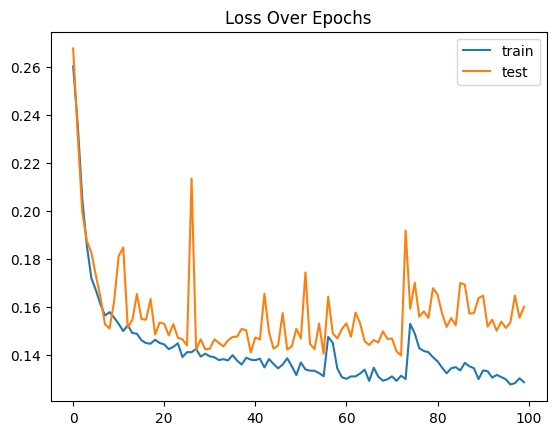

In [148]:
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), test_losses, label='test')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

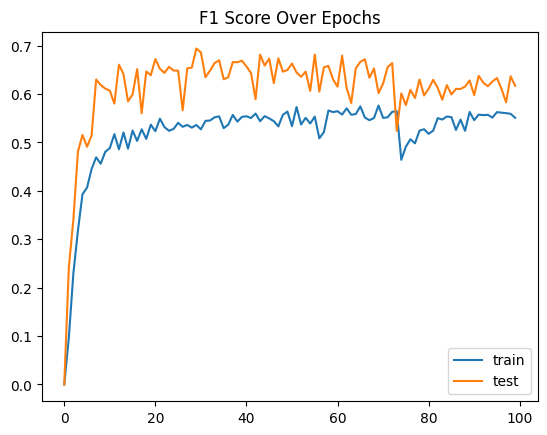

In [149]:
plt.plot(range(epochs), train_f1_scores, label='train')
plt.plot(range(epochs), test_f1_scores, label='test')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.show()

In [259]:
max(test_f1_scores)

0.6950240770465489

In [258]:
epochs = 100
lstm = LSTMModel(hidden_size=128, out_channels=40).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())
train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, lstm, lstm_train_dataloader3, lstm_test_dataloader3, epochs=epochs, save_best=True, save_name='best_rnn_model2.pt')

Epoch: 1 Train Loss: 0.1526340704407543 Test Loss: 0.14869250311923865
Epoch: 2 Train Loss: 0.14051736576259136 Test Loss: 0.14687698493940762
Epoch: 3 Train Loss: 0.13930131083279848 Test Loss: 0.1492627762025966
Epoch: 4 Train Loss: 0.13634079025611281 Test Loss: 0.14060143845530745
Epoch: 5 Train Loss: 0.1347521905735135 Test Loss: 0.14703113193543385
Epoch: 6 Train Loss: 0.13232848938852548 Test Loss: 0.14154507608090441
Epoch: 7 Train Loss: 0.1326153350546956 Test Loss: 0.14068467730876452
Epoch: 8 Train Loss: 0.1324405610397458 Test Loss: 0.13932220144465138
Epoch: 9 Train Loss: 0.131782396119833 Test Loss: 0.14125056325282437
Epoch: 10 Train Loss: 0.13175879689604045 Test Loss: 0.14648314563039774
Epoch: 11 Train Loss: 0.13110668652057647 Test Loss: 0.146717376807651
Epoch: 12 Train Loss: 0.13064057995304465 Test Loss: 0.13956380608720712
Epoch: 13 Train Loss: 0.13013650746494532 Test Loss: 0.13868924993843126
Epoch: 14 Train Loss: 0.1324908905029297 Test Loss: 0.143026849427543

In [256]:
model = torch.load('best_rnn_model2.pt')
model.eval()
real = []
pred = [] 
for x, y in lstm_test_dataloader3:
    x = x.to(device)
    y = y.to(device)
    real.append(y)
    out = model(x)
    pred.append(torch.argmax(out, dim=1))
print(f1_score(torch.cat(real).cpu(), torch.cat(pred).cpu()))

0.7133956386292835
